In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import torch

# Data Preprocessing for SVM



In [2]:
def load_Chiseq_Y(label_dir):
    # label_dir: "/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed"
    df = pd.read_csv(label_dir, header=None, sep="\t", names = ["seq_name", "ChIP-seq scores"])
    Y_score = np.array([df["ChIP-seq scores"].values.flatten()])
    Y_score = Y_score.reshape(-1, 1)
    return Y_score

In [3]:
def Chiseqscore_to_label(Y_score, method = "median"):
    if method == "mean":
        threshold = Y_score.mean()
    if method == "median":
        threshold = np.median(Y_score)
    Y_label = np.where(Y_score >= threshold, 1, 0)
    return Y_label

In [4]:
def cross_check_label_EDA(seq_dir, label_dir, TF_name, datatype = "training"):
    # cross check between seq_name from score file and seq file 
    # TF_name example: BATF
    labels = pd.read_csv(label_dir, header=None, sep="\t", names = ["seq_name", "ChIP-seq scores"])
    # plot chip-seq scores distriution in label file 
    plt.hist(labels['ChIP-seq scores'].values.flatten())
    plt.xlabel('ChIP-seq scores')
    plt.ylabel('count')
    plt.title('ChIP-seq scores for ' + datatype + "_" + TF_name  +  ' chart')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/CS582/figure/ChIP-seq_scores_" + datatype + "_" + TF_name + ".png")
    plt.show()

    label_seqname = labels['seq_name'].values.flatten().reshape(-1, 1)
    fd = open(seq_dir, 'r') 
    Lines = fd.readlines()
    seq_seqname_arr = np.array([])
    for line in Lines: 
        geneRegex = re.compile('>(\S+)')
        gene_rw = geneRegex.search(line)
        if gene_rw != None:
            seq_seqname_arr = np.append(seq_seqname_arr, gene_rw.group(1))

    seq_seqname_arr = seq_seqname_arr.reshape(-1,1)
    fd.close()
    match = np.array_equal(seq_seqname_arr, label_seqname)
    return match 


In [5]:
def pwm_conversion_padding (TFfolder_dir):
# example for TFfolder_dir: "/content/drive/MyDrive/CS582/topic1-data/BATF/"
# find max length of matrix 
# load all wtmx into a 2-D array with normalization: (normalize the matrix to [0-1] probabilty) * 100 
# padding (pad with the maximum length)
# return 3-D tensor (n,l,k), matrix_length_arr, dict_matrix 
# n: number of files or number of wtmx/pwm, l: length of the matrix, w: width of the matrix = 4
# matrix_length_arr contains the length of all wtmx 
# dict_matrix: key: index value: matrix name 
    files = []
    matrix_length_arr = []
    matrix_tensor_files = np.array([])
    matrices = []
    dict_matrix = {}
    matrix_tensor_files_index = 0 


    for file in os.listdir(TFfolder_dir):
        if file.endswith("wtmx"):
            files.append(file)
            # print(file)  # printing file name of desired extension
        else:
            continue
    # print(files)

    for file in files:
        f = open(TFfolder_dir+ file).readlines()
        for line in f:      
            matrix_header_Regex = re.compile(">(\S+)\s+(\S+)\s+(\S+)")
            matrix_header = matrix_header_Regex.search(line)
            if matrix_header != None:
                matrix_length_arr.append(int(matrix_header.group(2)))

    # padding_len contains the maximum length of wtmx given TF
    padding_len = np.max(matrix_length_arr)


    for file in files:
        # print(file)
        f = open(TFfolder_dir+ file).readlines()
        matrix_file = np.array([])
        for line in f:      
            matrixRegex = re.compile('(\S+)\s+(\S+)\s+(\S+)\s+(\S+)')
            matrix_rw = matrixRegex.search(line)
            if matrix_rw != None:
                matrix_row_file = np.array([])
                sum = 0 
                for i in range(4):
                    sum += float(matrix_rw.group(i+1))
                for i in range(4):
                    matrix_row_file = np.append(matrix_row_file, (float(matrix_rw.group(i+1))/sum)*100)
                if matrix_file.size == 0:
                    matrix_file = np.append(matrix_file, matrix_row_file, axis = 0)
                else:
                    matrix_file = np.vstack((matrix_file,matrix_row_file))

        # padding 
        len = matrix_file.shape[0]
        head_len = (padding_len - len)//2
        tail_len = padding_len - len - head_len     
        if head_len != 0: 
            head_pad = np.array([])
            for i in range(head_len):
                if head_pad.size == 0:
                    head_pad = np.append(head_pad, [25,25,25,25], axis = 0)
                else:
                    head_pad = np.vstack((head_pad,[25,25,25,25]))
            matrix_file = np.vstack((head_pad, matrix_file))
        if tail_len != 0:
            tail_pad = np.array([])
            for i in range(tail_len):
                if tail_pad.size == 0:
                    tail_pad = np.append(tail_pad, [25,25,25,25])
                else:
                    tail_pad = np.vstack((tail_pad,[25,25,25,25]))
            matrix_file = np.vstack((matrix_file, tail_pad))

        # print(matrix_file)
        matrices.append(matrix_file)
        dict_matrix[file] = matrix_tensor_files_index
        matrix_tensor_files_index += 1

    matrix_tensor_files = np.stack(matrices, axis=0)
    # print(matrix_tensor_files)
    return matrix_tensor_files, matrix_length_arr, dict_matrix

In [6]:
def pwm_convolution_seq(seq_dir, matrix_length_arr, matrix_tensor_files):
    # seq_dir example: "/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa"
    # one-hot encoding -> convolute with wtmx / calculate the PWM convolution -> generate X_train_seq_all_tensor 
    # hyperparameters: number of wtmx, which wtmx, stride 
    
    # return 3-D tensor X_train_seq_all_tensor (n, l, k)
    # matrix_length = np.max(matrix_length_arr) |  seq_length = X_train_seq_tensor[0].shape[0]
    # n: number of seq (=1000) l: number of pwm matrices: (=matrix_tensor_files.shape[0]) k: seq_length + 1 - matrix_length

    # return one-hot encoded 3-D tensor X_train_seq_tensor (n, l, k)
    # n: number of seq, l: length of the seq, k: 4 (one hot encoded: A:1000, C:0100, G:0010, T:0001)


    
    f = open(seq_dir).readlines()
    X_train_seq = np.array([])
    X_train_seq_tensor = np.array([])
    seqs = []
    matrix_length = np.max(matrix_length_arr)

    # extract X_train_seq from the file 
    for line in f:      
        seqname_Regex = re.compile(">(\S+)")
        seqname_id = seqname_Regex.search(line)

        if seqname_id != None:
            continue
        else:
            X_train_seq = np.append(X_train_seq, line.rstrip("\n"))
    
    X_train_seq = X_train_seq.reshape(-1,1)


    # one-hot encoding on X_train 
    for i in range(X_train_seq.shape[0]):
        data = [iter for iter in X_train_seq[i][0].upper()]
        values = np.array(data)
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(-1, 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        if onehot_encoded.shape[1] != 4:
            print("one-hot encoding violation " + str(i))
            continue
        seqs.append(onehot_encoded)
    X_train_seq_tensor = np.stack(seqs, axis=0)

    seq_length = X_train_seq_tensor[0].shape[0]

    # use convolution to find TF occupancy <might consider pytorch or tensorflow later>
    X_train_seq_all_tensor = np.array([]) # tensor contains mutiple matrices conv for multiple seqs for one TF 
    X_train_seq_single_matrices = [] # array contains mutiple matrices conv for multiple seqs for one TF 
    for i in range(X_train_seq_tensor.shape[0]):
        X_train_seq_single = np.array([]) # result from mutiple matrices for one seq for one single TF 
        for j in range(matrix_tensor_files.shape[0]):
            begin_index = 0
            end_index = matrix_length
            X_train_seq_single_conv = np.array([]) # result from one single matrix for one seq for one single TF
            for k in range(seq_length + 1 - matrix_length):
                res = np.sum(X_train_seq_tensor[i][begin_index:end_index, :] * matrix_tensor_files[j])
                begin_index += 1
                end_index += 1
                X_train_seq_single_conv = np.append(X_train_seq_single_conv, res)    
            if X_train_seq_single.size == 0:          
                X_train_seq_single = np.append(X_train_seq_single, X_train_seq_single_conv, axis = 0 )     
            else:
                X_train_seq_single = np.vstack((X_train_seq_single, X_train_seq_single_conv))
        X_train_seq_single_matrices.append(X_train_seq_single)
    X_train_seq_all_tensor = np.stack(X_train_seq_single_matrices, axis=0)
    return X_train_seq_all_tensor, X_train_seq_tensor


In [7]:
def background_convolution_seq(matrix_length_arr, X_train_seq_tensor, matrix_tensor_files):
    # return 3-D tensor backgound_seq_all_tensor (n, l, k)
    # matrix_length = np.max(matrix_length_arr) |  seq_length = X_train_seq_tensor[0].shape[0]
    # n: number of seq (=1000) l: number of pwm matrices: (=matrix_tensor_files.shape[0]) k: seq_length + 1 - matrix_length
    matrix_length = np.max(matrix_length_arr)
    seq_length = X_train_seq_tensor[0].shape[0]
    # building backgroud motif with length of max of matrix_length_arr
    background_matrix_tensor = np.array([])
    for i in range(matrix_length):
        if background_matrix_tensor.size == 0:
            background_matrix_tensor = np.append(background_matrix_tensor, [25,25,25,25])
        else:
            background_matrix_tensor = np.vstack((background_matrix_tensor,[25,25,25,25]))
    # use background matrix to get rid of background noise <might consider pytorch or tensorflow later>
    backgound_seq_all_tensor = np.array([]) # tensor contains background matrix conv for multiple seqs for one TF 
    backgound_seq_single_matrices = [] # array contains background matrix conv for multiple seqs for one TF 
    for i in range(X_train_seq_tensor.shape[0]):
        backgound_seq_single = np.array([]) # result from background matrix for one seq for one single TF 
        for j in range(matrix_tensor_files.shape[0]):
            begin_index = 0
            end_index = matrix_length
            backgound_seq_single_conv = np.array([]) # result from background matrix for one seq for one single TF
            for k in range(seq_length + 1 - matrix_length):
                res = np.sum(X_train_seq_tensor[i][begin_index:end_index, :] * background_matrix_tensor)
                begin_index += 1
                end_index += 1
                backgound_seq_single_conv = np.append(backgound_seq_single_conv, res)    
            if backgound_seq_single.size == 0:          
                backgound_seq_single = np.append(backgound_seq_single, backgound_seq_single_conv, axis = 0 )     
            else:
                backgound_seq_single = np.vstack((backgound_seq_single, backgound_seq_single_conv))
        backgound_seq_single_matrices.append(backgound_seq_single)
    backgound_seq_all_tensor = np.stack(backgound_seq_single_matrices, axis=0)
    return backgound_seq_all_tensor

In [8]:
def log_pwm_background(X_train_seq_all_tensor, backgound_seq_all_tensor):
    X_train_seq_all_tensor_noisefree = X_train_seq_all_tensor/backgound_seq_all_tensor
    return X_train_seq_all_tensor_noisefree

In [9]:
def X_max_generator(X_train_seq_all_tensor_noisefree):
    X_train_max = np.array([])
    for i in range(X_train_seq_all_tensor_noisefree.shape[0]):
        if X_train_max.size == 0:          
            X_train_max = np.append(X_train_max, np.max(X_train_seq_all_tensor_noisefree[i], axis = 0), axis = 0 )     
        else:
            X_train_max = np.vstack((X_train_max, np.max(X_train_seq_all_tensor_noisefree[i], axis = 0)))
    return X_train_max

In [10]:
def X_flatten_generator(X_train_seq_all_tensor_noisefree):
    X_train_flatten = np.array([])
    for i in range(X_train_seq_all_tensor_noisefree.shape[0]):
        if X_train_flatten.size == 0:          
            X_train_flatten = np.append(X_train_flatten, X_train_seq_all_tensor_noisefree[i].reshape(-1), axis = 0 )     
        else:
            X_train_flatten = np.vstack((X_train_flatten, X_train_seq_all_tensor_noisefree[i].reshape(-1)))
    return X_train_flatten

In [11]:
def cross_validation_svc(X_train, Y_train_label, cv_num, random_state_num):
    Y_train_label = Y_train_label.reshape(-1)
    clf = SVC(random_state=random_state_num)
    scores = cross_val_score(clf, X_train, Y_train_label, cv=cv_num)
    return scores

In [12]:
# violation_index_list from one-hot encoding 
def label_cleaning(Y_label, violation_index_list):
  res = np.array([])
  Y_label = Y_label.reshape(-1)
  for i in range(len(Y_label)):
      continue_flag = 0 
      for j in violation_index_list:
          if i == j:
              continue_flag = 1
      if continue_flag == 1:
          continue
      res = np.append(res, Y_label[i])
  return res 

# Train, Validate, Test on Various TFs


### **TF: BATF**

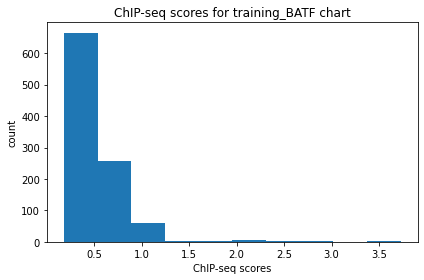

In [14]:
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed", TF_name ="BATF", datatype = "training")

matrix_tensor_files_train_BATF, matrix_length_arr_train_BATF, dict_matrix_train_BATF  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BATF/")

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, matrix_tensor_files_train_BATF)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, matrix_tensor_files_train_BATF)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)
X_train_flatten_train_BATF = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_BATF)


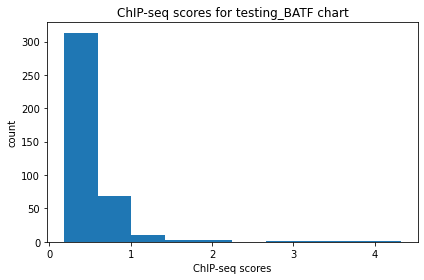

In [15]:
# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed", TF_name ="BATF", datatype = "testing")

matrix_tensor_files_test_BATF, matrix_length_arr_test_BATF, dict_matrix_test_BATF  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BATF/")

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, matrix_tensor_files_test_BATF)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, matrix_tensor_files_test_BATF)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)
X_test_flatten_test_BATF = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_BATF)

In [ ]:
# torch.save(X_test_max_test_BATF, "/content/drive/MyDrive/CS582/Xtest.pt")
# Y_testlabel_BATF = Y_testlabel_BATF.reshape(-1)
# torch.save(Y_testlabel_BATF, "/content/drive/MyDrive/CS582/Ytest.pt")
# torch.save(X_train_max_train_BATF, "/content/drive/MyDrive/CS582/Xtrain.pt")
# Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
# torch.save(Y_trainlabel_BATF, "/content/drive/MyDrive/CS582/Ytrain.pt")

In [ ]:
# print(dict_matrix_test_BATF == dict_matrix_train_BATF)
# print(matrix_length_arr_train_BATF == matrix_length_arr_test_BATF)
# match = np.array_equal(matrix_tensor_files_test_BATF,  matrix_tensor_files_train_BATF)
# print(match)

True
True
True


In [ ]:
# test = np.ones((3,3))
# a_test = np.log(test)
# print(a_test)

In [ ]:
clf_test = SVC(random_state=42)
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_BATF, Y_trainlabel_BATF, cv=10)
print(scores_test.mean())

0.6729999999999999


In [ ]:
# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.61


In [ ]:
# X_train_flatten_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BATF, Y_trainlabel_BATF)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_flatten_test_BATF
y_flattenpred_test_BATF = clf_train_flatten.predict(X_test_flatten_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_flattenpred_test_BATF))

Accuracy: 0.5675


Testing & Hyparameter Tunning Zoon

In [41]:
clf_test = SVC(C = 0.0001, random_state=42)
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_BATF, Y_trainlabel_BATF, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)


# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))



# X_train_flatten_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_flatten = SVC(C = 0.0001, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_flatten_test_BATF
y_flattenpred_test_BATF = clf_train_flatten.predict(X_test_flatten_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_flattenpred_test_BATF))

0.6659999999999999
Accuracy: 0.635
Accuracy: 0.6225


In [43]:
y_train_max_pred = clf_train_max.predict(X_train_max_train_BATF) 
metrics.accuracy_score(Y_trainlabel_BATF[400:800], y_train_max_pred[400:800]) 

0.7725

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


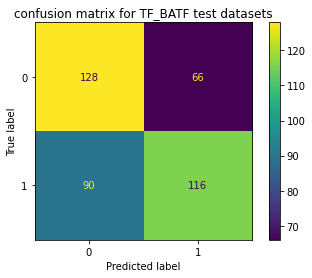

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_train_max, X_test_max_test_BATF, Y_testlabel_BATF)
plt.title("confusion matrix for TF_BATF test datasets")
plt.savefig("/content/drive/MyDrive/CS582/figure/confusion_matrix_BATF_test") 
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


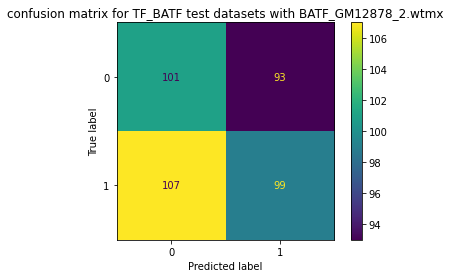

In [ ]:
plot_confusion_matrix(clf_train_max, X_test_max_test_BATF, Y_testlabel_BATF)
plt.title("confusion matrix for TF_BATF test datasets with BATF_GM12878_2.wtmx")
plt.savefig("/content/drive/MyDrive/CS582/figure/confusion_matrix_BATF_test_single_wtmx.png", bbox_inches = 'tight') 
plt.show()


In [ ]:
C_range = np.linspace(0.01, 10, num=20)
score_mean = []
for i in C_range:
    clf_test = SVC(C = i, random_state=42)
    Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
    scores_test = cross_val_score(clf_test, X_train_max_train_BATF, Y_trainlabel_BATF, cv=10)
    print(scores_test.mean())
    print(i)
    score_mean.append(scores_test.mean())
print(C_range)

0.6659999999999999
0.01
0.671
0.5357894736842106
0.6689999999999999
1.0615789473684212
0.67
1.5873684210526318
0.665
2.113157894736842
0.6649999999999999
2.6389473684210527
0.6649999999999999
3.1647368421052633
0.6649999999999999
3.690526315789474
0.6649999999999999
4.2163157894736845
0.6649999999999999
4.742105263157895
0.6649999999999999
5.267894736842106
0.6649999999999999
5.793684210526316
0.6649999999999999
6.319473684210527
0.6649999999999999
6.845263157894737
0.6649999999999999
7.371052631578948
0.6649999999999999
7.8968421052631586
0.6649999999999999
8.42263157894737
0.6649999999999999
8.948421052631579
0.6649999999999999
9.47421052631579
0.6649999999999999
10.0
[ 0.01        0.53578947  1.06157895  1.58736842  2.11315789  2.63894737
  3.16473684  3.69052632  4.21631579  4.74210526  5.26789474  5.79368421
  6.31947368  6.84526316  7.37105263  7.89684211  8.42263158  8.94842105
  9.47421053 10.        ]


In [ ]:
print(score_mean)

[0.6659999999999999, 0.671, 0.6689999999999999, 0.67, 0.665, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999, 0.6649999999999999]


Baseline Comparison (single wtmx) & finding most valuable wtmx 

In [ ]:
dict_matrix_train_BATF

{'BATF_FB_1.wtmx': 7,
 'BATF_GM12878_1.wtmx': 3,
 'BATF_GM12878_2.wtmx': 4,
 'BATF_GM12878_3.wtmx': 6,
 'BATF_GM12878_4.wtmx': 1,
 'BATF_GM12878_5.wtmx': 0,
 'BATF_HOCO_A.wtmx': 2,
 'BATF_HOCO_S.wtmx': 5}

In [ ]:
# matrix_tensor_files_train_BATF[0]
# print(matrix_tensor_files_train_BATF[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_BATF[7],(8, 1,1))
# print(one_wtmx.shape)
# print(one_wtmx)

In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[0],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.575


In [ ]:
# print(X_test_seq_all_tensor_noisefree_test_BATF.shape)
# print(X_test_seq_all_tensor_noisefree_test_BATF)
# print(X_train_seq_all_tensor_noisefree_train_BATF.shape)
# print(X_train_seq_all_tensor_noisefree_train_BATF)

In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[1],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.51


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[2],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.58


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[3],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.59


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[4],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.5


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[5],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.5575


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[6],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.57


In [ ]:
one_wtmx = np.tile(matrix_tensor_files_train_BATF[7],(8, 1,1))
# loading training data for TF BATF
Y_train_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train.bed")
Y_trainlabel_BATF = Chiseqscore_to_label(Y_train_BATF)

X_train_seq_all_tensor_train_BATF, X_train_seq_tensor_train_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-train-sequence.fa", matrix_length_arr_train_BATF, one_wtmx)
backgound_seq_all_tensor_train_BATF = background_convolution_seq(matrix_length_arr_train_BATF, X_train_seq_tensor_train_BATF, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BATF = log_pwm_background(X_train_seq_all_tensor_train_BATF, backgound_seq_all_tensor_train_BATF)
X_train_max_train_BATF = X_max_generator(X_train_seq_all_tensor_noisefree_train_BATF)

# loading testing data for TF BATF
Y_test_BATF = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test.bed")
Y_testlabel_BATF = Chiseqscore_to_label(Y_test_BATF)

X_test_seq_all_tensor_test_BATF, X_test_seq_tensor_test_BATF = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BATF/BATF-test-sequence.fa", matrix_length_arr_test_BATF, one_wtmx)
backgound_seq_all_tensor_test_BATF = background_convolution_seq(matrix_length_arr_test_BATF, X_test_seq_tensor_test_BATF, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BATF = log_pwm_background(X_test_seq_all_tensor_test_BATF, backgound_seq_all_tensor_test_BATF)
X_test_max_test_BATF = X_max_generator(X_test_seq_all_tensor_noisefree_test_BATF)


# X_train_max_train_TFname training 
Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))

Accuracy: 0.5125


In [ ]:
# Tried np.log(pwm)/np.log(background)
# clf_test = SVC(random_state=42)
# Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
# scores_test = cross_val_score(clf_test, X_train_max_train_BATF, Y_trainlabel_BATF, cv=10)
# print(scores_test.mean())
# # X_train_max_train_TFname training 
# Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
# clf_train_max = SVC(random_state=42)
# clf_train_max.fit(X_train_max_train_BATF, Y_trainlabel_BATF)
# # Prediction on X_test_max_test_BCL3
# y_maxpred_test_BATF = clf_train_max.predict(X_test_max_test_BATF)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_maxpred_test_BATF))
# # X_train_flatten_train_TFname training 
# Y_trainlabel_BATF = Y_trainlabel_BATF.reshape(-1)
# clf_train_flatten = SVC(random_state=42)
# clf_train_flatten.fit(X_train_flatten_train_BATF, Y_trainlabel_BATF)
# # Prediction on X_test_flatten_test_BATF
# y_flattenpred_test_BATF = clf_train_flatten.predict(X_test_flatten_test_BATF)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_BATF, y_flattenpred_test_BATF))

0.6599999999999999
Accuracy: 0.6
Accuracy: 0.56


### **TF: BCL3**

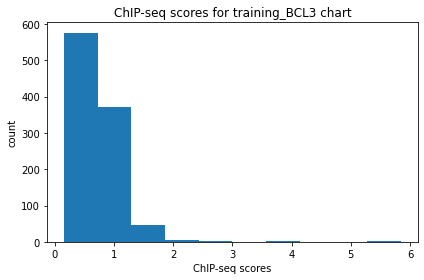

one-hot encoding violation 598


In [44]:
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed", TF_name ="BCL3", datatype = "training")
matrix_tensor_files_train_BCL3, matrix_length_arr_train_BCL3, dict_matrix_train_BCL3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BCL3/")
X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, matrix_tensor_files_train_BCL3)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, matrix_tensor_files_train_BCL3)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)
X_train_flatten_train_BCL3 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_BCL3)


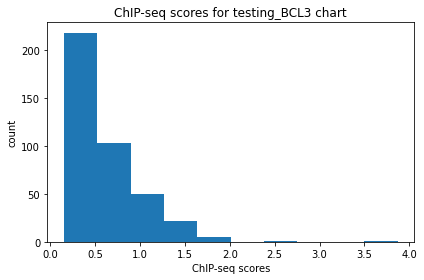

In [45]:
# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed", TF_name ="BCL3", datatype = "testing")
matrix_tensor_files_test_BCL3, matrix_length_arr_test_BCL3, dict_matrix_test_BCL3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BCL3/")
X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, matrix_tensor_files_test_BCL3)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, matrix_tensor_files_test_BCL3)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)
X_test_flatten_test_BCL3 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

In [48]:
Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])

In [ ]:
clf_test = SVC(random_state=42)
scores_test = cross_val_score(clf_test, X_train_max_train_BCL3, Y_trainlabel_BCL3, cv=10)
print(scores_test.mean())

0.7848080808080808


In [ ]:
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

Accuracy: 0.74


In [ ]:
# X_train_flatten_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BCL3, Y_trainlabel_BCL3)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_flatten_test_BCL3
y_flattenpred_test_BCL3 = clf_train_flatten.predict(X_test_flatten_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_flattenpred_test_BCL3))

Accuracy: 0.7325


In [66]:
clf_test = SVC(C = 0.5, random_state=42)
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_BCL3, Y_trainlabel_BCL3, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(C = 0.5, random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)


# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))



# X_train_flatten_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_flatten = SVC(C = 0.5, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_flatten_test_BCL3
y_flattenpred_test_BCL3 = clf_train_flatten.predict(X_test_flatten_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_flattenpred_test_BCL3))

0.7838080808080808
Accuracy: 0.74
Accuracy: 0.7275


In [67]:
y_train_max_pred = clf_train_max.predict(X_train_max_train_BCL3) 
metrics.accuracy_score(Y_trainlabel_BCL3, y_train_max_pred) 

0.8038038038038038

In [68]:
dict_matrix_train_BCL3

{'BCL3_GM12878_1.wtmx': 0,
 'BCL3_GM12878_2.wtmx': 1,
 'BCL3_GM12878_3.wtmx': 3,
 'BCL3_GM12878_4.wtmx': 2,
 'BCL3_GM12878_5.wtmx': 4}

In [86]:
# print(matrix_tensor_files_train_BCL3[3])
# print(matrix_tensor_files_train_BCL3[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[4],(5, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

(5, 25, 4)


In [74]:
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[0],(5, 1,1))
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)

X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, one_wtmx)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)

# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)

X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, one_wtmx)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

one-hot encoding violation 598
Accuracy: 0.72


In [76]:
# print(X_test_seq_all_tensor_noisefree_test_BCL3.shape)
# print(X_test_seq_all_tensor_noisefree_test_BCL3)
# print(X_train_seq_all_tensor_noisefree_train_BCL3.shape)
# print(X_train_seq_all_tensor_noisefree_train_BCL3)

In [78]:
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[1],(5, 1,1))
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)

X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, one_wtmx)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)

# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)

X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, one_wtmx)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

one-hot encoding violation 598
Accuracy: 0.72


In [79]:
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[2],(5, 1,1))
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)

X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, one_wtmx)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)

# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)

X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, one_wtmx)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

one-hot encoding violation 598
Accuracy: 0.655


In [80]:
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[3],(5, 1,1))
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)

X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, one_wtmx)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)

# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)

X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, one_wtmx)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

one-hot encoding violation 598
Accuracy: 0.725


In [81]:
one_wtmx = np.tile(matrix_tensor_files_train_BCL3[4],(5, 1,1))
# loading training data for TF BCL3
Y_train_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train.bed")
Y_trainlabel_BCL3 = Chiseqscore_to_label(Y_train_BCL3)

X_train_seq_all_tensor_train_BCL3, X_train_seq_tensor_train_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-train-sequence.fa", matrix_length_arr_train_BCL3, one_wtmx)
backgound_seq_all_tensor_train_BCL3 = background_convolution_seq(matrix_length_arr_train_BCL3, X_train_seq_tensor_train_BCL3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BCL3 = log_pwm_background(X_train_seq_all_tensor_train_BCL3, backgound_seq_all_tensor_train_BCL3)
X_train_max_train_BCL3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BCL3)

# loading testing data for TF BCL3
Y_test_BCL3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test.bed")
Y_testlabel_BCL3 = Chiseqscore_to_label(Y_test_BCL3)

X_test_seq_all_tensor_test_BCL3, X_test_seq_tensor_test_BCL3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BCL3/BCL3-test-sequence.fa", matrix_length_arr_test_BCL3, one_wtmx)
backgound_seq_all_tensor_test_BCL3 = background_convolution_seq(matrix_length_arr_test_BCL3, X_test_seq_tensor_test_BCL3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BCL3 = log_pwm_background(X_test_seq_all_tensor_test_BCL3, backgound_seq_all_tensor_test_BCL3)
X_test_max_test_BCL3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BCL3)

Y_trainlabel_BCL3 = label_cleaning(Y_trainlabel_BCL3, violation_index_list = [598])
# X_train_max_train_TFname training 
Y_trainlabel_BCL3 = Y_trainlabel_BCL3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BCL3, Y_trainlabel_BCL3)
# Prediction on X_test_max_test_BCL3
y_maxpred_test_BCL3 = clf_train_max.predict(X_test_max_test_BCL3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BCL3, y_maxpred_test_BCL3))

one-hot encoding violation 598
Accuracy: 0.725


### **TF: BHLHE40**

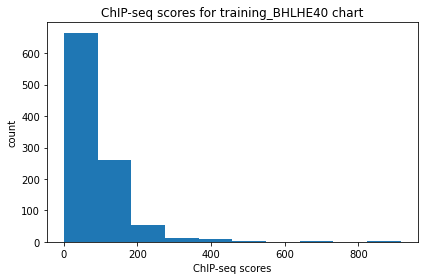

one-hot encoding violation 569


In [113]:
# loading training data for TF BHLHE40
Y_train_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train.bed")
Y_trainlabel_BHLHE40 = Chiseqscore_to_label(Y_train_BHLHE40)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train.bed", TF_name ="BHLHE40", datatype = "training")
matrix_tensor_files_train_BHLHE40, matrix_length_arr_train_BHLHE40, dict_matrix_train_BHLHE40  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/")
X_train_seq_all_tensor_train_BHLHE40, X_train_seq_tensor_train_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train-sequence.fa", matrix_length_arr_train_BHLHE40, matrix_tensor_files_train_BHLHE40)
backgound_seq_all_tensor_train_BHLHE40 = background_convolution_seq(matrix_length_arr_train_BHLHE40, X_train_seq_tensor_train_BHLHE40, matrix_tensor_files_train_BHLHE40)
X_train_seq_all_tensor_noisefree_train_BHLHE40 = log_pwm_background(X_train_seq_all_tensor_train_BHLHE40, backgound_seq_all_tensor_train_BHLHE40)
X_train_max_train_BHLHE40 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BHLHE40)
X_train_flatten_train_BHLHE40 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_BHLHE40)

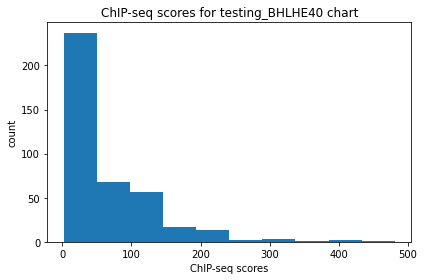

In [114]:
# loading testing data for TF BHLHE40
Y_test_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test.bed")
Y_testlabel_BHLHE40 = Chiseqscore_to_label(Y_test_BHLHE40)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test.bed", TF_name ="BHLHE40", datatype = "testing")
matrix_tensor_files_test_BHLHE40, matrix_length_arr_test_BHLHE40, dict_matrix_test_BHLHE40  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/")
X_test_seq_all_tensor_test_BHLHE40, X_test_seq_tensor_test_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test-sequence.fa", matrix_length_arr_test_BHLHE40, matrix_tensor_files_test_BHLHE40)
backgound_seq_all_tensor_test_BHLHE40 = background_convolution_seq(matrix_length_arr_test_BHLHE40, X_test_seq_tensor_test_BHLHE40, matrix_tensor_files_test_BHLHE40)
X_test_seq_all_tensor_noisefree_test_BHLHE40 = log_pwm_background(X_test_seq_all_tensor_test_BHLHE40, backgound_seq_all_tensor_test_BHLHE40)
X_test_max_test_BHLHE40 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BHLHE40)
X_test_flatten_test_BHLHE40 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_BHLHE40)

In [116]:
Y_trainlabel_BHLHE40 = label_cleaning(Y_trainlabel_BHLHE40, violation_index_list = [569])

In [ ]:
clf_test = SVC(random_state=42)
scores_test = cross_val_score(clf_test, X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40, cv=10)
print(scores_test.mean())

0.5655252525252525


In [ ]:
# X_train_max_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_max_test_BHLHE40
y_maxpred_test_BHLHE40 = clf_train_max.predict(X_test_max_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_maxpred_test_BHLHE40))

Accuracy: 0.51


In [ ]:
# X_train_flatten_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BHLHE40, Y_trainlabel_BHLHE40)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_flatten_test_BHLHE40
y_flattenpred_test_BHLHE40 = clf_train_flatten.predict(X_test_flatten_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_flattenpred_test_BHLHE40))

Accuracy: 0.525


In [117]:
clf_test = SVC(C = 0.05, random_state=42)
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40)


# Prediction on X_test_max_test_BHLHE40
y_maxpred_test_BHLHE40 = clf_train_max.predict(X_test_max_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_maxpred_test_BHLHE40))



# X_train_flatten_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_flatten = SVC(C = 0.05, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_BHLHE40, Y_trainlabel_BHLHE40)
# Prediction on X_test_flatten_test_BHLHE40
y_flattenpred_test_BHLHE40 = clf_train_flatten.predict(X_test_flatten_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_flattenpred_test_BHLHE40))

0.5015151515151516
Accuracy: 0.5
Accuracy: 0.5


In [118]:
y_train_max_pred = clf_train_max.predict(X_train_max_train_BHLHE40) 
metrics.accuracy_score(Y_trainlabel_BHLHE40, y_train_max_pred) 

0.5005005005005005

In [98]:
dict_matrix_train_BHLHE40

{'BHLHE40_FB_1.wtmx': 5,
 'BHLHE40_GM12878_1.wtmx': 1,
 'BHLHE40_GM12878_2.wtmx': 4,
 'BHLHE40_GM12878_3.wtmx': 2,
 'BHLHE40_GM12878_4.wtmx': 0,
 'BHLHE40_GM12878_5.wtmx': 3}

In [100]:
# print(matrix_tensor_files_train_BHLHE40[3])
# print(matrix_tensor_files_train_BHLHE40[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_BHLHE40[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

(6, 21, 4)


In [106]:
one_wtmx = np.tile(matrix_tensor_files_train_BHLHE40[0],(6, 1,1))
# loading training data for TF BHLHE40
Y_train_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train.bed")
Y_trainlabel_BHLHE40 = Chiseqscore_to_label(Y_train_BHLHE40)

X_train_seq_all_tensor_train_BHLHE40, X_train_seq_tensor_train_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train-sequence.fa", matrix_length_arr_train_BHLHE40, one_wtmx)
backgound_seq_all_tensor_train_BHLHE40 = background_convolution_seq(matrix_length_arr_train_BHLHE40, X_train_seq_tensor_train_BHLHE40, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BHLHE40 = log_pwm_background(X_train_seq_all_tensor_train_BHLHE40, backgound_seq_all_tensor_train_BHLHE40)
X_train_max_train_BHLHE40 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BHLHE40)

# loading testing data for TF BHLHE40
Y_test_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test.bed")
Y_testlabel_BHLHE40 = Chiseqscore_to_label(Y_test_BHLHE40)

X_test_seq_all_tensor_test_BHLHE40, X_test_seq_tensor_test_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test-sequence.fa", matrix_length_arr_test_BHLHE40, one_wtmx)
backgound_seq_all_tensor_test_BHLHE40 = background_convolution_seq(matrix_length_arr_test_BHLHE40, X_test_seq_tensor_test_BHLHE40, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BHLHE40 = log_pwm_background(X_test_seq_all_tensor_test_BHLHE40, backgound_seq_all_tensor_test_BHLHE40)
X_test_max_test_BHLHE40 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BHLHE40)

Y_trainlabel_BHLHE40 = label_cleaning(Y_trainlabel_BHLHE40, violation_index_list = [569])
# X_train_max_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40)
# Prediction on X_test_max_test_BHLHE40
y_maxpred_test_BHLHE40 = clf_train_max.predict(X_test_max_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_maxpred_test_BHLHE40))

one-hot encoding violation 569
Accuracy: 0.54


In [104]:
# print(X_test_seq_all_tensor_noisefree_test_BCL3.shape)
# print(X_test_seq_all_tensor_noisefree_test_BCL3)
# print(X_train_seq_all_tensor_noisefree_train_BCL3.shape)
# print(X_train_seq_all_tensor_noisefree_train_BCL3)

In [105]:
one_wtmx = np.tile(matrix_tensor_files_train_BHLHE40[1],(6, 1,1))
# loading training data for TF BHLHE40
Y_train_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train.bed")
Y_trainlabel_BHLHE40 = Chiseqscore_to_label(Y_train_BHLHE40)

X_train_seq_all_tensor_train_BHLHE40, X_train_seq_tensor_train_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-train-sequence.fa", matrix_length_arr_train_BHLHE40, one_wtmx)
backgound_seq_all_tensor_train_BHLHE40 = background_convolution_seq(matrix_length_arr_train_BHLHE40, X_train_seq_tensor_train_BHLHE40, one_wtmx)
X_train_seq_all_tensor_noisefree_train_BHLHE40 = log_pwm_background(X_train_seq_all_tensor_train_BHLHE40, backgound_seq_all_tensor_train_BHLHE40)
X_train_max_train_BHLHE40 = X_max_generator(X_train_seq_all_tensor_noisefree_train_BHLHE40)

# loading testing data for TF BHLHE40
Y_test_BHLHE40 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test.bed")
Y_testlabel_BHLHE40 = Chiseqscore_to_label(Y_test_BHLHE40)

X_test_seq_all_tensor_test_BHLHE40, X_test_seq_tensor_test_BHLHE40 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/BHLHE40/BHLHE40-test-sequence.fa", matrix_length_arr_test_BHLHE40, one_wtmx)
backgound_seq_all_tensor_test_BHLHE40 = background_convolution_seq(matrix_length_arr_test_BHLHE40, X_test_seq_tensor_test_BHLHE40, one_wtmx)
X_test_seq_all_tensor_noisefree_test_BHLHE40 = log_pwm_background(X_test_seq_all_tensor_test_BHLHE40, backgound_seq_all_tensor_test_BHLHE40)
X_test_max_test_BHLHE40 = X_max_generator(X_test_seq_all_tensor_noisefree_test_BHLHE40)

Y_trainlabel_BHLHE40 = label_cleaning(Y_trainlabel_BHLHE40, violation_index_list = [569])
# X_train_max_train_TFname training 
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40)
# Prediction on X_test_max_test_BHLHE40
y_maxpred_test_BHLHE40 = clf_train_max.predict(X_test_max_test_BHLHE40)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_BHLHE40, y_maxpred_test_BHLHE40))

one-hot encoding violation 569
Accuracy: 0.55


### **TF: EBF1**

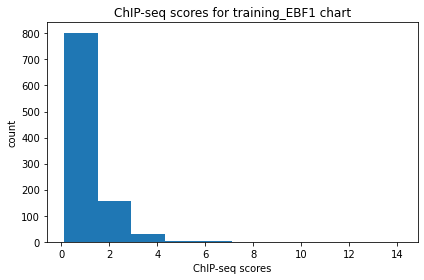

In [13]:
# loading training data for TF EBF1
Y_train_EBF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train.bed")
Y_trainlabel_EBF1 = Chiseqscore_to_label(Y_train_EBF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train.bed", TF_name ="EBF1", datatype = "training")
matrix_tensor_files_train_EBF1, matrix_length_arr_train_EBF1, dict_matrix_train_EBF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/EBF1/")
X_train_seq_all_tensor_train_EBF1, X_train_seq_tensor_train_EBF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train-sequence.fa", matrix_length_arr_train_EBF1, matrix_tensor_files_train_EBF1)
backgound_seq_all_tensor_train_EBF1 = background_convolution_seq(matrix_length_arr_train_EBF1, X_train_seq_tensor_train_EBF1, matrix_tensor_files_train_EBF1)
X_train_seq_all_tensor_noisefree_train_EBF1 = log_pwm_background(X_train_seq_all_tensor_train_EBF1, backgound_seq_all_tensor_train_EBF1)
X_train_max_train_EBF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_EBF1)
X_train_flatten_train_EBF1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_EBF1)

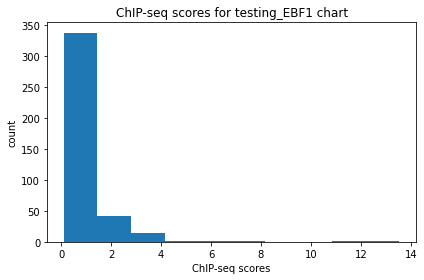

In [14]:
# loading testing data for TF EBF1
Y_test_EBF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test.bed")
Y_testlabel_EBF1 = Chiseqscore_to_label(Y_test_EBF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test.bed", TF_name ="EBF1", datatype = "testing")
matrix_tensor_files_test_EBF1, matrix_length_arr_test_EBF1, dict_matrix_test_EBF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/EBF1/")
X_test_seq_all_tensor_test_EBF1, X_test_seq_tensor_test_EBF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test-sequence.fa", matrix_length_arr_test_EBF1, matrix_tensor_files_test_EBF1)
backgound_seq_all_tensor_test_EBF1 = background_convolution_seq(matrix_length_arr_test_EBF1, X_test_seq_tensor_test_EBF1, matrix_tensor_files_test_EBF1)
X_test_seq_all_tensor_noisefree_test_EBF1 = log_pwm_background(X_test_seq_all_tensor_test_EBF1, backgound_seq_all_tensor_test_EBF1)
X_test_max_test_EBF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_EBF1)
X_test_flatten_test_EBF1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_EBF1)

In [ ]:
clf_test = SVC(random_state=42)
Y_trainlabel_BHLHE40 = Y_trainlabel_BHLHE40.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_BHLHE40, Y_trainlabel_BHLHE40, cv=10)
print(scores_test.mean())

0.5655252525252525


In [ ]:
# X_train_max_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_EBF1, Y_trainlabel_EBF1)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_max_test_EBF1
y_maxpred_test_EBF1 = clf_train_max.predict(X_test_max_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_maxpred_test_EBF1))

Accuracy: 0.6325


In [ ]:
# X_train_flatten_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_EBF1, Y_trainlabel_EBF1)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_flatten_test_EBF1
y_flattenpred_test_EBF1 = clf_train_flatten.predict(X_test_flatten_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_flattenpred_test_EBF1))

Accuracy: 0.605


In [44]:
clf_test = SVC(C = 0.05, random_state=42)
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_EBF1, Y_trainlabel_EBF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_max = SVC(C = 0.001, random_state=42)
clf_train_max.fit(X_train_max_train_EBF1, Y_trainlabel_EBF1)


# Prediction on X_test_max_test_EBF1
y_maxpred_test_EBF1 = clf_train_max.predict(X_test_max_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_maxpred_test_EBF1))



# X_train_flatten_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_flatten = SVC(C = 0.05, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_EBF1, Y_trainlabel_EBF1)
# Prediction on X_test_flatten_test_EBF1
y_flattenpred_test_EBF1 = clf_train_flatten.predict(X_test_flatten_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_flattenpred_test_EBF1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_EBF1) 
metrics.accuracy_score(Y_trainlabel_EBF1[450:850], y_train_max_pred[450:850])

0.634
Accuracy: 0.5975
Accuracy: 0.5775


0.8275

In [48]:
# X_train_max_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_max = SVC(C = 5, random_state=42)
clf_train_max.fit(X_train_max_train_EBF1, Y_trainlabel_EBF1)
# Prediction on X_test_max_test_EBF1
y_maxpred_test_EBF1 = clf_train_max.predict(X_test_max_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_maxpred_test_EBF1))


Accuracy: 0.6475


In [50]:
print(dict_matrix_train_EBF1)
# print(matrix_tensor_files_train_EBF1[3])
# print(matrix_tensor_files_train_EBF1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_EBF1[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'EBF1_GM12878_1.wtmx': 0, 'EBF1_GM12878_4.wtmx': 1, 'EBF1_GM12878_2.wtmx': 2, 'EBF1_GM12878_3.wtmx': 3, 'EBF1_GM12878_5.wtmx': 4, 'EBF1_FB_1.wtmx': 5}
(6, 15, 4)


In [52]:
one_wtmx = np.tile(matrix_tensor_files_train_EBF1[0],(6, 1,1))
# loading training data for TF EBF1
Y_train_EBF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train.bed")
Y_trainlabel_EBF1 = Chiseqscore_to_label(Y_train_EBF1)

X_train_seq_all_tensor_train_EBF1, X_train_seq_tensor_train_EBF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-train-sequence.fa", matrix_length_arr_train_EBF1, one_wtmx)
backgound_seq_all_tensor_train_EBF1 = background_convolution_seq(matrix_length_arr_train_EBF1, X_train_seq_tensor_train_EBF1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_EBF1 = log_pwm_background(X_train_seq_all_tensor_train_EBF1, backgound_seq_all_tensor_train_EBF1)
X_train_max_train_EBF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_EBF1)

# loading testing data for TF EBF1
Y_test_EBF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test.bed")
Y_testlabel_EBF1 = Chiseqscore_to_label(Y_test_EBF1)

X_test_seq_all_tensor_test_EBF1, X_test_seq_tensor_test_EBF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EBF1/EBF1-test-sequence.fa", matrix_length_arr_test_EBF1, one_wtmx)
backgound_seq_all_tensor_test_EBF1 = background_convolution_seq(matrix_length_arr_test_EBF1, X_test_seq_tensor_test_EBF1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_EBF1 = log_pwm_background(X_test_seq_all_tensor_test_EBF1, backgound_seq_all_tensor_test_EBF1)
X_test_max_test_EBF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_EBF1)

# X_train_max_train_TFname training 
Y_trainlabel_EBF1 = Y_trainlabel_EBF1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_EBF1, Y_trainlabel_EBF1)
# Prediction on X_test_max_test_EBF1
y_maxpred_test_EBF1 = clf_train_max.predict(X_test_max_test_EBF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EBF1, y_maxpred_test_EBF1))

Accuracy: 0.6025


In [55]:
# print(X_test_seq_all_tensor_noisefree_test_EBF1.shape)
# print(X_test_seq_all_tensor_noisefree_test_EBF1)
# print(X_train_seq_all_tensor_noisefree_train_EBF1.shape)
# print(X_train_seq_all_tensor_noisefree_train_EBF1)

### **TF: EGR1** 



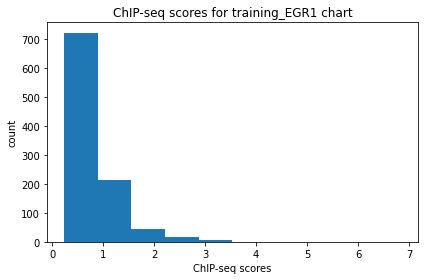

In [64]:
# loading training data for TF EGR1
Y_train_EGR1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train.bed")
Y_trainlabel_EGR1 = Chiseqscore_to_label(Y_train_EGR1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train.bed", TF_name ="EGR1", datatype = "training")
matrix_tensor_files_train_EGR1, matrix_length_arr_train_EGR1, dict_matrix_train_EGR1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/EGR1/")
X_train_seq_all_tensor_train_EGR1, X_train_seq_tensor_train_EGR1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train-sequence.fa", matrix_length_arr_train_EGR1, matrix_tensor_files_train_EGR1)
backgound_seq_all_tensor_train_EGR1 = background_convolution_seq(matrix_length_arr_train_EGR1, X_train_seq_tensor_train_EGR1, matrix_tensor_files_train_EGR1)
X_train_seq_all_tensor_noisefree_train_EGR1 = log_pwm_background(X_train_seq_all_tensor_train_EGR1, backgound_seq_all_tensor_train_EGR1)
X_train_max_train_EGR1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_EGR1)
X_train_flatten_train_EGR1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_EGR1)

In [ ]:
# np.median(Y_trainlabel_EGR1)

0.5

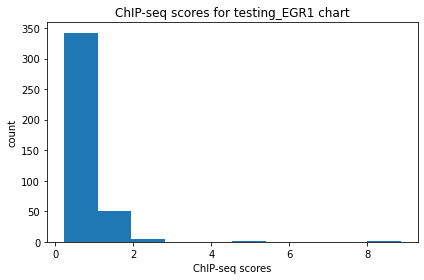

In [65]:
# loading testing data for TF EGR1
Y_test_EGR1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test.bed")
Y_testlabel_EGR1 = Chiseqscore_to_label(Y_test_EGR1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test.bed", TF_name ="EGR1", datatype = "testing")
matrix_tensor_files_test_EGR1, matrix_length_arr_test_EGR1, dict_matrix_test_EGR1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/EGR1/")
X_test_seq_all_tensor_test_EGR1, X_test_seq_tensor_test_EGR1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test-sequence.fa", matrix_length_arr_test_EGR1, matrix_tensor_files_test_EGR1)
backgound_seq_all_tensor_test_EGR1 = background_convolution_seq(matrix_length_arr_test_EGR1, X_test_seq_tensor_test_EGR1, matrix_tensor_files_test_EGR1)
X_test_seq_all_tensor_noisefree_test_EGR1 = log_pwm_background(X_test_seq_all_tensor_test_EGR1, backgound_seq_all_tensor_test_EGR1)
X_test_max_test_EGR1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_EGR1)
X_test_flatten_test_EGR1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_EGR1)

In [ ]:
clf_test = SVC(random_state=42)
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_EGR1, Y_trainlabel_EGR1, cv=10)
print(scores_test.mean())

0.78


In [ ]:
# X_train_max_train_TFname training 
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_EGR1, Y_trainlabel_EGR1)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_max_test_EGR1
y_maxpred_test_EGR1 = clf_train_max.predict(X_test_max_test_EGR1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EGR1, y_maxpred_test_EGR1))

Accuracy: 0.77


In [ ]:
# X_train_flatten_train_TFname training 
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_EGR1, Y_trainlabel_EGR1)

SVC(random_state=42)

In [ ]:
# Prediction on X_test_flatten_test_EGR1
y_flattenpred_test_EGR1 = clf_train_flatten.predict(X_test_flatten_test_EGR1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EGR1, y_flattenpred_test_EGR1))

Accuracy: 0.7475


In [66]:
clf_test = SVC(C = 0.05, random_state=42)
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_EGR1, Y_trainlabel_EGR1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_EGR1, Y_trainlabel_EGR1)


# Prediction on X_test_max_test_EGR1
y_maxpred_test_EGR1 = clf_train_max.predict(X_test_max_test_EGR1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EGR1, y_maxpred_test_EGR1))



# X_train_flatten_train_TFname training 
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
clf_train_flatten = SVC(C = 0.05, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_EGR1, Y_trainlabel_EGR1)
# Prediction on X_test_flatten_test_EGR1
y_flattenpred_test_EGR1 = clf_train_flatten.predict(X_test_flatten_test_EGR1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EGR1, y_flattenpred_test_EGR1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_EGR1) 
metrics.accuracy_score(Y_trainlabel_EGR1, y_train_max_pred)

0.7779999999999999
Accuracy: 0.7425
Accuracy: 0.7175


0.79

In [67]:
print(dict_matrix_train_EGR1)
# print(matrix_tensor_files_train_EGR1[3])
# print(matrix_tensor_files_train_EGR1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_EGR1[4],(8, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'EGR1_GM12878_5.wtmx': 0, 'EGR1_HOCO_S.wtmx': 1, 'EGR1_GM12878_1.wtmx': 2, 'EGR1_HOCO_A.wtmx': 3, 'EGR1_GM12878_2.wtmx': 4, 'EGR1_FB_1.wtmx': 5, 'EGR1_GM12878_4.wtmx': 6, 'EGR1_GM12878_3.wtmx': 7}
(8, 30, 4)


In [62]:
one_wtmx = np.tile(matrix_tensor_files_train_EGR1[0],(8, 1,1))
# loading training data for TF EGR1
Y_train_EGR1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train.bed")
Y_trainlabel_EGR1 = Chiseqscore_to_label(Y_train_EGR1)

X_train_seq_all_tensor_train_EGR1, X_train_seq_tensor_train_EGR1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-train-sequence.fa", matrix_length_arr_train_EGR1, one_wtmx)
backgound_seq_all_tensor_train_EGR1 = background_convolution_seq(matrix_length_arr_train_EGR1, X_train_seq_tensor_train_EGR1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_EGR1 = log_pwm_background(X_train_seq_all_tensor_train_EGR1, backgound_seq_all_tensor_train_EGR1)
X_train_max_train_EGR1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_EGR1)

# loading testing data for TF EGR1
Y_test_EGR1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test.bed")
Y_testlabel_EGR1 = Chiseqscore_to_label(Y_test_EGR1)

X_test_seq_all_tensor_test_EGR1, X_test_seq_tensor_test_EGR1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/EGR1/EGR1-test-sequence.fa", matrix_length_arr_test_EGR1, one_wtmx)
backgound_seq_all_tensor_test_EGR1 = background_convolution_seq(matrix_length_arr_test_EGR1, X_test_seq_tensor_test_EGR1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_EGR1 = log_pwm_background(X_test_seq_all_tensor_test_EGR1, backgound_seq_all_tensor_test_EGR1)
X_test_max_test_EGR1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_EGR1)

# X_train_max_train_TFname training 
Y_trainlabel_EGR1 = Y_trainlabel_EGR1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_EGR1, Y_trainlabel_EGR1)
# Prediction on X_test_max_test_EGR1
y_maxpred_test_EGR1 = clf_train_max.predict(X_test_max_test_EGR1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_EGR1, y_maxpred_test_EGR1))

Accuracy: 0.62


In [ ]:
# print(X_test_seq_all_tensor_noisefree_test_EBF1.shape)
# print(X_test_seq_all_tensor_noisefree_test_EBF1)
# print(X_train_seq_all_tensor_noisefree_train_EBF1.shape)
# print(X_train_seq_all_tensor_noisefree_train_EBF1)

### **TF: ELF1** 



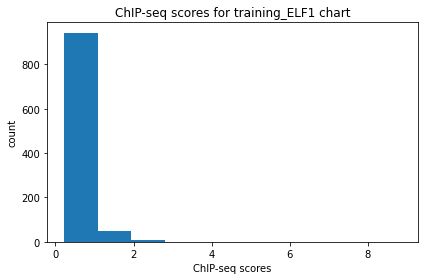

In [68]:
# loading training data for TF ELF1
Y_train_ELF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train.bed")
Y_trainlabel_ELF1 = Chiseqscore_to_label(Y_train_ELF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train.bed", TF_name ="ELF1", datatype = "training")
matrix_tensor_files_train_ELF1, matrix_length_arr_train_ELF1, dict_matrix_train_ELF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ELF1/")
X_train_seq_all_tensor_train_ELF1, X_train_seq_tensor_train_ELF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train-sequence.fa", matrix_length_arr_train_ELF1, matrix_tensor_files_train_ELF1)
backgound_seq_all_tensor_train_ELF1 = background_convolution_seq(matrix_length_arr_train_ELF1, X_train_seq_tensor_train_ELF1, matrix_tensor_files_train_ELF1)
X_train_seq_all_tensor_noisefree_train_ELF1 = log_pwm_background(X_train_seq_all_tensor_train_ELF1, backgound_seq_all_tensor_train_ELF1)
X_train_max_train_ELF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ELF1)
X_train_flatten_train_ELF1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_ELF1)

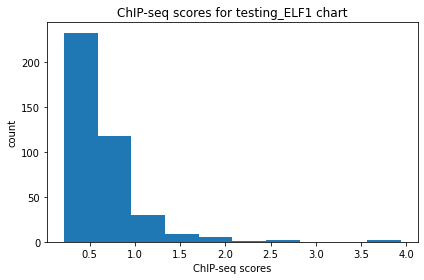

In [69]:
# loading testing data for TF ELF1
Y_test_ELF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test.bed")
Y_testlabel_ELF1 = Chiseqscore_to_label(Y_test_ELF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test.bed", TF_name ="ELF1", datatype = "testing")
matrix_tensor_files_test_ELF1, matrix_length_arr_test_ELF1, dict_matrix_test_ELF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ELF1/")
X_test_seq_all_tensor_test_ELF1, X_test_seq_tensor_test_ELF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test-sequence.fa", matrix_length_arr_test_ELF1, matrix_tensor_files_test_ELF1)
backgound_seq_all_tensor_test_ELF1 = background_convolution_seq(matrix_length_arr_test_ELF1, X_test_seq_tensor_test_ELF1, matrix_tensor_files_test_ELF1)
X_test_seq_all_tensor_noisefree_test_ELF1 = log_pwm_background(X_test_seq_all_tensor_test_ELF1, backgound_seq_all_tensor_test_ELF1)
X_test_max_test_ELF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ELF1)
X_test_flatten_test_ELF1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_ELF1)

In [70]:
clf_test = SVC(random_state=42)
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_ELF1, Y_trainlabel_ELF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_ELF1, Y_trainlabel_ELF1)
# Prediction on X_test_max_test_ELF1
y_maxpred_test_ELF1 = clf_train_max.predict(X_test_max_test_ELF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ELF1, y_maxpred_test_ELF1))
# X_train_flatten_train_TFname training 
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_ELF1, Y_trainlabel_ELF1)
# Prediction on X_test_flatten_test_ELF1
y_flattenpred_test_ELF1 = clf_train_flatten.predict(X_test_flatten_test_ELF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ELF1, y_flattenpred_test_ELF1))

0.741
Accuracy: 0.73
Accuracy: 0.7025


In [71]:
clf_test = SVC(C = 0.05, random_state=42)
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_ELF1, Y_trainlabel_ELF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_ELF1, Y_trainlabel_ELF1)


# Prediction on X_test_max_test_ELF1
y_maxpred_test_ELF1 = clf_train_max.predict(X_test_max_test_ELF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ELF1, y_maxpred_test_ELF1))



# X_train_flatten_train_TFname training 
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
clf_train_flatten = SVC(C = 0.05, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_ELF1, Y_trainlabel_ELF1)
# Prediction on X_test_flatten_test_ELF1
y_flattenpred_test_ELF1 = clf_train_flatten.predict(X_test_flatten_test_ELF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ELF1, y_flattenpred_test_ELF1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_ELF1) 
metrics.accuracy_score(Y_trainlabel_ELF1, y_train_max_pred)

0.7230000000000001
Accuracy: 0.745
Accuracy: 0.69


0.769

In [73]:
print(dict_matrix_train_ELF1)
# print(matrix_tensor_files_train_ELF1[3])
# print(matrix_tensor_files_train_ELF1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_ELF1[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'ELF1_HOCO_A.wtmx': 0, 'ELF1_GM12878_2.wtmx': 1, 'ELF1_GM12878_5.wtmx': 2, 'ELF1_GM12878_3.wtmx': 3, 'ELF1_GM12878_4.wtmx': 4, 'ELF1_GM12878_1.wtmx': 5, 'ELF1_FB_1.wtmx': 6}
(7, 21, 4)


In [74]:
one_wtmx = np.tile(matrix_tensor_files_train_ELF1[0],(7, 1,1))
# loading training data for TF ELF1
Y_train_ELF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train.bed")
Y_trainlabel_ELF1 = Chiseqscore_to_label(Y_train_ELF1)

X_train_seq_all_tensor_train_ELF1, X_train_seq_tensor_train_ELF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-train-sequence.fa", matrix_length_arr_train_ELF1, one_wtmx)
backgound_seq_all_tensor_train_ELF1 = background_convolution_seq(matrix_length_arr_train_ELF1, X_train_seq_tensor_train_ELF1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_ELF1 = log_pwm_background(X_train_seq_all_tensor_train_ELF1, backgound_seq_all_tensor_train_ELF1)
X_train_max_train_ELF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ELF1)

# loading testing data for TF ELF1
Y_test_ELF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test.bed")
Y_testlabel_ELF1 = Chiseqscore_to_label(Y_test_ELF1)

X_test_seq_all_tensor_test_ELF1, X_test_seq_tensor_test_ELF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ELF1/ELF1-test-sequence.fa", matrix_length_arr_test_ELF1, one_wtmx)
backgound_seq_all_tensor_test_ELF1 = background_convolution_seq(matrix_length_arr_test_ELF1, X_test_seq_tensor_test_ELF1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_ELF1 = log_pwm_background(X_test_seq_all_tensor_test_ELF1, backgound_seq_all_tensor_test_ELF1)
X_test_max_test_ELF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ELF1)

# X_train_max_train_TFname training 
Y_trainlabel_ELF1 = Y_trainlabel_ELF1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_ELF1, Y_trainlabel_ELF1)
# Prediction on X_test_max_test_ELF1
y_maxpred_test_ELF1 = clf_train_max.predict(X_test_max_test_ELF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ELF1, y_maxpred_test_ELF1))

Accuracy: 0.6575


In [76]:
# print(X_test_seq_all_tensor_noisefree_test_ELF1.shape)
# print(X_test_seq_all_tensor_noisefree_test_ELF1)
# print(X_train_seq_all_tensor_noisefree_train_ELF1.shape)
# print(X_train_seq_all_tensor_noisefree_train_ELF1)

### **TF: IKZF1** 



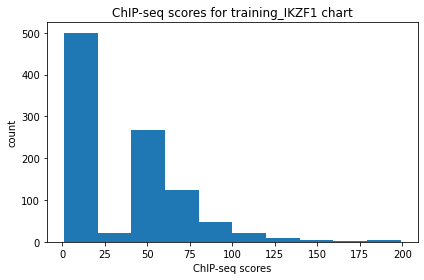

one-hot encoding violation 108


In [83]:
# loading training data for TF IKZF1
Y_train_IKZF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train.bed")
Y_trainlabel_IKZF1 = Chiseqscore_to_label(Y_train_IKZF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train.bed", TF_name ="IKZF1", datatype = "training")
matrix_tensor_files_train_IKZF1, matrix_length_arr_train_IKZF1, dict_matrix_train_IKZF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/IKZF1/")
X_train_seq_all_tensor_train_IKZF1, X_train_seq_tensor_train_IKZF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train-sequence.fa", matrix_length_arr_train_IKZF1, matrix_tensor_files_train_IKZF1)
backgound_seq_all_tensor_train_IKZF1 = background_convolution_seq(matrix_length_arr_train_IKZF1, X_train_seq_tensor_train_IKZF1, matrix_tensor_files_train_IKZF1)
X_train_seq_all_tensor_noisefree_train_IKZF1 = log_pwm_background(X_train_seq_all_tensor_train_IKZF1, backgound_seq_all_tensor_train_IKZF1)
X_train_max_train_IKZF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_IKZF1)
X_train_flatten_train_IKZF1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_IKZF1)

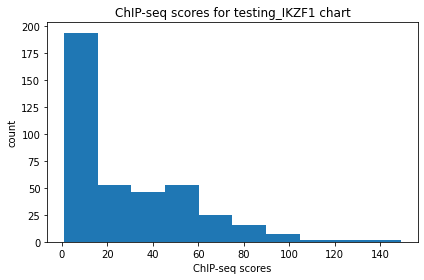

In [78]:
# loading testing data for TF IKZF1
Y_test_IKZF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test.bed")
Y_testlabel_IKZF1 = Chiseqscore_to_label(Y_test_IKZF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test.bed", TF_name ="IKZF1", datatype = "testing")
matrix_tensor_files_test_IKZF1, matrix_length_arr_test_IKZF1, dict_matrix_test_IKZF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/IKZF1/")
X_test_seq_all_tensor_test_IKZF1, X_test_seq_tensor_test_IKZF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test-sequence.fa", matrix_length_arr_test_IKZF1, matrix_tensor_files_test_IKZF1)
backgound_seq_all_tensor_test_IKZF1 = background_convolution_seq(matrix_length_arr_test_IKZF1, X_test_seq_tensor_test_IKZF1, matrix_tensor_files_test_IKZF1)
X_test_seq_all_tensor_noisefree_test_IKZF1 = log_pwm_background(X_test_seq_all_tensor_test_IKZF1, backgound_seq_all_tensor_test_IKZF1)
X_test_max_test_IKZF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_IKZF1)
X_test_flatten_test_IKZF1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_IKZF1)

In [ ]:
clf_test = SVC(random_state=42)
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_IKZF1, Y_trainlabel_IKZF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_IKZF1, Y_trainlabel_IKZF1)
# Prediction on X_test_max_test_IKZF1
y_maxpred_test_IKZF1 = clf_train_max.predict(X_test_max_test_IKZF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_IKZF1, y_maxpred_test_IKZF1))
# X_train_flatten_train_TFname training 
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_IKZF1, Y_trainlabel_IKZF1)
# Prediction on X_test_flatten_test_IKZF1
y_flattenpred_test_IKZF1 = clf_train_flatten.predict(X_test_flatten_test_IKZF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_IKZF1, y_flattenpred_test_IKZF1))

0.5786060606060606
Accuracy: 0.5475
Accuracy: 0.6525


In [ ]:
Y_trainlabel_IKZF1 = label_cleaning(Y_trainlabel_IKZF1, violation_index_list = [108])

In [95]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_IKZF1, Y_trainlabel_IKZF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_IKZF1, Y_trainlabel_IKZF1)


# Prediction on X_test_max_test_IKZF1
y_maxpred_test_IKZF1 = clf_train_max.predict(X_test_max_test_IKZF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_IKZF1, y_maxpred_test_IKZF1))



# X_train_flatten_train_TFname training 
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_IKZF1, Y_trainlabel_IKZF1)
# Prediction on X_test_flatten_test_IKZF1
y_flattenpred_test_IKZF1 = clf_train_flatten.predict(X_test_flatten_test_IKZF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_IKZF1, y_flattenpred_test_IKZF1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_IKZF1) 
metrics.accuracy_score(Y_trainlabel_IKZF1, y_train_max_pred)

0.5035353535353535
Accuracy: 0.4975
Accuracy: 0.4975


0.5005005005005005

In [97]:
print(dict_matrix_train_IKZF1)
# print(matrix_tensor_files_train_IKZF1[3])
# print(matrix_tensor_files_train_IKZF1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_IKZF1[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'IKZF1_GM12878_3.wtmx': 0, 'IKZF1_GM12878_4.wtmx': 1, 'IKZF1_GM12878_2.wtmx': 2, 'IKZF1_GM12878_1.wtmx': 3, 'IKZF1_GM12878_5.wtmx': 4, 'IKZF1_HOCO_C.wtmx': 5}
(6, 21, 4)


In [100]:
one_wtmx = np.tile(matrix_tensor_files_train_IKZF1[0],(6, 1,1))
# loading training data for TF IKZF1
Y_train_IKZF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train.bed")
Y_trainlabel_IKZF1 = Chiseqscore_to_label(Y_train_IKZF1)

X_train_seq_all_tensor_train_IKZF1, X_train_seq_tensor_train_IKZF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-train-sequence.fa", matrix_length_arr_train_IKZF1, one_wtmx)
backgound_seq_all_tensor_train_IKZF1 = background_convolution_seq(matrix_length_arr_train_IKZF1, X_train_seq_tensor_train_IKZF1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_IKZF1 = log_pwm_background(X_train_seq_all_tensor_train_IKZF1, backgound_seq_all_tensor_train_IKZF1)
X_train_max_train_IKZF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_IKZF1)

# loading testing data for TF IKZF1
Y_test_IKZF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test.bed")
Y_testlabel_IKZF1 = Chiseqscore_to_label(Y_test_IKZF1)

X_test_seq_all_tensor_test_IKZF1, X_test_seq_tensor_test_IKZF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/IKZF1/IKZF1-test-sequence.fa", matrix_length_arr_test_IKZF1, one_wtmx)
backgound_seq_all_tensor_test_IKZF1 = background_convolution_seq(matrix_length_arr_test_IKZF1, X_test_seq_tensor_test_IKZF1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_IKZF1 = log_pwm_background(X_test_seq_all_tensor_test_IKZF1, backgound_seq_all_tensor_test_IKZF1)
X_test_max_test_IKZF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_IKZF1)

Y_trainlabel_IKZF1 = label_cleaning(Y_trainlabel_IKZF1, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_IKZF1 = Y_trainlabel_IKZF1.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_IKZF1, Y_trainlabel_IKZF1)
# Prediction on X_test_max_test_IKZF1
y_maxpred_test_IKZF1 = clf_train_max.predict(X_test_max_test_IKZF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_IKZF1, y_maxpred_test_IKZF1))

one-hot encoding violation 108
Accuracy: 0.4975


In [102]:
# print(X_test_seq_all_tensor_noisefree_test_IKZF1.shape)
# print(X_test_seq_all_tensor_noisefree_test_IKZF1)
# print(X_train_seq_all_tensor_noisefree_train_IKZF1.shape)
# print(X_train_seq_all_tensor_noisefree_train_IKZF1)

### **TF: MAX** 



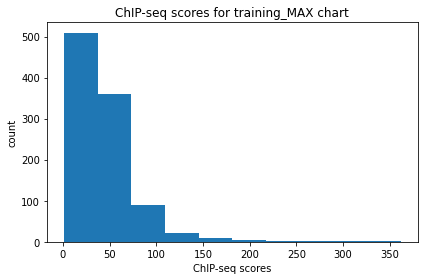

In [103]:
# loading training data for TF MAX
Y_train_MAX = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train.bed")
Y_trainlabel_MAX = Chiseqscore_to_label(Y_train_MAX)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train.bed", TF_name ="MAX", datatype = "training")
matrix_tensor_files_train_MAX, matrix_length_arr_train_MAX, dict_matrix_train_MAX  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MAX/")
X_train_seq_all_tensor_train_MAX, X_train_seq_tensor_train_MAX = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train-sequence.fa", matrix_length_arr_train_MAX, matrix_tensor_files_train_MAX)
backgound_seq_all_tensor_train_MAX = background_convolution_seq(matrix_length_arr_train_MAX, X_train_seq_tensor_train_MAX, matrix_tensor_files_train_MAX)
X_train_seq_all_tensor_noisefree_train_MAX = log_pwm_background(X_train_seq_all_tensor_train_MAX, backgound_seq_all_tensor_train_MAX)
X_train_max_train_MAX = X_max_generator(X_train_seq_all_tensor_noisefree_train_MAX)
X_train_flatten_train_MAX = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_MAX)

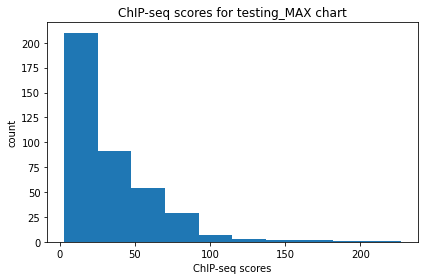

In [104]:
# loading testing data for TF MAX
Y_test_MAX = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test.bed")
Y_testlabel_MAX = Chiseqscore_to_label(Y_test_MAX)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test.bed", TF_name ="MAX", datatype = "testing")
matrix_tensor_files_test_MAX, matrix_length_arr_test_MAX, dict_matrix_test_MAX  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MAX/")
X_test_seq_all_tensor_test_MAX, X_test_seq_tensor_test_MAX = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test-sequence.fa", matrix_length_arr_test_MAX, matrix_tensor_files_test_MAX)
backgound_seq_all_tensor_test_MAX = background_convolution_seq(matrix_length_arr_test_MAX, X_test_seq_tensor_test_MAX, matrix_tensor_files_test_MAX)
X_test_seq_all_tensor_noisefree_test_MAX = log_pwm_background(X_test_seq_all_tensor_test_MAX, backgound_seq_all_tensor_test_MAX)
X_test_max_test_MAX = X_max_generator(X_test_seq_all_tensor_noisefree_test_MAX)
X_test_flatten_test_MAX = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_MAX)

In [ ]:
# Y_trainlabel_MAX = label_cleaning(Y_trainlabel_MAX, violation_index_list = [108])
clf_test = SVC(random_state=42)
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_MAX, Y_trainlabel_MAX, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_MAX, Y_trainlabel_MAX)
# Prediction on X_test_max_test_MAX
y_maxpred_test_MAX = clf_train_max.predict(X_test_max_test_MAX)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MAX, y_maxpred_test_MAX))
# X_train_flatten_train_TFname training 
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
clf_train_flatten = SVC(random_state=42)
clf_train_flatten.fit(X_train_flatten_train_MAX, Y_trainlabel_MAX)
# Prediction on X_test_flatten_test_MAX
y_flattenpred_test_MAX = clf_train_flatten.predict(X_test_flatten_test_MAX)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MAX, y_flattenpred_test_MAX))

0.772
Accuracy: 0.75
Accuracy: 0.73


In [ ]:
# Y_trainlabel_MAX = label_cleaning(Y_trainlabel_MAX, violation_index_list = [108])

In [107]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_MAX, Y_trainlabel_MAX, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_MAX, Y_trainlabel_MAX)


# Prediction on X_test_max_test_MAX
y_maxpred_test_MAX = clf_train_max.predict(X_test_max_test_MAX)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MAX, y_maxpred_test_MAX))



# X_train_flatten_train_TFname training 
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_MAX, Y_trainlabel_MAX)
# Prediction on X_test_flatten_test_MAX
y_flattenpred_test_MAX = clf_train_flatten.predict(X_test_flatten_test_MAX)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MAX, y_flattenpred_test_MAX))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_MAX) 
metrics.accuracy_score(Y_trainlabel_MAX, y_train_max_pred)

0.7659999999999999
Accuracy: 0.7275
Accuracy: 0.73


0.801

In [109]:
print(dict_matrix_train_MAX)
# print(matrix_tensor_files_train_MAX[3])
# print(matrix_tensor_files_train_MAX[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_MAX[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'MAX_GM12878_5.wtmx': 0, 'MAX_FB_1.wtmx': 1, 'MAX_GM12878_1.wtmx': 2, 'MAX_GM12878_4.wtmx': 3, 'MAX_GM12878_3.wtmx': 4, 'MAX_HOCO_A.wtmx': 5, 'MAX_GM12878_2.wtmx': 6}
(7, 20, 4)


In [113]:
one_wtmx = np.tile(matrix_tensor_files_train_MAX[5],(7, 1,1))
# loading training data for TF MAX
Y_train_MAX = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train.bed")
Y_trainlabel_MAX = Chiseqscore_to_label(Y_train_MAX)

X_train_seq_all_tensor_train_MAX, X_train_seq_tensor_train_MAX = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-train-sequence.fa", matrix_length_arr_train_MAX, one_wtmx)
backgound_seq_all_tensor_train_MAX = background_convolution_seq(matrix_length_arr_train_MAX, X_train_seq_tensor_train_MAX, one_wtmx)
X_train_seq_all_tensor_noisefree_train_MAX = log_pwm_background(X_train_seq_all_tensor_train_MAX, backgound_seq_all_tensor_train_MAX)
X_train_max_train_MAX = X_max_generator(X_train_seq_all_tensor_noisefree_train_MAX)

# loading testing data for TF MAX
Y_test_MAX = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test.bed")
Y_testlabel_MAX = Chiseqscore_to_label(Y_test_MAX)

X_test_seq_all_tensor_test_MAX, X_test_seq_tensor_test_MAX = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MAX/MAX-test-sequence.fa", matrix_length_arr_test_MAX, one_wtmx)
backgound_seq_all_tensor_test_MAX = background_convolution_seq(matrix_length_arr_test_MAX, X_test_seq_tensor_test_MAX, one_wtmx)
X_test_seq_all_tensor_noisefree_test_MAX = log_pwm_background(X_test_seq_all_tensor_test_MAX, backgound_seq_all_tensor_test_MAX)
X_test_max_test_MAX = X_max_generator(X_test_seq_all_tensor_noisefree_test_MAX)

# Y_trainlabel_MAX = label_cleaning(Y_trainlabel_MAX, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_MAX = Y_trainlabel_MAX.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_MAX, Y_trainlabel_MAX)
# Prediction on X_test_max_test_MAX
y_maxpred_test_MAX = clf_train_max.predict(X_test_max_test_MAX)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MAX, y_maxpred_test_MAX))

Accuracy: 0.73


In [115]:
# print(X_test_seq_all_tensor_noisefree_test_MAX.shape)
# print(X_test_seq_all_tensor_noisefree_test_MAX)
# print(X_train_seq_all_tensor_noisefree_train_MAX.shape)
# print(X_train_seq_all_tensor_noisefree_train_MAX)

### **TF: MEF2A** 



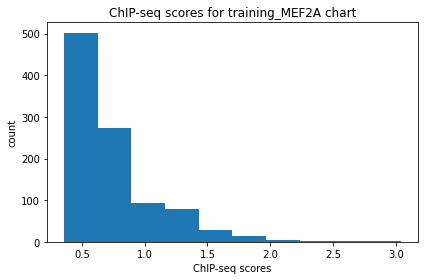

In [116]:
# loading training data for TF MEF2A
Y_train_MEF2A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train.bed")
Y_trainlabel_MEF2A = Chiseqscore_to_label(Y_train_MEF2A)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train.bed", TF_name ="MEF2A", datatype = "training")
matrix_tensor_files_train_MEF2A, matrix_length_arr_train_MEF2A, dict_matrix_train_MEF2A  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MEF2A/")
X_train_seq_all_tensor_train_MEF2A, X_train_seq_tensor_train_MEF2A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train-sequence.fa", matrix_length_arr_train_MEF2A, matrix_tensor_files_train_MEF2A)
backgound_seq_all_tensor_train_MEF2A = background_convolution_seq(matrix_length_arr_train_MEF2A, X_train_seq_tensor_train_MEF2A, matrix_tensor_files_train_MEF2A)
X_train_seq_all_tensor_noisefree_train_MEF2A = log_pwm_background(X_train_seq_all_tensor_train_MEF2A, backgound_seq_all_tensor_train_MEF2A)
X_train_MEF2A_train_MEF2A = X_max_generator(X_train_seq_all_tensor_noisefree_train_MEF2A)
X_train_flatten_train_MEF2A = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_MEF2A)

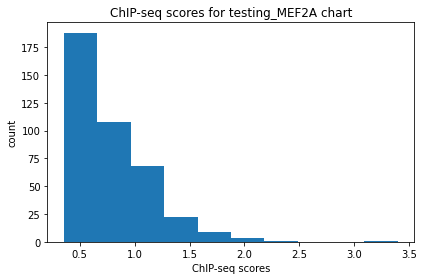

In [117]:
# loading testing data for TF MEF2A
Y_test_MEF2A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test.bed")
Y_testlabel_MEF2A = Chiseqscore_to_label(Y_test_MEF2A)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test.bed", TF_name ="MEF2A", datatype = "testing")
matrix_tensor_files_test_MEF2A, matrix_length_arr_test_MEF2A, dict_matrix_test_MEF2A  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MEF2A/")
X_test_seq_all_tensor_test_MEF2A, X_test_seq_tensor_test_MEF2A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test-sequence.fa", matrix_length_arr_test_MEF2A, matrix_tensor_files_test_MEF2A)
backgound_seq_all_tensor_test_MEF2A = background_convolution_seq(matrix_length_arr_test_MEF2A, X_test_seq_tensor_test_MEF2A, matrix_tensor_files_test_MEF2A)
X_test_seq_all_tensor_noisefree_test_MEF2A = log_pwm_background(X_test_seq_all_tensor_test_MEF2A, backgound_seq_all_tensor_test_MEF2A)
X_test_MEF2A_test_MEF2A = X_max_generator(X_test_seq_all_tensor_noisefree_test_MEF2A)
X_test_flatten_test_MEF2A = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_MEF2A)

In [118]:
# Y_trainlabel_MEF2A = label_cleaning(Y_trainlabel_MEF2A, violation_index_list = [108])

In [120]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_MEF2A = Y_trainlabel_MEF2A.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_MEF2A_train_MEF2A, Y_trainlabel_MEF2A, cv=10)
print(scores_test.mean())
# X_train_MEF2A_train_TFname training 
Y_trainlabel_MEF2A = Y_trainlabel_MEF2A.reshape(-1)
clf_train_MEF2A = SVC(C = 0.1, random_state=42)
clf_train_MEF2A.fit(X_train_MEF2A_train_MEF2A, Y_trainlabel_MEF2A)


# Prediction on X_test_MEF2A_test_MEF2A
y_MEF2Apred_test_MEF2A = clf_train_MEF2A.predict(X_test_MEF2A_test_MEF2A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MEF2A, y_MEF2Apred_test_MEF2A))



# X_train_flatten_train_TFname training 
Y_trainlabel_MEF2A = Y_trainlabel_MEF2A.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_MEF2A, Y_trainlabel_MEF2A)
# Prediction on X_test_flatten_test_MEF2A
y_flattenpred_test_MEF2A = clf_train_flatten.predict(X_test_flatten_test_MEF2A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MEF2A, y_flattenpred_test_MEF2A))


#training accuracy for MEF2A-pooling
y_train_MEF2A_pred = clf_train_MEF2A.predict(X_train_MEF2A_train_MEF2A) 
metrics.accuracy_score(Y_trainlabel_MEF2A, y_train_MEF2A_pred)

0.659
Accuracy: 0.6525
Accuracy: 0.6725


0.798

In [122]:
print(dict_matrix_train_MEF2A)
# print(matrix_tensor_files_train_MEF2A[3])
# print(matrix_tensor_files_train_MEF2A[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_MEF2A[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'MEF2A_GM12878_3.wtmx': 0, 'MEF2A_GM12878_2.wtmx': 1, 'MEF2A_FB_1.wtmx': 2, 'MEF2A_GM12878_4.wtmx': 3, 'MEF2A_GM12878_5.wtmx': 4, 'MEF2A_HOCO_A.wtmx': 5, 'MEF2A_GM12878_1.wtmx': 6}
(7, 15, 4)


In [125]:
one_wtmx = np.tile(matrix_tensor_files_train_MEF2A[1],(7, 1,1))
# loading training data for TF MEF2A
Y_train_MEF2A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train.bed")
Y_trainlabel_MEF2A = Chiseqscore_to_label(Y_train_MEF2A)

X_train_seq_all_tensor_train_MEF2A, X_train_seq_tensor_train_MEF2A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-train-sequence.fa", matrix_length_arr_train_MEF2A, one_wtmx)
backgound_seq_all_tensor_train_MEF2A = background_convolution_seq(matrix_length_arr_train_MEF2A, X_train_seq_tensor_train_MEF2A, one_wtmx)
X_train_seq_all_tensor_noisefree_train_MEF2A = log_pwm_background(X_train_seq_all_tensor_train_MEF2A, backgound_seq_all_tensor_train_MEF2A)
X_train_MEF2A_train_MEF2A = X_max_generator(X_train_seq_all_tensor_noisefree_train_MEF2A)

# loading testing data for TF MEF2A
Y_test_MEF2A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test.bed")
Y_testlabel_MEF2A = Chiseqscore_to_label(Y_test_MEF2A)

X_test_seq_all_tensor_test_MEF2A, X_test_seq_tensor_test_MEF2A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MEF2A/MEF2A-test-sequence.fa", matrix_length_arr_test_MEF2A, one_wtmx)
backgound_seq_all_tensor_test_MEF2A = background_convolution_seq(matrix_length_arr_test_MEF2A, X_test_seq_tensor_test_MEF2A, one_wtmx)
X_test_seq_all_tensor_noisefree_test_MEF2A = log_pwm_background(X_test_seq_all_tensor_test_MEF2A, backgound_seq_all_tensor_test_MEF2A)
X_test_MEF2A_test_MEF2A = X_max_generator(X_test_seq_all_tensor_noisefree_test_MEF2A)

# Y_trainlabel_MEF2A = label_cleaning(Y_trainlabel_MEF2A, violation_index_list = [108])

# X_train_MEF2A_train_TFname training 
Y_trainlabel_MEF2A = Y_trainlabel_MEF2A.reshape(-1)
clf_train_MEF2A = SVC(C = 0.1, random_state=42)
clf_train_MEF2A.fit(X_train_MEF2A_train_MEF2A, Y_trainlabel_MEF2A)
# Prediction on X_test_MEF2A_test_MEF2A
y_MEF2Apred_test_MEF2A = clf_train_MEF2A.predict(X_test_MEF2A_test_MEF2A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MEF2A, y_MEF2Apred_test_MEF2A))

Accuracy: 0.6025


In [136]:
# print(X_test_seq_all_tensor_noisefree_test_MEF2A.shape)
# # print(X_test_seq_all_tensor_noisefree_test_MEF2A)
# print(X_train_seq_all_tensor_noisefree_train_MEF2A.shape)
# print(X_train_seq_all_tensor_noisefree_train_MEF2A)

### **TF: MXI1** 



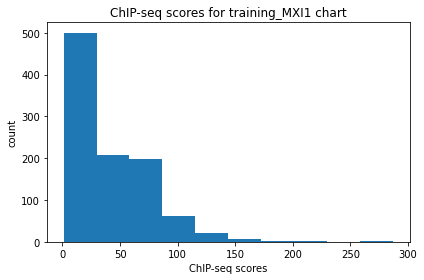

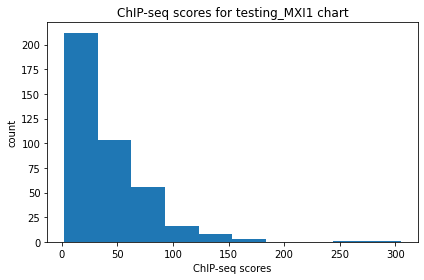

In [126]:
# loading training data for TF MXI1
Y_train_MXI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train.bed")
Y_trainlabel_MXI1 = Chiseqscore_to_label(Y_train_MXI1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train.bed", TF_name ="MXI1", datatype = "training")
matrix_tensor_files_train_MXI1, matrix_length_arr_train_MXI1, dict_matrix_train_MXI1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MXI1/")
X_train_seq_all_tensor_train_MXI1, X_train_seq_tensor_train_MXI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train-sequence.fa", matrix_length_arr_train_MXI1, matrix_tensor_files_train_MXI1)
backgound_seq_all_tensor_train_MXI1 = background_convolution_seq(matrix_length_arr_train_MXI1, X_train_seq_tensor_train_MXI1, matrix_tensor_files_train_MXI1)
X_train_seq_all_tensor_noisefree_train_MXI1 = log_pwm_background(X_train_seq_all_tensor_train_MXI1, backgound_seq_all_tensor_train_MXI1)
X_train_MXI1_train_MXI1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_MXI1)
X_train_flatten_train_MXI1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_MXI1)

# loading testing data for TF MXI1
Y_test_MXI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test.bed")
Y_testlabel_MXI1 = Chiseqscore_to_label(Y_test_MXI1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test.bed", TF_name ="MXI1", datatype = "testing")
matrix_tensor_files_test_MXI1, matrix_length_arr_test_MXI1, dict_matrix_test_MXI1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/MXI1/")
X_test_seq_all_tensor_test_MXI1, X_test_seq_tensor_test_MXI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test-sequence.fa", matrix_length_arr_test_MXI1, matrix_tensor_files_test_MXI1)
backgound_seq_all_tensor_test_MXI1 = background_convolution_seq(matrix_length_arr_test_MXI1, X_test_seq_tensor_test_MXI1, matrix_tensor_files_test_MXI1)
X_test_seq_all_tensor_noisefree_test_MXI1 = log_pwm_background(X_test_seq_all_tensor_test_MXI1, backgound_seq_all_tensor_test_MXI1)
X_test_MXI1_test_MXI1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_MXI1)
X_test_flatten_test_MXI1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_MXI1)

In [127]:
# Y_trainlabel_MXI1 = label_cleaning(Y_trainlabel_MXI1, violation_index_list = [108])

In [129]:

clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_MXI1 = Y_trainlabel_MXI1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_MXI1_train_MXI1, Y_trainlabel_MXI1, cv=10)
print(scores_test.mean())
# X_train_MXI1_train_TFname training 
Y_trainlabel_MXI1 = Y_trainlabel_MXI1.reshape(-1)
clf_train_MXI1 = SVC(C = 0.1, random_state=42)
clf_train_MXI1.fit(X_train_MXI1_train_MXI1, Y_trainlabel_MXI1)


# Prediction on X_test_MXI1_test_MXI1
y_MXI1pred_test_MXI1 = clf_train_MXI1.predict(X_test_MXI1_test_MXI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MXI1, y_MXI1pred_test_MXI1))



# X_train_flatten_train_TFname training 
Y_trainlabel_MXI1 = Y_trainlabel_MXI1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_MXI1, Y_trainlabel_MXI1)
# Prediction on X_test_flatten_test_MXI1
y_flattenpred_test_MXI1 = clf_train_flatten.predict(X_test_flatten_test_MXI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MXI1, y_flattenpred_test_MXI1))


#training accuracy for MXI1-pooling
y_train_MXI1_pred = clf_train_MXI1.predict(X_train_MXI1_train_MXI1) 
metrics.accuracy_score(Y_trainlabel_MXI1, y_train_MXI1_pred)

0.663
Accuracy: 0.6525
Accuracy: 0.6525


0.712

In [131]:
print(dict_matrix_train_MXI1)
# print(matrix_tensor_files_train_MXI1[3])
# print(matrix_tensor_files_train_MXI1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_MXI1[4],(5, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'MXI1_GM12878_4.wtmx': 0, 'MXI1_GM12878_1.wtmx': 1, 'MXI1_GM12878_5.wtmx': 2, 'MXI1_GM12878_3.wtmx': 3, 'MXI1_GM12878_2.wtmx': 4}
(5, 20, 4)


In [132]:
one_wtmx = np.tile(matrix_tensor_files_train_MXI1[1],(5, 1,1))
# loading training data for TF MXI1
Y_train_MXI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train.bed")
Y_trainlabel_MXI1 = Chiseqscore_to_label(Y_train_MXI1)

X_train_seq_all_tensor_train_MXI1, X_train_seq_tensor_train_MXI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-train-sequence.fa", matrix_length_arr_train_MXI1, one_wtmx)
backgound_seq_all_tensor_train_MXI1 = background_convolution_seq(matrix_length_arr_train_MXI1, X_train_seq_tensor_train_MXI1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_MXI1 = log_pwm_background(X_train_seq_all_tensor_train_MXI1, backgound_seq_all_tensor_train_MXI1)
X_train_MXI1_train_MXI1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_MXI1)

# loading testing data for TF MXI1
Y_test_MXI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test.bed")
Y_testlabel_MXI1 = Chiseqscore_to_label(Y_test_MXI1)

X_test_seq_all_tensor_test_MXI1, X_test_seq_tensor_test_MXI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/MXI1/MXI1-test-sequence.fa", matrix_length_arr_test_MXI1, one_wtmx)
backgound_seq_all_tensor_test_MXI1 = background_convolution_seq(matrix_length_arr_test_MXI1, X_test_seq_tensor_test_MXI1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_MXI1 = log_pwm_background(X_test_seq_all_tensor_test_MXI1, backgound_seq_all_tensor_test_MXI1)
X_test_MXI1_test_MXI1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_MXI1)

# Y_trainlabel_MXI1 = label_cleaning(Y_trainlabel_MXI1, violation_index_list = [108])

# X_train_MXI1_train_TFname training 
Y_trainlabel_MXI1 = Y_trainlabel_MXI1.reshape(-1)
clf_train_MXI1 = SVC(C = 0.1, random_state=42)
clf_train_MXI1.fit(X_train_MXI1_train_MXI1, Y_trainlabel_MXI1)
# Prediction on X_test_MXI1_test_MXI1
y_MXI1pred_test_MXI1 = clf_train_MXI1.predict(X_test_MXI1_test_MXI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_MXI1, y_MXI1pred_test_MXI1))

Accuracy: 0.64


In [138]:
# print(X_test_seq_all_tensor_noisefree_test_MXI1.shape)
# print(X_test_seq_all_tensor_noisefree_test_MXI1)
# print(X_train_seq_all_tensor_noisefree_train_MXI1.shape)
# print(X_train_seq_all_tensor_noisefree_train_MXI1)

### **TF: NFATC1** 



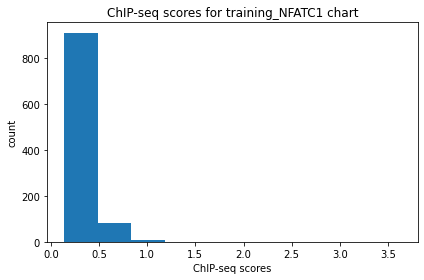

one-hot encoding violation 369
one-hot encoding violation 974


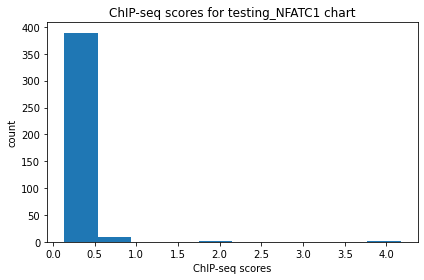

In [139]:
# loading training data for TF NFATC1
Y_train_NFATC1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train.bed")
Y_trainlabel_NFATC1 = Chiseqscore_to_label(Y_train_NFATC1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train.bed", TF_name ="NFATC1", datatype = "training")
matrix_tensor_files_train_NFATC1, matrix_length_arr_train_NFATC1, dict_matrix_train_NFATC1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFATC1/")
X_train_seq_all_tensor_train_NFATC1, X_train_seq_tensor_train_NFATC1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train-sequence.fa", matrix_length_arr_train_NFATC1, matrix_tensor_files_train_NFATC1)
backgound_seq_all_tensor_train_NFATC1 = background_convolution_seq(matrix_length_arr_train_NFATC1, X_train_seq_tensor_train_NFATC1, matrix_tensor_files_train_NFATC1)
X_train_seq_all_tensor_noisefree_train_NFATC1 = log_pwm_background(X_train_seq_all_tensor_train_NFATC1, backgound_seq_all_tensor_train_NFATC1)
X_train_NFATC1_train_NFATC1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFATC1)
X_train_flatten_train_NFATC1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_NFATC1)

# loading testing data for TF NFATC1
Y_test_NFATC1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test.bed")
Y_testlabel_NFATC1 = Chiseqscore_to_label(Y_test_NFATC1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test.bed", TF_name ="NFATC1", datatype = "testing")
matrix_tensor_files_test_NFATC1, matrix_length_arr_test_NFATC1, dict_matrix_test_NFATC1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFATC1/")
X_test_seq_all_tensor_test_NFATC1, X_test_seq_tensor_test_NFATC1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test-sequence.fa", matrix_length_arr_test_NFATC1, matrix_tensor_files_test_NFATC1)
backgound_seq_all_tensor_test_NFATC1 = background_convolution_seq(matrix_length_arr_test_NFATC1, X_test_seq_tensor_test_NFATC1, matrix_tensor_files_test_NFATC1)
X_test_seq_all_tensor_noisefree_test_NFATC1 = log_pwm_background(X_test_seq_all_tensor_test_NFATC1, backgound_seq_all_tensor_test_NFATC1)
X_test_NFATC1_test_NFATC1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFATC1)
X_test_flatten_test_NFATC1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_NFATC1)

In [140]:
Y_trainlabel_NFATC1 = label_cleaning(Y_trainlabel_NFATC1, violation_index_list = [369,974])

In [142]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_NFATC1 = Y_trainlabel_NFATC1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_NFATC1_train_NFATC1, Y_trainlabel_NFATC1, cv=10)
print(scores_test.mean())
# X_train_NFATC1_train_TFname training 
Y_trainlabel_NFATC1 = Y_trainlabel_NFATC1.reshape(-1)
clf_train_NFATC1 = SVC(C = 0.1, random_state=42)
clf_train_NFATC1.fit(X_train_NFATC1_train_NFATC1, Y_trainlabel_NFATC1)


# Prediction on X_test_NFATC1_test_NFATC1
y_NFATC1pred_test_NFATC1 = clf_train_NFATC1.predict(X_test_NFATC1_test_NFATC1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFATC1, y_NFATC1pred_test_NFATC1))



# X_train_flatten_train_TFname training 
Y_trainlabel_NFATC1 = Y_trainlabel_NFATC1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_NFATC1, Y_trainlabel_NFATC1)
# Prediction on X_test_flatten_test_NFATC1
y_flattenpred_test_NFATC1 = clf_train_flatten.predict(X_test_flatten_test_NFATC1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFATC1, y_flattenpred_test_NFATC1))


#training accuracy for NFATC1-pooling
y_train_NFATC1_pred = clf_train_NFATC1.predict(X_train_NFATC1_train_NFATC1) 
metrics.accuracy_score(Y_trainlabel_NFATC1, y_train_NFATC1_pred)

0.7054141414141414
Accuracy: 0.645
Accuracy: 0.65


0.7144288577154309

In [144]:
print(dict_matrix_train_NFATC1)
# print(matrix_tensor_files_train_NFATC1[3])
# print(matrix_tensor_files_train_NFATC1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_NFATC1[4],(5, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'NFATC1_GM12878_2.wtmx': 0, 'NFATC1_GM12878_1.wtmx': 1, 'NFATC1_GM12878_4.wtmx': 2, 'NFATC1_GM12878_5.wtmx': 3, 'NFATC1_GM12878_3.wtmx': 4}
(5, 24, 4)


In [145]:
one_wtmx = np.tile(matrix_tensor_files_train_NFATC1[1],(5, 1,1))
# loading training data for TF NFATC1
Y_train_NFATC1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train.bed")
Y_trainlabel_NFATC1 = Chiseqscore_to_label(Y_train_NFATC1)

X_train_seq_all_tensor_train_NFATC1, X_train_seq_tensor_train_NFATC1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-train-sequence.fa", matrix_length_arr_train_NFATC1, one_wtmx)
backgound_seq_all_tensor_train_NFATC1 = background_convolution_seq(matrix_length_arr_train_NFATC1, X_train_seq_tensor_train_NFATC1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_NFATC1 = log_pwm_background(X_train_seq_all_tensor_train_NFATC1, backgound_seq_all_tensor_train_NFATC1)
X_train_NFATC1_train_NFATC1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFATC1)

# loading testing data for TF NFATC1
Y_test_NFATC1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test.bed")
Y_testlabel_NFATC1 = Chiseqscore_to_label(Y_test_NFATC1)

X_test_seq_all_tensor_test_NFATC1, X_test_seq_tensor_test_NFATC1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFATC1/NFATC1-test-sequence.fa", matrix_length_arr_test_NFATC1, one_wtmx)
backgound_seq_all_tensor_test_NFATC1 = background_convolution_seq(matrix_length_arr_test_NFATC1, X_test_seq_tensor_test_NFATC1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_NFATC1 = log_pwm_background(X_test_seq_all_tensor_test_NFATC1, backgound_seq_all_tensor_test_NFATC1)
X_test_NFATC1_test_NFATC1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFATC1)

Y_trainlabel_NFATC1 = label_cleaning(Y_trainlabel_NFATC1, violation_index_list = [369,974])

# X_train_NFATC1_train_TFname training 
Y_trainlabel_NFATC1 = Y_trainlabel_NFATC1.reshape(-1)
clf_train_NFATC1 = SVC(C = 0.1, random_state=42)
clf_train_NFATC1.fit(X_train_NFATC1_train_NFATC1, Y_trainlabel_NFATC1)
# Prediction on X_test_NFATC1_test_NFATC1
y_NFATC1pred_test_NFATC1 = clf_train_NFATC1.predict(X_test_NFATC1_test_NFATC1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFATC1, y_NFATC1pred_test_NFATC1))

one-hot encoding violation 369
one-hot encoding violation 974
Accuracy: 0.555


In [150]:
# print(X_test_seq_all_tensor_noisefree_test_NFATC1.shape)
# print(X_test_seq_all_tensor_noisefree_test_NFATC1)
# print(X_train_seq_all_tensor_noisefree_train_NFATC1.shape)
# print(X_train_seq_all_tensor_noisefree_train_NFATC1)

### **TF: NFIC** 



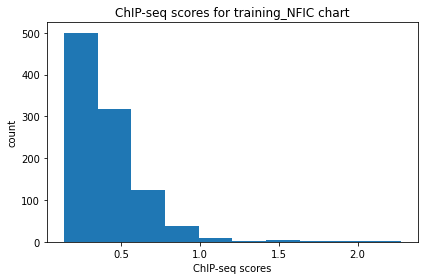

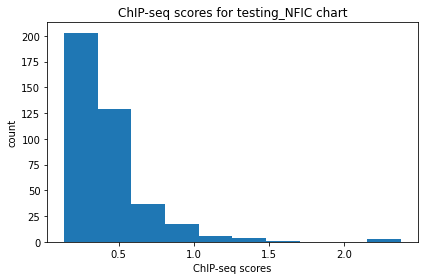

one-hot encoding violation 69


In [151]:
# loading training data for TF NFIC
Y_train_NFIC = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train.bed")
Y_trainlabel_NFIC = Chiseqscore_to_label(Y_train_NFIC)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train.bed", TF_name ="NFIC", datatype = "training")
matrix_tensor_files_train_NFIC, matrix_length_arr_train_NFIC, dict_matrix_train_NFIC  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFIC/")
X_train_seq_all_tensor_train_NFIC, X_train_seq_tensor_train_NFIC = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train-sequence.fa", matrix_length_arr_train_NFIC, matrix_tensor_files_train_NFIC)
backgound_seq_all_tensor_train_NFIC = background_convolution_seq(matrix_length_arr_train_NFIC, X_train_seq_tensor_train_NFIC, matrix_tensor_files_train_NFIC)
X_train_seq_all_tensor_noisefree_train_NFIC = log_pwm_background(X_train_seq_all_tensor_train_NFIC, backgound_seq_all_tensor_train_NFIC)
X_train_NFIC_train_NFIC = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFIC)
X_train_flatten_train_NFIC = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_NFIC)

# loading testing data for TF NFIC
Y_test_NFIC = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test.bed")
Y_testlabel_NFIC = Chiseqscore_to_label(Y_test_NFIC)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test.bed", TF_name ="NFIC", datatype = "testing")
matrix_tensor_files_test_NFIC, matrix_length_arr_test_NFIC, dict_matrix_test_NFIC  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFIC/")
X_test_seq_all_tensor_test_NFIC, X_test_seq_tensor_test_NFIC = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test-sequence.fa", matrix_length_arr_test_NFIC, matrix_tensor_files_test_NFIC)
backgound_seq_all_tensor_test_NFIC = background_convolution_seq(matrix_length_arr_test_NFIC, X_test_seq_tensor_test_NFIC, matrix_tensor_files_test_NFIC)
X_test_seq_all_tensor_noisefree_test_NFIC = log_pwm_background(X_test_seq_all_tensor_test_NFIC, backgound_seq_all_tensor_test_NFIC)
X_test_NFIC_test_NFIC = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFIC)
X_test_flatten_test_NFIC = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_NFIC)

In [152]:
Y_testlabel_NFIC = label_cleaning(Y_testlabel_NFIC, violation_index_list = [69])

In [154]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_NFIC = Y_trainlabel_NFIC.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_NFIC_train_NFIC, Y_trainlabel_NFIC, cv=10)
print(scores_test.mean())
# X_train_NFIC_train_TFname training 
Y_trainlabel_NFIC = Y_trainlabel_NFIC.reshape(-1)
clf_train_NFIC = SVC(C = 0.1, random_state=42)
clf_train_NFIC.fit(X_train_NFIC_train_NFIC, Y_trainlabel_NFIC)


# Prediction on X_test_NFIC_test_NFIC
y_NFICpred_test_NFIC = clf_train_NFIC.predict(X_test_NFIC_test_NFIC)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFIC, y_NFICpred_test_NFIC))



# X_train_flatten_train_TFname training 
Y_trainlabel_NFIC = Y_trainlabel_NFIC.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_NFIC, Y_trainlabel_NFIC)
# Prediction on X_test_flatten_test_NFIC
y_flattenpred_test_NFIC = clf_train_flatten.predict(X_test_flatten_test_NFIC)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFIC, y_flattenpred_test_NFIC))


#training accuracy for NFIC-pooling
y_train_NFIC_pred = clf_train_NFIC.predict(X_train_NFIC_train_NFIC) 
metrics.accuracy_score(Y_trainlabel_NFIC, y_train_NFIC_pred)

0.5509999999999999
Accuracy: 0.5037593984962406
Accuracy: 0.6741854636591479


0.664

In [164]:
# # X_train_NFIC_train_TFname training 
# Y_trainlabel_NFIC = Y_trainlabel_NFIC.reshape(-1)
# clf_train_NFIC = SVC(C = 10,random_state=42)
# clf_train_NFIC.fit(X_train_NFIC_train_NFIC, Y_trainlabel_NFIC)


# # Prediction on X_test_NFIC_test_NFIC
# y_NFICpred_test_NFIC = clf_train_NFIC.predict(X_test_NFIC_test_NFIC)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFIC, y_NFICpred_test_NFIC))

Accuracy: 0.606516290726817


In [156]:
print(dict_matrix_train_NFIC)
# print(matrix_tensor_files_train_NFIC[3])
# print(matrix_tensor_files_train_NFIC[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_NFIC[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'NFIC_GM12878_5.wtmx': 0, 'NFIC_GM12878_2.wtmx': 1, 'NFIC_HOCO_A.wtmx': 2, 'NFIC_GM12878_1.wtmx': 3, 'NFIC_FB_1.wtmx': 4, 'NFIC_GM12878_3.wtmx': 5, 'NFIC_GM12878_4.wtmx': 6}
(7, 21, 4)


In [165]:
one_wtmx = np.tile(matrix_tensor_files_train_NFIC[0],(7, 1,1))
# loading training data for TF NFIC
Y_train_NFIC = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train.bed")
Y_trainlabel_NFIC = Chiseqscore_to_label(Y_train_NFIC)

X_train_seq_all_tensor_train_NFIC, X_train_seq_tensor_train_NFIC = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-train-sequence.fa", matrix_length_arr_train_NFIC, one_wtmx)
backgound_seq_all_tensor_train_NFIC = background_convolution_seq(matrix_length_arr_train_NFIC, X_train_seq_tensor_train_NFIC, one_wtmx)
X_train_seq_all_tensor_noisefree_train_NFIC = log_pwm_background(X_train_seq_all_tensor_train_NFIC, backgound_seq_all_tensor_train_NFIC)
X_train_NFIC_train_NFIC = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFIC)

# loading testing data for TF NFIC
Y_test_NFIC = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test.bed")
Y_testlabel_NFIC = Chiseqscore_to_label(Y_test_NFIC)

X_test_seq_all_tensor_test_NFIC, X_test_seq_tensor_test_NFIC = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFIC/NFIC-test-sequence.fa", matrix_length_arr_test_NFIC, one_wtmx)
backgound_seq_all_tensor_test_NFIC = background_convolution_seq(matrix_length_arr_test_NFIC, X_test_seq_tensor_test_NFIC, one_wtmx)
X_test_seq_all_tensor_noisefree_test_NFIC = log_pwm_background(X_test_seq_all_tensor_test_NFIC, backgound_seq_all_tensor_test_NFIC)
X_test_NFIC_test_NFIC = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFIC)

# Y_trainlabel_NFIC = label_cleaning(Y_trainlabel_NFIC, violation_index_list = [369,974])
Y_testlabel_NFIC = label_cleaning(Y_testlabel_NFIC, violation_index_list = [69])

# X_train_NFIC_train_TFname training 
Y_trainlabel_NFIC = Y_trainlabel_NFIC.reshape(-1)
clf_train_NFIC = SVC(C = 0.1, random_state=42)
clf_train_NFIC.fit(X_train_NFIC_train_NFIC, Y_trainlabel_NFIC)
# Prediction on X_test_NFIC_test_NFIC
y_NFICpred_test_NFIC = clf_train_NFIC.predict(X_test_NFIC_test_NFIC)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFIC, y_NFICpred_test_NFIC))

one-hot encoding violation 69
Accuracy: 0.6491228070175439


In [159]:
# print(X_test_seq_all_tensor_noisefree_test_NFIC.shape)
# print(X_test_seq_all_tensor_noisefree_test_NFIC)
# print(X_train_seq_all_tensor_noisefree_train_NFIC.shape)
# print(X_train_seq_all_tensor_noisefree_train_NFIC)

### **TF: NFYB** 



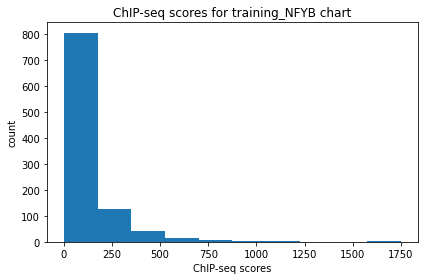

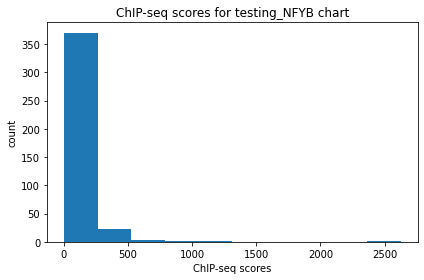

In [166]:
# loading training data for TF NFYB
Y_train_NFYB = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train.bed")
Y_trainlabel_NFYB = Chiseqscore_to_label(Y_train_NFYB)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train.bed", TF_name ="NFYB", datatype = "training")
matrix_tensor_files_train_NFYB, matrix_length_arr_train_NFYB, dict_matrix_train_NFYB  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFYB/")
X_train_seq_all_tensor_train_NFYB, X_train_seq_tensor_train_NFYB = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train-sequence.fa", matrix_length_arr_train_NFYB, matrix_tensor_files_train_NFYB)
backgound_seq_all_tensor_train_NFYB = background_convolution_seq(matrix_length_arr_train_NFYB, X_train_seq_tensor_train_NFYB, matrix_tensor_files_train_NFYB)
X_train_seq_all_tensor_noisefree_train_NFYB = log_pwm_background(X_train_seq_all_tensor_train_NFYB, backgound_seq_all_tensor_train_NFYB)
X_train_NFYB_train_NFYB = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFYB)
X_train_flatten_train_NFYB = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_NFYB)

# loading testing data for TF NFYB
Y_test_NFYB = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test.bed")
Y_testlabel_NFYB = Chiseqscore_to_label(Y_test_NFYB)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test.bed", TF_name ="NFYB", datatype = "testing")
matrix_tensor_files_test_NFYB, matrix_length_arr_test_NFYB, dict_matrix_test_NFYB  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/NFYB/")
X_test_seq_all_tensor_test_NFYB, X_test_seq_tensor_test_NFYB = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test-sequence.fa", matrix_length_arr_test_NFYB, matrix_tensor_files_test_NFYB)
backgound_seq_all_tensor_test_NFYB = background_convolution_seq(matrix_length_arr_test_NFYB, X_test_seq_tensor_test_NFYB, matrix_tensor_files_test_NFYB)
X_test_seq_all_tensor_noisefree_test_NFYB = log_pwm_background(X_test_seq_all_tensor_test_NFYB, backgound_seq_all_tensor_test_NFYB)
X_test_NFYB_test_NFYB = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFYB)
X_test_flatten_test_NFYB = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_NFYB)

In [167]:
# Y_testlabel_NFIC = label_cleaning(Y_testlabel_NFIC, violation_index_list = [69])

In [171]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_NFYB = Y_trainlabel_NFYB.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_NFYB_train_NFYB, Y_trainlabel_NFYB, cv=10)
print(scores_test.mean())
# X_train_NFYB_train_TFname training 
Y_trainlabel_NFYB = Y_trainlabel_NFYB.reshape(-1)
clf_train_NFYB = SVC(C = 0.1, random_state=42)
clf_train_NFYB.fit(X_train_NFYB_train_NFYB, Y_trainlabel_NFYB)


# Prediction on X_test_NFYB_test_NFYB
y_NFYBpred_test_NFYB = clf_train_NFYB.predict(X_test_NFYB_test_NFYB)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFYB, y_NFYBpred_test_NFYB))



# X_train_flatten_train_TFname training 
Y_trainlabel_NFYB = Y_trainlabel_NFYB.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_NFYB, Y_trainlabel_NFYB)
# Prediction on X_test_flatten_test_NFYB
y_flattenpred_test_NFYB = clf_train_flatten.predict(X_test_flatten_test_NFYB)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFYB, y_flattenpred_test_NFYB))


#training accuracy for max-pooling
y_train_NFYB_pred = clf_train_NFYB.predict(X_train_NFYB_train_NFYB) 
metrics.accuracy_score(Y_trainlabel_NFYB, y_train_NFYB_pred)

0.6100000000000001
Accuracy: 0.605
Accuracy: 0.5275


0.74

In [173]:
print(dict_matrix_train_NFYB)
# print(matrix_tensor_files_train_NFYB[3])
# print(matrix_tensor_files_train_NFYB[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_NFYB[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'NFYB_FB_1.wtmx': 0, 'NFYB_GM12878_5.wtmx': 1, 'NFYB_GM12878_2.wtmx': 2, 'NFYB_HOCO_A.wtmx': 3, 'NFYB_GM12878_4.wtmx': 4, 'NFYB_GM12878_1.wtmx': 5, 'NFYB_GM12878_3.wtmx': 6}
(7, 30, 4)


In [174]:
one_wtmx = np.tile(matrix_tensor_files_train_NFYB[0],(7, 1,1))
# loading training data for TF NFYB
Y_train_NFYB = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train.bed")
Y_trainlabel_NFYB = Chiseqscore_to_label(Y_train_NFYB)

X_train_seq_all_tensor_train_NFYB, X_train_seq_tensor_train_NFYB = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-train-sequence.fa", matrix_length_arr_train_NFYB, one_wtmx)
backgound_seq_all_tensor_train_NFYB = background_convolution_seq(matrix_length_arr_train_NFYB, X_train_seq_tensor_train_NFYB, one_wtmx)
X_train_seq_all_tensor_noisefree_train_NFYB = log_pwm_background(X_train_seq_all_tensor_train_NFYB, backgound_seq_all_tensor_train_NFYB)
X_train_NFYB_train_NFYB = X_max_generator(X_train_seq_all_tensor_noisefree_train_NFYB)

# loading testing data for TF NFYB
Y_test_NFYB = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test.bed")
Y_testlabel_NFYB = Chiseqscore_to_label(Y_test_NFYB)

X_test_seq_all_tensor_test_NFYB, X_test_seq_tensor_test_NFYB = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/NFYB/NFYB-test-sequence.fa", matrix_length_arr_test_NFYB, one_wtmx)
backgound_seq_all_tensor_test_NFYB = background_convolution_seq(matrix_length_arr_test_NFYB, X_test_seq_tensor_test_NFYB, one_wtmx)
X_test_seq_all_tensor_noisefree_test_NFYB = log_pwm_background(X_test_seq_all_tensor_test_NFYB, backgound_seq_all_tensor_test_NFYB)
X_test_NFYB_test_NFYB = X_max_generator(X_test_seq_all_tensor_noisefree_test_NFYB)

# Y_trainlabel_NFYB = label_cleaning(Y_trainlabel_NFYB, violation_index_list = [369,974])
# Y_testlabel_NFYB = label_cleaning(Y_testlabel_NFYB, violation_index_list = [69])

# X_train_NFYB_train_TFname training 
Y_trainlabel_NFYB = Y_trainlabel_NFYB.reshape(-1)
clf_train_NFYB = SVC(C = 0.1, random_state=42)
clf_train_NFYB.fit(X_train_NFYB_train_NFYB, Y_trainlabel_NFYB)
# Prediction on X_test_NFYB_test_NFYB
y_NFYBpred_test_NFYB = clf_train_NFYB.predict(X_test_NFYB_test_NFYB)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_NFYB, y_NFYBpred_test_NFYB))

Accuracy: 0.565


In [176]:
# print(X_test_seq_all_tensor_noisefree_test_NFYB.shape)
# print(X_test_seq_all_tensor_noisefree_test_NFYB)
# print(X_train_seq_all_tensor_noisefree_train_NFYB.shape)
# print(X_train_seq_all_tensor_noisefree_train_NFYB)

### **TF: PAX5** 



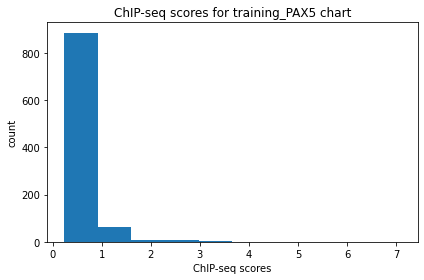

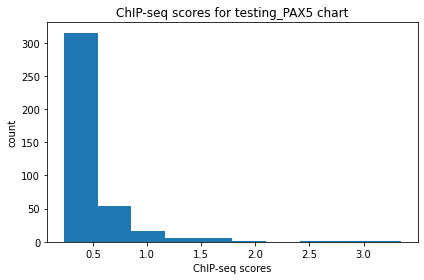

In [177]:
# loading training data for TF PAX5
Y_train_PAX5 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train.bed")
Y_trainlabel_PAX5 = Chiseqscore_to_label(Y_train_PAX5)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train.bed", TF_name ="PAX5", datatype = "training")
matrix_tensor_files_train_PAX5, matrix_length_arr_train_PAX5, dict_matrix_train_PAX5  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/PAX5/")
X_train_seq_all_tensor_train_PAX5, X_train_seq_tensor_train_PAX5 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train-sequence.fa", matrix_length_arr_train_PAX5, matrix_tensor_files_train_PAX5)
backgound_seq_all_tensor_train_PAX5 = background_convolution_seq(matrix_length_arr_train_PAX5, X_train_seq_tensor_train_PAX5, matrix_tensor_files_train_PAX5)
X_train_seq_all_tensor_noisefree_train_PAX5 = log_pwm_background(X_train_seq_all_tensor_train_PAX5, backgound_seq_all_tensor_train_PAX5)
X_train_PAX5_train_PAX5 = X_max_generator(X_train_seq_all_tensor_noisefree_train_PAX5)
X_train_flatten_train_PAX5 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_PAX5)

# loading testing data for TF PAX5
Y_test_PAX5 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test.bed")
Y_testlabel_PAX5 = Chiseqscore_to_label(Y_test_PAX5)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test.bed", TF_name ="PAX5", datatype = "testing")
matrix_tensor_files_test_PAX5, matrix_length_arr_test_PAX5, dict_matrix_test_PAX5  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/PAX5/")
X_test_seq_all_tensor_test_PAX5, X_test_seq_tensor_test_PAX5 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test-sequence.fa", matrix_length_arr_test_PAX5, matrix_tensor_files_test_PAX5)
backgound_seq_all_tensor_test_PAX5 = background_convolution_seq(matrix_length_arr_test_PAX5, X_test_seq_tensor_test_PAX5, matrix_tensor_files_test_PAX5)
X_test_seq_all_tensor_noisefree_test_PAX5 = log_pwm_background(X_test_seq_all_tensor_test_PAX5, backgound_seq_all_tensor_test_PAX5)
X_test_PAX5_test_PAX5 = X_max_generator(X_test_seq_all_tensor_noisefree_test_PAX5)
X_test_flatten_test_PAX5 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_PAX5)

In [ ]:
# Y_testlabel_NFIC = label_cleaning(Y_testlabel_NFIC, violation_index_list = [69])

In [186]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_PAX5 = Y_trainlabel_PAX5.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_PAX5_train_PAX5, Y_trainlabel_PAX5, cv=10)
print(scores_test.mean())
# X_train_PAX5_train_TFname training 
Y_trainlabel_PAX5 = Y_trainlabel_PAX5.reshape(-1)
clf_train_PAX5 = SVC(C = 0., random_state=42)
clf_train_PAX5.fit(X_train_PAX5_train_PAX5, Y_trainlabel_PAX5)


# Prediction on X_test_PAX5_test_PAX5
y_PAX5pred_test_PAX5 = clf_train_PAX5.predict(X_test_PAX5_test_PAX5)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_PAX5, y_PAX5pred_test_PAX5))



# X_train_flatten_train_TFname training 
Y_trainlabel_PAX5 = Y_trainlabel_PAX5.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_PAX5, Y_trainlabel_PAX5)
# Prediction on X_test_flatten_test_PAX5
y_flattenpred_test_PAX5 = clf_train_flatten.predict(X_test_flatten_test_PAX5)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_PAX5, y_flattenpred_test_PAX5))


#training accuracy for max-pooling
y_train_PAX5_pred = clf_train_PAX5.predict(X_train_PAX5_train_PAX5) 
metrics.accuracy_score(Y_trainlabel_PAX5, y_train_PAX5_pred)

0.541698883161512
Accuracy: 0.5325
Accuracy: 0.545


0.9130434782608695

In [188]:
print(dict_matrix_train_PAX5)
# print(matrix_tensor_files_train_PAX5[3])
# print(matrix_tensor_files_train_PAX5[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_PAX5[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'PAX5_GM12878_4.wtmx': 0, 'PAX5_GM12878_3.wtmx': 1, 'PAX5_HOCO_A.wtmx': 2, 'PAX5_GM12878_1.wtmx': 3, 'PAX5_GM12878_2.wtmx': 4, 'PAX5_GM12878_5.wtmx': 5, 'PAX5_HOCO_S.wtmx': 6}
(7, 21, 4)


In [189]:
one_wtmx = np.tile(matrix_tensor_files_train_PAX5[0],(7, 1,1))
# loading training data for TF PAX5
Y_train_PAX5 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train.bed")
Y_trainlabel_PAX5 = Chiseqscore_to_label(Y_train_PAX5)

X_train_seq_all_tensor_train_PAX5, X_train_seq_tensor_train_PAX5 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-train-sequence.fa", matrix_length_arr_train_PAX5, one_wtmx)
backgound_seq_all_tensor_train_PAX5 = background_convolution_seq(matrix_length_arr_train_PAX5, X_train_seq_tensor_train_PAX5, one_wtmx)
X_train_seq_all_tensor_noisefree_train_PAX5 = log_pwm_background(X_train_seq_all_tensor_train_PAX5, backgound_seq_all_tensor_train_PAX5)
X_train_PAX5_train_PAX5 = X_max_generator(X_train_seq_all_tensor_noisefree_train_PAX5)

# loading testing data for TF PAX5
Y_test_PAX5 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test.bed")
Y_testlabel_PAX5 = Chiseqscore_to_label(Y_test_PAX5)

X_test_seq_all_tensor_test_PAX5, X_test_seq_tensor_test_PAX5 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/PAX5/PAX5-test-sequence.fa", matrix_length_arr_test_PAX5, one_wtmx)
backgound_seq_all_tensor_test_PAX5 = background_convolution_seq(matrix_length_arr_test_PAX5, X_test_seq_tensor_test_PAX5, one_wtmx)
X_test_seq_all_tensor_noisefree_test_PAX5 = log_pwm_background(X_test_seq_all_tensor_test_PAX5, backgound_seq_all_tensor_test_PAX5)
X_test_PAX5_test_PAX5 = X_max_generator(X_test_seq_all_tensor_noisefree_test_PAX5)

# Y_trainlabel_PAX5 = label_cleaning(Y_trainlabel_PAX5, violation_index_list = [369,974])
# Y_testlabel_PAX5 = label_cleaning(Y_testlabel_PAX5, violation_index_list = [69])

# X_train_PAX5_train_TFname training 
Y_trainlabel_PAX5 = Y_trainlabel_PAX5.reshape(-1)
clf_train_PAX5 = SVC(C = 0.1, random_state=42)
clf_train_PAX5.fit(X_train_PAX5_train_PAX5, Y_trainlabel_PAX5)
# Prediction on X_test_PAX5_test_PAX5
y_PAX5pred_test_PAX5 = clf_train_PAX5.predict(X_test_PAX5_test_PAX5)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_PAX5, y_PAX5pred_test_PAX5))

Accuracy: 0.5


In [191]:
# print(X_test_seq_all_tensor_noisefree_test_PAX5.shape)
# print(X_test_seq_all_tensor_noisefree_test_PAX5)
# print(X_train_seq_all_tensor_noisefree_train_PAX5.shape)
# print(X_train_seq_all_tensor_noisefree_train_PAX5)

### **TF: RELA** 



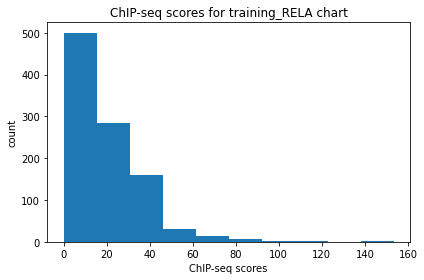

one-hot encoding violation 512


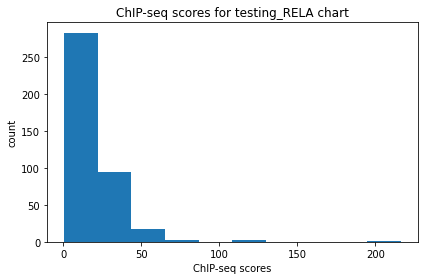

In [198]:
# loading training data for TF RELA
Y_train_RELA = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train.bed")
Y_trainlabel_RELA = Chiseqscore_to_label(Y_train_RELA)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train.bed", TF_name ="RELA", datatype = "training")
matrix_tensor_files_train_RELA, matrix_length_arr_train_RELA, dict_matrix_train_RELA  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/RELA/")
X_train_seq_all_tensor_train_RELA, X_train_seq_tensor_train_RELA = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train-sequence.fa", matrix_length_arr_train_RELA, matrix_tensor_files_train_RELA)
backgound_seq_all_tensor_train_RELA = background_convolution_seq(matrix_length_arr_train_RELA, X_train_seq_tensor_train_RELA, matrix_tensor_files_train_RELA)
X_train_seq_all_tensor_noisefree_train_RELA = log_pwm_background(X_train_seq_all_tensor_train_RELA, backgound_seq_all_tensor_train_RELA)
X_train_RELA_train_RELA = X_max_generator(X_train_seq_all_tensor_noisefree_train_RELA)
X_train_flatten_train_RELA = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_RELA)

# loading testing data for TF RELA
Y_test_RELA = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test.bed")
Y_testlabel_RELA = Chiseqscore_to_label(Y_test_RELA)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test.bed", TF_name ="RELA", datatype = "testing")
matrix_tensor_files_test_RELA, matrix_length_arr_test_RELA, dict_matrix_test_RELA  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/RELA/")
X_test_seq_all_tensor_test_RELA, X_test_seq_tensor_test_RELA = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test-sequence.fa", matrix_length_arr_test_RELA, matrix_tensor_files_test_RELA)
backgound_seq_all_tensor_test_RELA = background_convolution_seq(matrix_length_arr_test_RELA, X_test_seq_tensor_test_RELA, matrix_tensor_files_test_RELA)
X_test_seq_all_tensor_noisefree_test_RELA = log_pwm_background(X_test_seq_all_tensor_test_RELA, backgound_seq_all_tensor_test_RELA)
X_test_RELA_test_RELA = X_max_generator(X_test_seq_all_tensor_noisefree_test_RELA)
X_test_flatten_test_RELA = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_RELA)

In [199]:
Y_trainlabel_RELA = label_cleaning(Y_trainlabel_RELA, violation_index_list = [512])

In [204]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_RELA = Y_trainlabel_RELA.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_RELA_train_RELA, Y_trainlabel_RELA, cv=10)
print(scores_test.mean())
# X_train_RELA_train_TFname training 
Y_trainlabel_RELA = Y_trainlabel_RELA.reshape(-1)
clf_train_RELA = SVC(C=0.1, random_state=42)
clf_train_RELA.fit(X_train_RELA_train_RELA, Y_trainlabel_RELA)


# Prediction on X_test_RELA_test_RELA
y_RELApred_test_RELA = clf_train_RELA.predict(X_test_RELA_test_RELA)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RELA, y_RELApred_test_RELA))



# X_train_flatten_train_TFname training 
Y_trainlabel_RELA = Y_trainlabel_RELA.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_RELA, Y_trainlabel_RELA)
# Prediction on X_test_flatten_test_RELA
y_flattenpred_test_RELA = clf_train_flatten.predict(X_test_flatten_test_RELA)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RELA, y_flattenpred_test_RELA))


#training accuracy for max-pooling
y_train_RELA_pred = clf_train_RELA.predict(X_train_RELA_train_RELA) 
metrics.accuracy_score(Y_trainlabel_RELA, y_train_RELA_pred)

0.5237373737373737
Accuracy: 0.5025
Accuracy: 0.5


0.5125125125125125

In [206]:
print(dict_matrix_train_RELA)
# print(matrix_tensor_files_train_RELA[3])
# print(matrix_tensor_files_train_RELA[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_RELA[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'RELA_GM12878_3.wtmx': 0, 'RELA_GM12878_4.wtmx': 1, 'RELA_FB_1.wtmx': 2, 'RELA_GM12878_5.wtmx': 3, 'RELA_GM12878_1.wtmx': 4, 'RELA_GM12878_2.wtmx': 5}
(6, 30, 4)


In [208]:
one_wtmx = np.tile(matrix_tensor_files_train_RELA[0],(6, 1,1))
# loading training data for TF RELA
Y_train_RELA = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train.bed")
Y_trainlabel_RELA = Chiseqscore_to_label(Y_train_RELA)

X_train_seq_all_tensor_train_RELA, X_train_seq_tensor_train_RELA = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-train-sequence.fa", matrix_length_arr_train_RELA, one_wtmx)
backgound_seq_all_tensor_train_RELA = background_convolution_seq(matrix_length_arr_train_RELA, X_train_seq_tensor_train_RELA, one_wtmx)
X_train_seq_all_tensor_noisefree_train_RELA = log_pwm_background(X_train_seq_all_tensor_train_RELA, backgound_seq_all_tensor_train_RELA)
X_train_RELA_train_RELA = X_max_generator(X_train_seq_all_tensor_noisefree_train_RELA)

# loading testing data for TF RELA
Y_test_RELA = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test.bed")
Y_testlabel_RELA = Chiseqscore_to_label(Y_test_RELA)

X_test_seq_all_tensor_test_RELA, X_test_seq_tensor_test_RELA = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RELA/RELA-test-sequence.fa", matrix_length_arr_test_RELA, one_wtmx)
backgound_seq_all_tensor_test_RELA = background_convolution_seq(matrix_length_arr_test_RELA, X_test_seq_tensor_test_RELA, one_wtmx)
X_test_seq_all_tensor_noisefree_test_RELA = log_pwm_background(X_test_seq_all_tensor_test_RELA, backgound_seq_all_tensor_test_RELA)
X_test_RELA_test_RELA = X_max_generator(X_test_seq_all_tensor_noisefree_test_RELA)

Y_trainlabel_RELA = label_cleaning(Y_trainlabel_RELA, violation_index_list = [512])
# Y_testlabel_RELA = label_cleaning(Y_testlabel_RELA, violation_index_list = [69])

# X_train_RELA_train_TFname training 
Y_trainlabel_RELA = Y_trainlabel_RELA.reshape(-1)
clf_train_RELA = SVC(C = 0.1, random_state=42)
clf_train_RELA.fit(X_train_RELA_train_RELA, Y_trainlabel_RELA)
# Prediction on X_test_RELA_test_RELA
y_RELApred_test_RELA = clf_train_RELA.predict(X_test_RELA_test_RELA)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RELA, y_RELApred_test_RELA))

one-hot encoding violation 512
Accuracy: 0.5


In [ ]:
# print(X_test_seq_all_tensor_noisefree_test_RELA.shape)
# print(X_test_seq_all_tensor_noisefree_test_RELA)
# print(X_train_seq_all_tensor_noisefree_train_RELA.shape)
# print(X_train_seq_all_tensor_noisefree_train_RELA)

### **TF: REST** 



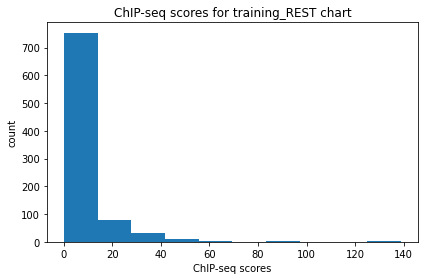

one-hot encoding violation 769


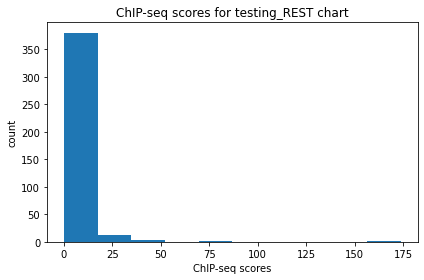

In [209]:
# loading training data for TF REST
Y_train_REST = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/REST/REST-train.bed")
Y_trainlabel_REST = Chiseqscore_to_label(Y_train_REST)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/REST/REST-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/REST/REST-train.bed", TF_name ="REST", datatype = "training")
matrix_tensor_files_train_REST, matrix_length_arr_train_REST, dict_matrix_train_REST  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/REST/")
X_train_seq_all_tensor_train_REST, X_train_seq_tensor_train_REST = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/REST/REST-train-sequence.fa", matrix_length_arr_train_REST, matrix_tensor_files_train_REST)
backgound_seq_all_tensor_train_REST = background_convolution_seq(matrix_length_arr_train_REST, X_train_seq_tensor_train_REST, matrix_tensor_files_train_REST)
X_train_seq_all_tensor_noisefree_train_REST = log_pwm_background(X_train_seq_all_tensor_train_REST, backgound_seq_all_tensor_train_REST)
X_train_REST_train_REST = X_max_generator(X_train_seq_all_tensor_noisefree_train_REST)
X_train_flatten_train_REST = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_REST)

# loading testing data for TF REST
Y_test_REST = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/REST/REST-test.bed")
Y_testlabel_REST = Chiseqscore_to_label(Y_test_REST)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/REST/REST-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/REST/REST-test.bed", TF_name ="REST", datatype = "testing")
matrix_tensor_files_test_REST, matrix_length_arr_test_REST, dict_matrix_test_REST  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/REST/")
X_test_seq_all_tensor_test_REST, X_test_seq_tensor_test_REST = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/REST/REST-test-sequence.fa", matrix_length_arr_test_REST, matrix_tensor_files_test_REST)
backgound_seq_all_tensor_test_REST = background_convolution_seq(matrix_length_arr_test_REST, X_test_seq_tensor_test_REST, matrix_tensor_files_test_REST)
X_test_seq_all_tensor_noisefree_test_REST = log_pwm_background(X_test_seq_all_tensor_test_REST, backgound_seq_all_tensor_test_REST)
X_test_REST_test_REST = X_max_generator(X_test_seq_all_tensor_noisefree_test_REST)
X_test_flatten_test_REST = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_REST)

In [210]:
Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [216]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_REST = Y_trainlabel_REST.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_REST_train_REST, Y_trainlabel_REST, cv=10)
print(scores_test.mean())
# X_train_REST_train_TFname training 
Y_trainlabel_REST = Y_trainlabel_REST.reshape(-1)
clf_train_REST = SVC(C = 0.05, random_state=42)
clf_train_REST.fit(X_train_REST_train_REST, Y_trainlabel_REST)


# Prediction on X_test_REST_test_REST
y_RESTpred_test_REST = clf_train_REST.predict(X_test_REST_test_REST)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_REST, y_RESTpred_test_REST))



# X_train_flatten_train_TFname training 
Y_trainlabel_REST = Y_trainlabel_REST.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_REST, Y_trainlabel_REST)
# Prediction on X_test_flatten_test_REST
y_flattenpred_test_REST = clf_train_flatten.predict(X_test_flatten_test_REST)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_REST, y_flattenpred_test_REST))


#training accuracy for max-pooling
y_train_REST_pred = clf_train_REST.predict(X_train_REST_train_REST) 
metrics.accuracy_score(Y_trainlabel_REST, y_train_REST_pred)

0.649284984678243
Accuracy: 0.5375
Accuracy: 0.575


0.5278093076049943

In [219]:
print(dict_matrix_train_REST)
# print(matrix_tensor_files_train_REST[3])
# print(matrix_tensor_files_train_REST[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_REST[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'REST_GM12878_4.wtmx': 0, 'REST_GM12878_5.wtmx': 1, 'REST_GM12878_1.wtmx': 2, 'REST_FB_1.wtmx': 3, 'REST_HOCO_A.wtmx': 4, 'REST_GM12878_2.wtmx': 5, 'REST_GM12878_3.wtmx': 6}
(7, 30, 4)


In [221]:
one_wtmx = np.tile(matrix_tensor_files_train_REST[0],(7, 1,1))
# loading training data for TF REST
Y_train_REST = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/REST/REST-train.bed")
Y_trainlabel_REST = Chiseqscore_to_label(Y_train_REST)

X_train_seq_all_tensor_train_REST, X_train_seq_tensor_train_REST = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/REST/REST-train-sequence.fa", matrix_length_arr_train_REST, one_wtmx)
backgound_seq_all_tensor_train_REST = background_convolution_seq(matrix_length_arr_train_REST, X_train_seq_tensor_train_REST, one_wtmx)
X_train_seq_all_tensor_noisefree_train_REST = log_pwm_background(X_train_seq_all_tensor_train_REST, backgound_seq_all_tensor_train_REST)
X_train_REST_train_REST = X_max_generator(X_train_seq_all_tensor_noisefree_train_REST)

# loading testing data for TF REST
Y_test_REST = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/REST/REST-test.bed")
Y_testlabel_REST = Chiseqscore_to_label(Y_test_REST)

X_test_seq_all_tensor_test_REST, X_test_seq_tensor_test_REST = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/REST/REST-test-sequence.fa", matrix_length_arr_test_REST, one_wtmx)
backgound_seq_all_tensor_test_REST = background_convolution_seq(matrix_length_arr_test_REST, X_test_seq_tensor_test_REST, one_wtmx)
X_test_seq_all_tensor_noisefree_test_REST = log_pwm_background(X_test_seq_all_tensor_test_REST, backgound_seq_all_tensor_test_REST)
X_test_REST_test_REST = X_max_generator(X_test_seq_all_tensor_noisefree_test_REST)

Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])
# Y_testlabel_REST = label_cleaning(Y_testlabel_REST, violation_index_list = [69])

# X_train_REST_train_TFname training 
Y_trainlabel_REST = Y_trainlabel_REST.reshape(-1)
clf_train_REST = SVC(C = 0.1, random_state=42)
clf_train_REST.fit(X_train_REST_train_REST, Y_trainlabel_REST)
# Prediction on X_test_REST_test_REST
y_RESTpred_test_REST = clf_train_REST.predict(X_test_REST_test_REST)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_REST, y_RESTpred_test_REST))

one-hot encoding violation 769
Accuracy: 0.5225


In [223]:
# print(X_test_seq_all_tensor_noisefree_test_REST.shape)
# print(X_test_seq_all_tensor_noisefree_test_REST)
# print(X_train_seq_all_tensor_noisefree_train_REST.shape)
# print(X_train_seq_all_tensor_noisefree_train_REST)

### **TF: RUNX3** 



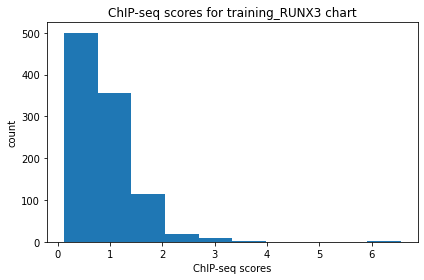

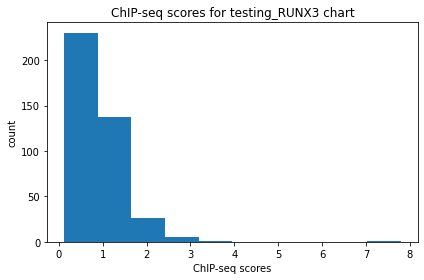

In [232]:
# loading training data for TF RUNX3
Y_train_RUNX3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train.bed")
Y_trainlabel_RUNX3 = Chiseqscore_to_label(Y_train_RUNX3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train.bed", TF_name ="RUNX3", datatype = "training")
matrix_tensor_files_train_RUNX3, matrix_length_arr_train_RUNX3, dict_matrix_train_RUNX3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/RUNX3/")
X_train_seq_all_tensor_train_RUNX3, X_train_seq_tensor_train_RUNX3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train-sequence.fa", matrix_length_arr_train_RUNX3, matrix_tensor_files_train_RUNX3)
backgound_seq_all_tensor_train_RUNX3 = background_convolution_seq(matrix_length_arr_train_RUNX3, X_train_seq_tensor_train_RUNX3, matrix_tensor_files_train_RUNX3)
X_train_seq_all_tensor_noisefree_train_RUNX3 = log_pwm_background(X_train_seq_all_tensor_train_RUNX3, backgound_seq_all_tensor_train_RUNX3)
X_train_max_train_RUNX3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_RUNX3)
X_train_flatten_train_RUNX3 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_RUNX3)

# loading testing data for TF RUNX3
Y_test_RUNX3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test.bed")
Y_testlabel_RUNX3 = Chiseqscore_to_label(Y_test_RUNX3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test.bed", TF_name ="RUNX3", datatype = "testing")
matrix_tensor_files_test_RUNX3, matrix_length_arr_test_RUNX3, dict_matrix_test_RUNX3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/RUNX3/")
X_test_seq_all_tensor_test_RUNX3, X_test_seq_tensor_test_RUNX3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test-sequence.fa", matrix_length_arr_test_RUNX3, matrix_tensor_files_test_RUNX3)
backgound_seq_all_tensor_test_RUNX3 = background_convolution_seq(matrix_length_arr_test_RUNX3, X_test_seq_tensor_test_RUNX3, matrix_tensor_files_test_RUNX3)
X_test_seq_all_tensor_noisefree_test_RUNX3 = log_pwm_background(X_test_seq_all_tensor_test_RUNX3, backgound_seq_all_tensor_test_RUNX3)
X_test_max_test_RUNX3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_RUNX3)
X_test_flatten_test_RUNX3 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_RUNX3)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [237]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_RUNX3 = Y_trainlabel_RUNX3.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_RUNX3, Y_trainlabel_RUNX3, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_RUNX3 = Y_trainlabel_RUNX3.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_RUNX3, Y_trainlabel_RUNX3)


# Prediction on X_test_max_test_RUNX3
y_maxpred_test_RUNX3 = clf_train_max.predict(X_test_max_test_RUNX3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RUNX3, y_maxpred_test_RUNX3))



# X_train_flatten_train_TFname training 
Y_trainlabel_RUNX3 = Y_trainlabel_RUNX3.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_RUNX3, Y_trainlabel_RUNX3)
# Prediction on X_test_flatten_test_RUNX3
y_flattenpred_test_RUNX3 = clf_train_flatten.predict(X_test_flatten_test_RUNX3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RUNX3, y_flattenpred_test_RUNX3))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_RUNX3) 
metrics.accuracy_score(Y_trainlabel_RUNX3, y_train_max_pred)


0.5660000000000001
Accuracy: 0.505
Accuracy: 0.6425


0.939

In [241]:
# X_train_max_train_TFname training 
Y_trainlabel_RUNX3 = Y_trainlabel_RUNX3.reshape(-1)
clf_train_max = SVC(random_state=42)
clf_train_max.fit(X_train_max_train_RUNX3, Y_trainlabel_RUNX3)


# Prediction on X_test_max_test_RUNX3
y_maxpred_test_RUNX3 = clf_train_max.predict(X_test_max_test_RUNX3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RUNX3, y_maxpred_test_RUNX3))

Accuracy: 0.5975


In [239]:
print(dict_matrix_train_RUNX3)
# print(matrix_tensor_files_train_RUNX3[3])
# print(matrix_tensor_files_train_RUNX3[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_RUNX3[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'RUNX3_GM12878_5.wtmx': 0, 'RUNX3_GM12878_3.wtmx': 1, 'RUNX3_GM12878_4.wtmx': 2, 'RUNX3_GM12878_1.wtmx': 3, 'RUNX3_HOCO_C.wtmx': 4, 'RUNX3_GM12878_2.wtmx': 5, 'RUNX3_FB_1.wtmx': 6}
(7, 15, 4)


In [240]:
one_wtmx = np.tile(matrix_tensor_files_train_RUNX3[0],(7, 1,1))
# loading training data for TF RUNX3
Y_train_RUNX3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train.bed")
Y_trainlabel_RUNX3 = Chiseqscore_to_label(Y_train_RUNX3)

X_train_seq_all_tensor_train_RUNX3, X_train_seq_tensor_train_RUNX3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-train-sequence.fa", matrix_length_arr_train_RUNX3, one_wtmx)
backgound_seq_all_tensor_train_RUNX3 = background_convolution_seq(matrix_length_arr_train_RUNX3, X_train_seq_tensor_train_RUNX3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_RUNX3 = log_pwm_background(X_train_seq_all_tensor_train_RUNX3, backgound_seq_all_tensor_train_RUNX3)
X_train_max_train_RUNX3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_RUNX3)

# loading testing data for TF RUNX3
Y_test_RUNX3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test.bed")
Y_testlabel_RUNX3 = Chiseqscore_to_label(Y_test_RUNX3)

X_test_seq_all_tensor_test_RUNX3, X_test_seq_tensor_test_RUNX3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/RUNX3/RUNX3-test-sequence.fa", matrix_length_arr_test_RUNX3, one_wtmx)
backgound_seq_all_tensor_test_RUNX3 = background_convolution_seq(matrix_length_arr_test_RUNX3, X_test_seq_tensor_test_RUNX3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_RUNX3 = log_pwm_background(X_test_seq_all_tensor_test_RUNX3, backgound_seq_all_tensor_test_RUNX3)
X_test_max_test_RUNX3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_RUNX3)

# Y_trainlabel_RUNX3 = label_cleaning(Y_trainlabel_RUNX3, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_RUNX3 = Y_trainlabel_RUNX3.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_RUNX3, Y_trainlabel_RUNX3)
# Prediction on X_test_max_test_RUNX3
y_maxpred_test_RUNX3 = clf_train_max.predict(X_test_max_test_RUNX3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_RUNX3, y_maxpred_test_RUNX3))


Accuracy: 0.605


In [245]:
# print(X_test_seq_all_tensor_noisefree_test_RUNX3.shape)
# print(X_test_seq_all_tensor_noisefree_test_RUNX3)
# print(X_train_seq_all_tensor_noisefree_train_RUNX3.shape)
# print(X_train_seq_all_tensor_noisefree_train_RUNX3)

### **TF: SIN3A** 



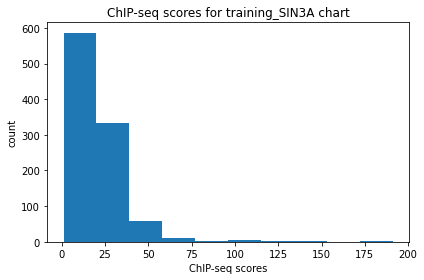

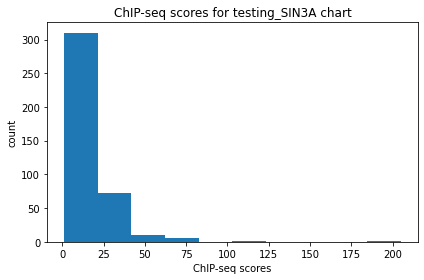

In [246]:
# loading training data for TF SIN3A
Y_train_SIN3A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train.bed")
Y_trainlabel_SIN3A = Chiseqscore_to_label(Y_train_SIN3A)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train.bed", TF_name ="SIN3A", datatype = "training")
matrix_tensor_files_train_SIN3A, matrix_length_arr_train_SIN3A, dict_matrix_train_SIN3A  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/SIN3A/")
X_train_seq_all_tensor_train_SIN3A, X_train_seq_tensor_train_SIN3A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train-sequence.fa", matrix_length_arr_train_SIN3A, matrix_tensor_files_train_SIN3A)
backgound_seq_all_tensor_train_SIN3A = background_convolution_seq(matrix_length_arr_train_SIN3A, X_train_seq_tensor_train_SIN3A, matrix_tensor_files_train_SIN3A)
X_train_seq_all_tensor_noisefree_train_SIN3A = log_pwm_background(X_train_seq_all_tensor_train_SIN3A, backgound_seq_all_tensor_train_SIN3A)
X_train_max_train_SIN3A = X_max_generator(X_train_seq_all_tensor_noisefree_train_SIN3A)
X_train_flatten_train_SIN3A = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_SIN3A)

# loading testing data for TF SIN3A
Y_test_SIN3A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test.bed")
Y_testlabel_SIN3A = Chiseqscore_to_label(Y_test_SIN3A)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test.bed", TF_name ="SIN3A", datatype = "testing")
matrix_tensor_files_test_SIN3A, matrix_length_arr_test_SIN3A, dict_matrix_test_SIN3A  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/SIN3A/")
X_test_seq_all_tensor_test_SIN3A, X_test_seq_tensor_test_SIN3A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test-sequence.fa", matrix_length_arr_test_SIN3A, matrix_tensor_files_test_SIN3A)
backgound_seq_all_tensor_test_SIN3A = background_convolution_seq(matrix_length_arr_test_SIN3A, X_test_seq_tensor_test_SIN3A, matrix_tensor_files_test_SIN3A)
X_test_seq_all_tensor_noisefree_test_SIN3A = log_pwm_background(X_test_seq_all_tensor_test_SIN3A, backgound_seq_all_tensor_test_SIN3A)
X_test_max_test_SIN3A = X_max_generator(X_test_seq_all_tensor_noisefree_test_SIN3A)
X_test_flatten_test_SIN3A = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_SIN3A)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [252]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_SIN3A = Y_trainlabel_SIN3A.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_SIN3A, Y_trainlabel_SIN3A, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_SIN3A = Y_trainlabel_SIN3A.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_SIN3A, Y_trainlabel_SIN3A)


# Prediction on X_test_max_test_SIN3A
y_maxpred_test_SIN3A = clf_train_max.predict(X_test_max_test_SIN3A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SIN3A, y_maxpred_test_SIN3A))



# X_train_flatten_train_TFname training 
Y_trainlabel_SIN3A = Y_trainlabel_SIN3A.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_SIN3A, Y_trainlabel_SIN3A)
# Prediction on X_test_flatten_test_SIN3A
y_flattenpred_test_SIN3A = clf_train_flatten.predict(X_test_flatten_test_SIN3A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SIN3A, y_flattenpred_test_SIN3A))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_SIN3A) 
metrics.accuracy_score(Y_trainlabel_SIN3A, y_train_max_pred)

0.764
Accuracy: 0.7025
Accuracy: 0.7


0.802

In [254]:
print(dict_matrix_train_SIN3A)
# print(matrix_tensor_files_train_SIN3A[3])
# print(matrix_tensor_files_train_SIN3A[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_SIN3A[4],(5, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'SIN3A_GM12878_5.wtmx': 0, 'SIN3A_GM12878_1.wtmx': 1, 'SIN3A_GM12878_4.wtmx': 2, 'SIN3A_GM12878_2.wtmx': 3, 'SIN3A_GM12878_3.wtmx': 4}
(5, 21, 4)


In [256]:
one_wtmx = np.tile(matrix_tensor_files_train_SIN3A[0],(5, 1,1))
# loading training data for TF SIN3A
Y_train_SIN3A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train.bed")
Y_trainlabel_SIN3A = Chiseqscore_to_label(Y_train_SIN3A)

X_train_seq_all_tensor_train_SIN3A, X_train_seq_tensor_train_SIN3A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-train-sequence.fa", matrix_length_arr_train_SIN3A, one_wtmx)
backgound_seq_all_tensor_train_SIN3A = background_convolution_seq(matrix_length_arr_train_SIN3A, X_train_seq_tensor_train_SIN3A, one_wtmx)
X_train_seq_all_tensor_noisefree_train_SIN3A = log_pwm_background(X_train_seq_all_tensor_train_SIN3A, backgound_seq_all_tensor_train_SIN3A)
X_train_max_train_SIN3A = X_max_generator(X_train_seq_all_tensor_noisefree_train_SIN3A)

# loading testing data for TF SIN3A
Y_test_SIN3A = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test.bed")
Y_testlabel_SIN3A = Chiseqscore_to_label(Y_test_SIN3A)

X_test_seq_all_tensor_test_SIN3A, X_test_seq_tensor_test_SIN3A = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SIN3A/SIN3A-test-sequence.fa", matrix_length_arr_test_SIN3A, one_wtmx)
backgound_seq_all_tensor_test_SIN3A = background_convolution_seq(matrix_length_arr_test_SIN3A, X_test_seq_tensor_test_SIN3A, one_wtmx)
X_test_seq_all_tensor_noisefree_test_SIN3A = log_pwm_background(X_test_seq_all_tensor_test_SIN3A, backgound_seq_all_tensor_test_SIN3A)
X_test_max_test_SIN3A = X_max_generator(X_test_seq_all_tensor_noisefree_test_SIN3A)

# Y_trainlabel_SIN3A = label_cleaning(Y_trainlabel_SIN3A, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_SIN3A = Y_trainlabel_SIN3A.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_SIN3A, Y_trainlabel_SIN3A)
# Prediction on X_test_max_test_SIN3A
y_maxpred_test_SIN3A = clf_train_max.predict(X_test_max_test_SIN3A)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SIN3A, y_maxpred_test_SIN3A))

Accuracy: 0.69


In [258]:
# print(X_test_seq_all_tensor_noisefree_test_SIN3A.shape)
# print(X_test_seq_all_tensor_noisefree_test_SIN3A)
# print(X_train_seq_all_tensor_noisefree_train_SIN3A.shape)
# print(X_train_seq_all_tensor_noisefree_train_SIN3A)

### **TF: SPI1** 



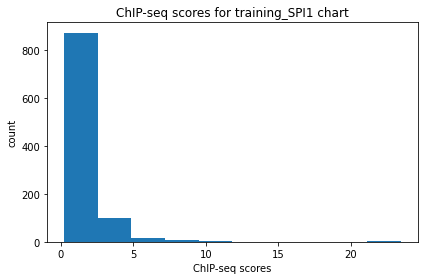

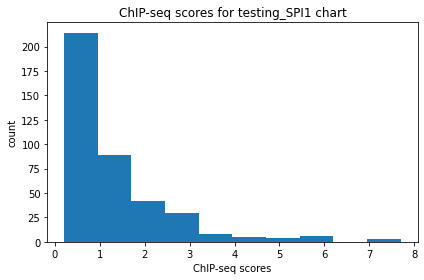

In [259]:
# loading training data for TF SPI1
Y_train_SPI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train.bed")
Y_trainlabel_SPI1 = Chiseqscore_to_label(Y_train_SPI1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train.bed", TF_name ="SPI1", datatype = "training")
matrix_tensor_files_train_SPI1, matrix_length_arr_train_SPI1, dict_matrix_train_SPI1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/SPI1/")
X_train_seq_all_tensor_train_SPI1, X_train_seq_tensor_train_SPI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train-sequence.fa", matrix_length_arr_train_SPI1, matrix_tensor_files_train_SPI1)
backgound_seq_all_tensor_train_SPI1 = background_convolution_seq(matrix_length_arr_train_SPI1, X_train_seq_tensor_train_SPI1, matrix_tensor_files_train_SPI1)
X_train_seq_all_tensor_noisefree_train_SPI1 = log_pwm_background(X_train_seq_all_tensor_train_SPI1, backgound_seq_all_tensor_train_SPI1)
X_train_max_train_SPI1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_SPI1)
X_train_flatten_train_SPI1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_SPI1)

# loading testing data for TF SPI1
Y_test_SPI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test.bed")
Y_testlabel_SPI1 = Chiseqscore_to_label(Y_test_SPI1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test.bed", TF_name ="SPI1", datatype = "testing")
matrix_tensor_files_test_SPI1, matrix_length_arr_test_SPI1, dict_matrix_test_SPI1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/SPI1/")
X_test_seq_all_tensor_test_SPI1, X_test_seq_tensor_test_SPI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test-sequence.fa", matrix_length_arr_test_SPI1, matrix_tensor_files_test_SPI1)
backgound_seq_all_tensor_test_SPI1 = background_convolution_seq(matrix_length_arr_test_SPI1, X_test_seq_tensor_test_SPI1, matrix_tensor_files_test_SPI1)
X_test_seq_all_tensor_noisefree_test_SPI1 = log_pwm_background(X_test_seq_all_tensor_test_SPI1, backgound_seq_all_tensor_test_SPI1)
X_test_max_test_SPI1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_SPI1)
X_test_flatten_test_SPI1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_SPI1)


In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [264]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_SPI1 = Y_trainlabel_SPI1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_SPI1, Y_trainlabel_SPI1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_SPI1 = Y_trainlabel_SPI1.reshape(-1)
clf_train_max = SVC(C = 0.05, random_state=42)
clf_train_max.fit(X_train_max_train_SPI1, Y_trainlabel_SPI1)


# Prediction on X_test_max_test_SPI1
y_maxpred_test_SPI1 = clf_train_max.predict(X_test_max_test_SPI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SPI1, y_maxpred_test_SPI1))



# X_train_flatten_train_TFname training 
Y_trainlabel_SPI1 = Y_trainlabel_SPI1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_SPI1, Y_trainlabel_SPI1)
# Prediction on X_test_flatten_test_SPI1
y_flattenpred_test_SPI1 = clf_train_flatten.predict(X_test_flatten_test_SPI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SPI1, y_flattenpred_test_SPI1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_SPI1) 
metrics.accuracy_score(Y_trainlabel_SPI1, y_train_max_pred)

0.6220000000000001
Accuracy: 0.59
Accuracy: 0.5525


0.77

In [266]:
print(dict_matrix_train_SPI1)
# print(matrix_tensor_files_train_SPI1[3])
# print(matrix_tensor_files_train_SPI1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_SPI1[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'SPI1_GM12878_2.wtmx': 0, 'SPI1_FB_1.wtmx': 1, 'SPI1_GM12878_5.wtmx': 2, 'SPI1_HOCO_A.wtmx': 3, 'SPI1_GM12878_4.wtmx': 4, 'SPI1_GM12878_1.wtmx': 5, 'SPI1_GM12878_3.wtmx': 6}
(7, 17, 4)


In [268]:
one_wtmx = np.tile(matrix_tensor_files_train_SPI1[0],(7, 1,1))
# loading training data for TF SPI1
Y_train_SPI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train.bed")
Y_trainlabel_SPI1 = Chiseqscore_to_label(Y_train_SPI1)

X_train_seq_all_tensor_train_SPI1, X_train_seq_tensor_train_SPI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-train-sequence.fa", matrix_length_arr_train_SPI1, one_wtmx)
backgound_seq_all_tensor_train_SPI1 = background_convolution_seq(matrix_length_arr_train_SPI1, X_train_seq_tensor_train_SPI1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_SPI1 = log_pwm_background(X_train_seq_all_tensor_train_SPI1, backgound_seq_all_tensor_train_SPI1)
X_train_max_train_SPI1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_SPI1)

# loading testing data for TF SPI1
Y_test_SPI1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test.bed")
Y_testlabel_SPI1 = Chiseqscore_to_label(Y_test_SPI1)

X_test_seq_all_tensor_test_SPI1, X_test_seq_tensor_test_SPI1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/SPI1/SPI1-test-sequence.fa", matrix_length_arr_test_SPI1, one_wtmx)
backgound_seq_all_tensor_test_SPI1 = background_convolution_seq(matrix_length_arr_test_SPI1, X_test_seq_tensor_test_SPI1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_SPI1 = log_pwm_background(X_test_seq_all_tensor_test_SPI1, backgound_seq_all_tensor_test_SPI1)
X_test_max_test_SPI1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_SPI1)

# Y_trainlabel_SPI1 = label_cleaning(Y_trainlabel_SPI1, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_SPI1 = Y_trainlabel_SPI1.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_SPI1, Y_trainlabel_SPI1)
# Prediction on X_test_max_test_SPI1
y_maxpred_test_SPI1 = clf_train_max.predict(X_test_max_test_SPI1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_SPI1, y_maxpred_test_SPI1))

Accuracy: 0.56


In [316]:
print(X_test_seq_all_tensor_noisefree_test_SPI1.shape)
print(X_test_seq_all_tensor_noisefree_test_SPI1)
print(X_train_seq_all_tensor_noisefree_train_SPI1.shape)
print(X_train_seq_all_tensor_noisefree_train_SPI1)

(400, 7, 485)
[[[0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]
  [0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]
  [0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]
  ...
  [0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]
  [0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]
  [0.57321652 0.92866083 0.65081352 ... 0.67334168 1.11138924 1.0387985 ]]

 [[0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]
  [0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]
  [0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]
  ...
  [0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]
  [0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]
  [0.78347935 0.56320401 1.06633292 ... 0.41802253 0.79098874 0.80600751]]

 [[0.96370463 0.83854819 0.93617021 ... 1.0738423  0.67083855 1.03128911]
  [0.963

### **TF: TCF12** 



In [290]:
# # loading training data for TF TCF12
# Y_train_TCF12 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train.bed")
# Y_trainlabel_TCF12 = Chiseqscore_to_label(Y_train_TCF12)
# # cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train.bed", TF_name ="TCF12", datatype = "training")
# matrix_tensor_files_train_TCF12, matrix_length_arr_train_TCF12, dict_matrix_train_TCF12  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/TCF12/")
# X_train_seq_all_tensor_train_TCF12, X_train_seq_tensor_train_TCF12 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train-sequence.fa", matrix_length_arr_train_TCF12, matrix_tensor_files_train_TCF12)
# backgound_seq_all_tensor_train_TCF12 = background_convolution_seq(matrix_length_arr_train_TCF12, X_train_seq_tensor_train_TCF12, matrix_tensor_files_train_TCF12)
# X_train_seq_all_tensor_noisefree_train_TCF12 = log_pwm_background(X_train_seq_all_tensor_train_TCF12, backgound_seq_all_tensor_train_TCF12)
# X_train_max_train_TCF12 = X_max_generator(X_train_seq_all_tensor_noisefree_train_TCF12)
# X_train_flatten_train_TCF12 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_TCF12)

# # loading testing data for TF TCF12
# Y_test_TCF12 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test.bed")
# Y_testlabel_TCF12 = Chiseqscore_to_label(Y_test_TCF12)
# cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test.bed", TF_name ="TCF12", datatype = "testing")
# matrix_tensor_files_test_TCF12, matrix_length_arr_test_TCF12, dict_matrix_test_TCF12  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/TCF12/")
# X_test_seq_all_tensor_test_TCF12, X_test_seq_tensor_test_TCF12 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test-sequence.fa", matrix_length_arr_test_TCF12, matrix_tensor_files_test_TCF12)
# backgound_seq_all_tensor_test_TCF12 = background_convolution_seq(matrix_length_arr_test_TCF12, X_test_seq_tensor_test_TCF12, matrix_tensor_files_test_TCF12)
# X_test_seq_all_tensor_noisefree_test_TCF12 = log_pwm_background(X_test_seq_all_tensor_test_TCF12, backgound_seq_all_tensor_test_TCF12)
# X_test_max_test_TCF12 = X_max_generator(X_test_seq_all_tensor_noisefree_test_TCF12)
# X_test_flatten_test_TCF12 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_TCF12)

In [291]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [292]:
# clf_test = SVC(C = 0.1, random_state=42)
# Y_trainlabel_TCF12 = Y_trainlabel_TCF12.reshape(-1)
# scores_test = cross_val_score(clf_test, X_train_max_train_TCF12, Y_trainlabel_TCF12, cv=10)
# print(scores_test.mean())
# # X_train_max_train_TFname training 
# Y_trainlabel_TCF12 = Y_trainlabel_TCF12.reshape(-1)
# clf_train_max = SVC(C = 0.05, random_state=42)
# clf_train_max.fit(X_train_max_train_TCF12, Y_trainlabel_TCF12)


# # Prediction on X_test_max_test_TCF12
# y_maxpred_test_TCF12 = clf_train_max.predict(X_test_max_test_TCF12)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF12, y_maxpred_test_TCF12))



# # X_train_flatten_train_TFname training 
# Y_trainlabel_TCF12 = Y_trainlabel_TCF12.reshape(-1)
# clf_train_flatten = SVC(C = 0.1, random_state=42)
# clf_train_flatten.fit(X_train_flatten_train_TCF12, Y_trainlabel_TCF12)
# # Prediction on X_test_flatten_test_TCF12
# y_flattenpred_test_TCF12 = clf_train_flatten.predict(X_test_flatten_test_TCF12)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF12, y_flattenpred_test_TCF12))


# #training accuracy for max-pooling
# y_train_max_pred = clf_train_max.predict(X_train_max_train_TCF12) 
# metrics.accuracy_score(Y_trainlabel_TCF12, y_train_max_pred)

In [293]:
# # X_train_max_train_TFname training 
# Y_trainlabel_TCF12 = Y_trainlabel_TCF12.reshape(-1)
# clf_train_max = SVC(C = 10, random_state=42)
# clf_train_max.fit(X_train_max_train_TCF12, Y_trainlabel_TCF12)


# # Prediction on X_test_max_test_TCF12
# y_maxpred_test_TCF12 = clf_train_max.predict(X_test_max_test_TCF12)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF12, y_maxpred_test_TCF12))

In [294]:
# print(dict_matrix_train_TCF12)
# # print(matrix_tensor_files_train_TCF12[3])
# # print(matrix_tensor_files_train_TCF12[0].shape)
# one_wtmx = np.tile(matrix_tensor_files_train_TCF12[4],(6, 1,1))
# print(one_wtmx.shape)
# # print(one_wtmx)

In [295]:
# one_wtmx = np.tile(matrix_tensor_files_train_TCF12[3],(6, 1,1))
# # loading training data for TF TCF12
# Y_train_TCF12 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train.bed")
# Y_trainlabel_TCF12 = Chiseqscore_to_label(Y_train_TCF12)

# X_train_seq_all_tensor_train_TCF12, X_train_seq_tensor_train_TCF12 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-train-sequence.fa", matrix_length_arr_train_TCF12, one_wtmx)
# backgound_seq_all_tensor_train_TCF12 = background_convolution_seq(matrix_length_arr_train_TCF12, X_train_seq_tensor_train_TCF12, one_wtmx)
# X_train_seq_all_tensor_noisefree_train_TCF12 = log_pwm_background(X_train_seq_all_tensor_train_TCF12, backgound_seq_all_tensor_train_TCF12)
# X_train_max_train_TCF12 = X_max_generator(X_train_seq_all_tensor_noisefree_train_TCF12)

# # loading testing data for TF TCF12
# Y_test_TCF12 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test.bed")
# Y_testlabel_TCF12 = Chiseqscore_to_label(Y_test_TCF12)

# X_test_seq_all_tensor_test_TCF12, X_test_seq_tensor_test_TCF12 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF12/TCF12-test-sequence.fa", matrix_length_arr_test_TCF12, one_wtmx)
# backgound_seq_all_tensor_test_TCF12 = background_convolution_seq(matrix_length_arr_test_TCF12, X_test_seq_tensor_test_TCF12, one_wtmx)
# X_test_seq_all_tensor_noisefree_test_TCF12 = log_pwm_background(X_test_seq_all_tensor_test_TCF12, backgound_seq_all_tensor_test_TCF12)
# X_test_max_test_TCF12 = X_max_generator(X_test_seq_all_tensor_noisefree_test_TCF12)

# # Y_trainlabel_TCF12 = label_cleaning(Y_trainlabel_TCF12, violation_index_list = [108])

# # X_train_max_train_TFname training 
# Y_trainlabel_TCF12 = Y_trainlabel_TCF12.reshape(-1)
# clf_train_max = SVC(C = 0.05, random_state=42)
# clf_train_max.fit(X_train_max_train_TCF12, Y_trainlabel_TCF12)
# # Prediction on X_test_max_test_TCF12
# y_maxpred_test_TCF12 = clf_train_max.predict(X_test_max_test_TCF12)
# print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF12, y_maxpred_test_TCF12))

In [315]:
# print(X_test_seq_all_tensor_noisefree_test_TCF12.shape)
# print(X_test_seq_all_tensor_noisefree_test_TCF12)
# print(X_train_seq_all_tensor_noisefree_train_TCF12.shape)
# print(X_train_seq_all_tensor_noisefree_train_TCF12)

### **TF: TCF3** 



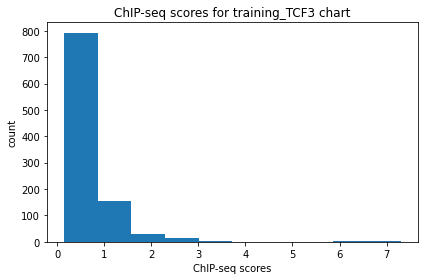

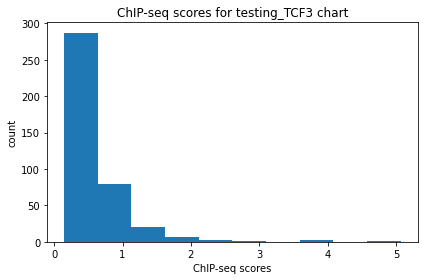

In [306]:
# loading training data for TF TCF3
Y_train_TCF3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train.bed")
Y_trainlabel_TCF3 = Chiseqscore_to_label(Y_train_TCF3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train.bed", TF_name ="TCF3", datatype = "training")
matrix_tensor_files_train_TCF3, matrix_length_arr_train_TCF3, dict_matrix_train_TCF3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/TCF3/")
X_train_seq_all_tensor_train_TCF3, X_train_seq_tensor_train_TCF3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train-sequence.fa", matrix_length_arr_train_TCF3, matrix_tensor_files_train_TCF3)
backgound_seq_all_tensor_train_TCF3 = background_convolution_seq(matrix_length_arr_train_TCF3, X_train_seq_tensor_train_TCF3, matrix_tensor_files_train_TCF3)
X_train_seq_all_tensor_noisefree_train_TCF3 = log_pwm_background(X_train_seq_all_tensor_train_TCF3, backgound_seq_all_tensor_train_TCF3)
X_train_max_train_TCF3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_TCF3)
X_train_flatten_train_TCF3 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_TCF3)

# loading testing data for TF TCF3
Y_test_TCF3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test.bed")
Y_testlabel_TCF3 = Chiseqscore_to_label(Y_test_TCF3)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test.bed", TF_name ="TCF3", datatype = "testing")
matrix_tensor_files_test_TCF3, matrix_length_arr_test_TCF3, dict_matrix_test_TCF3  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/TCF3/")
X_test_seq_all_tensor_test_TCF3, X_test_seq_tensor_test_TCF3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test-sequence.fa", matrix_length_arr_test_TCF3, matrix_tensor_files_test_TCF3)
backgound_seq_all_tensor_test_TCF3 = background_convolution_seq(matrix_length_arr_test_TCF3, X_test_seq_tensor_test_TCF3, matrix_tensor_files_test_TCF3)
X_test_seq_all_tensor_noisefree_test_TCF3 = log_pwm_background(X_test_seq_all_tensor_test_TCF3, backgound_seq_all_tensor_test_TCF3)
X_test_max_test_TCF3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_TCF3)
X_test_flatten_test_TCF3 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_TCF3)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [299]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_TCF3 = Y_trainlabel_TCF3.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_TCF3, Y_trainlabel_TCF3, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_TCF3 = Y_trainlabel_TCF3.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_TCF3, Y_trainlabel_TCF3)


# Prediction on X_test_max_test_TCF3
y_maxpred_test_TCF3 = clf_train_max.predict(X_test_max_test_TCF3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF3, y_maxpred_test_TCF3))



# X_train_flatten_train_TFname training 
Y_trainlabel_TCF3 = Y_trainlabel_TCF3.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_TCF3, Y_trainlabel_TCF3)
# Prediction on X_test_flatten_test_TCF3
y_flattenpred_test_TCF3 = clf_train_flatten.predict(X_test_flatten_test_TCF3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF3, y_flattenpred_test_TCF3))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_TCF3) 
metrics.accuracy_score(Y_trainlabel_TCF3, y_train_max_pred)

0.568
Accuracy: 0.5475
Accuracy: 0.5725


0.603

In [312]:
# X_train_max_train_TFname training 
Y_trainlabel_TCF3 = Y_trainlabel_TCF3.reshape(-1)
clf_train_max = SVC(C=10, random_state=42)
clf_train_max.fit(X_train_max_train_TCF3, Y_trainlabel_TCF3)


# Prediction on X_test_max_test_TCF3
y_maxpred_test_TCF3 = clf_train_max.predict(X_test_max_test_TCF3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF3, y_maxpred_test_TCF3))

Accuracy: 0.575


In [301]:
print(dict_matrix_train_TCF3)
# print(matrix_tensor_files_train_TCF3[3])
# print(matrix_tensor_files_train_TCF3[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_TCF3[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)


{'TCF3_GM12878_3.wtmx': 0, 'TCF3_GM12878_2.wtmx': 1, 'TCF3_GM12878_1.wtmx': 2, 'TCF3_FB_1.wtmx': 3, 'TCF3_GM12878_4.wtmx': 4, 'TCF3_GM12878_5.wtmx': 5}
(6, 15, 4)


In [304]:
one_wtmx = np.tile(matrix_tensor_files_train_TCF3[0],(6, 1,1))
# loading training data for TF TCF3
Y_train_TCF3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train.bed")
Y_trainlabel_TCF3 = Chiseqscore_to_label(Y_train_TCF3)

X_train_seq_all_tensor_train_TCF3, X_train_seq_tensor_train_TCF3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-train-sequence.fa", matrix_length_arr_train_TCF3, one_wtmx)
backgound_seq_all_tensor_train_TCF3 = background_convolution_seq(matrix_length_arr_train_TCF3, X_train_seq_tensor_train_TCF3, one_wtmx)
X_train_seq_all_tensor_noisefree_train_TCF3 = log_pwm_background(X_train_seq_all_tensor_train_TCF3, backgound_seq_all_tensor_train_TCF3)
X_train_max_train_TCF3 = X_max_generator(X_train_seq_all_tensor_noisefree_train_TCF3)

# loading testing data for TF TCF3
Y_test_TCF3 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test.bed")
Y_testlabel_TCF3 = Chiseqscore_to_label(Y_test_TCF3)

X_test_seq_all_tensor_test_TCF3, X_test_seq_tensor_test_TCF3 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/TCF3/TCF3-test-sequence.fa", matrix_length_arr_test_TCF3, one_wtmx)
backgound_seq_all_tensor_test_TCF3 = background_convolution_seq(matrix_length_arr_test_TCF3, X_test_seq_tensor_test_TCF3, one_wtmx)
X_test_seq_all_tensor_noisefree_test_TCF3 = log_pwm_background(X_test_seq_all_tensor_test_TCF3, backgound_seq_all_tensor_test_TCF3)
X_test_max_test_TCF3 = X_max_generator(X_test_seq_all_tensor_noisefree_test_TCF3)

# Y_trainlabel_TCF3 = label_cleaning(Y_trainlabel_TCF3, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_TCF3 = Y_trainlabel_TCF3.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_TCF3, Y_trainlabel_TCF3)
# Prediction on X_test_max_test_TCF3
y_maxpred_test_TCF3 = clf_train_max.predict(X_test_max_test_TCF3)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_TCF3, y_maxpred_test_TCF3))

Accuracy: 0.585


In [317]:
# print(X_test_seq_all_tensor_noisefree_test_TCF3.shape)
# print(X_test_seq_all_tensor_noisefree_test_TCF3)
# print(X_train_seq_all_tensor_noisefree_train_TCF3.shape)
# print(X_train_seq_all_tensor_noisefree_train_TCF3)

### **TF: USF1** 



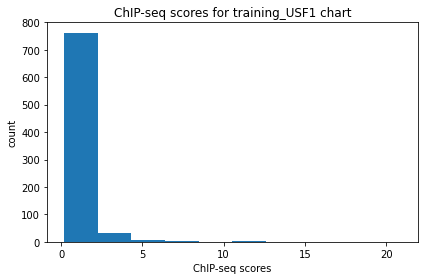

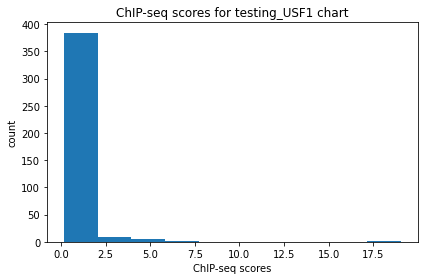

In [319]:
# loading training data for TF USF1
Y_train_USF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train.bed")
Y_trainlabel_USF1 = Chiseqscore_to_label(Y_train_USF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train.bed", TF_name ="USF1", datatype = "training")
matrix_tensor_files_train_USF1, matrix_length_arr_train_USF1, dict_matrix_train_USF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/USF1/")
X_train_seq_all_tensor_train_USF1, X_train_seq_tensor_train_USF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train-sequence.fa", matrix_length_arr_train_USF1, matrix_tensor_files_train_USF1)
backgound_seq_all_tensor_train_USF1 = background_convolution_seq(matrix_length_arr_train_USF1, X_train_seq_tensor_train_USF1, matrix_tensor_files_train_USF1)
X_train_seq_all_tensor_noisefree_train_USF1 = log_pwm_background(X_train_seq_all_tensor_train_USF1, backgound_seq_all_tensor_train_USF1)
X_train_max_train_USF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_USF1)
X_train_flatten_train_USF1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_USF1)

# loading testing data for TF USF1
Y_test_USF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test.bed")
Y_testlabel_USF1 = Chiseqscore_to_label(Y_test_USF1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test.bed", TF_name ="USF1", datatype = "testing")
matrix_tensor_files_test_USF1, matrix_length_arr_test_USF1, dict_matrix_test_USF1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/USF1/")
X_test_seq_all_tensor_test_USF1, X_test_seq_tensor_test_USF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test-sequence.fa", matrix_length_arr_test_USF1, matrix_tensor_files_test_USF1)
backgound_seq_all_tensor_test_USF1 = background_convolution_seq(matrix_length_arr_test_USF1, X_test_seq_tensor_test_USF1, matrix_tensor_files_test_USF1)
X_test_seq_all_tensor_noisefree_test_USF1 = log_pwm_background(X_test_seq_all_tensor_test_USF1, backgound_seq_all_tensor_test_USF1)
X_test_max_test_USF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_USF1)
X_test_flatten_test_USF1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_USF1)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [326]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_USF1 = Y_trainlabel_USF1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_USF1, Y_trainlabel_USF1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_USF1 = Y_trainlabel_USF1.reshape(-1)
clf_train_max = SVC(C = 0.001, random_state=42)
clf_train_max.fit(X_train_max_train_USF1, Y_trainlabel_USF1)


# Prediction on X_test_max_test_USF1
y_maxpred_test_USF1 = clf_train_max.predict(X_test_max_test_USF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF1, y_maxpred_test_USF1))



# X_train_flatten_train_TFname training 
Y_trainlabel_USF1 = Y_trainlabel_USF1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_USF1, Y_trainlabel_USF1)
# Prediction on X_test_flatten_test_USF1
y_flattenpred_test_USF1 = clf_train_flatten.predict(X_test_flatten_test_USF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF1, y_flattenpred_test_USF1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_USF1) 
metrics.accuracy_score(Y_trainlabel_USF1, y_train_max_pred)

0.5550462962962963
Accuracy: 0.59
Accuracy: 0.55


0.9379652605459057

In [328]:
print(dict_matrix_train_USF1)
# print(matrix_tensor_files_train_USF1[3])
# print(matrix_tensor_files_train_USF1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_USF1[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)


{'USF1_GM12878_5.wtmx': 0, 'USF1_FB_1.wtmx': 1, 'USF1_GM12878_2.wtmx': 2, 'USF1_GM12878_3.wtmx': 3, 'USF1_GM12878_4.wtmx': 4, 'USF1_HOCO_A.wtmx': 5, 'USF1_GM12878_1.wtmx': 6}
(7, 21, 4)


In [331]:
one_wtmx = np.tile(matrix_tensor_files_train_USF1[0],(6, 1,1))
# loading training data for TF USF1
Y_train_USF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train.bed")
Y_trainlabel_USF1 = Chiseqscore_to_label(Y_train_USF1)

X_train_seq_all_tensor_train_USF1, X_train_seq_tensor_train_USF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-train-sequence.fa", matrix_length_arr_train_USF1, one_wtmx)
backgound_seq_all_tensor_train_USF1 = background_convolution_seq(matrix_length_arr_train_USF1, X_train_seq_tensor_train_USF1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_USF1 = log_pwm_background(X_train_seq_all_tensor_train_USF1, backgound_seq_all_tensor_train_USF1)
X_train_max_train_USF1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_USF1)

# loading testing data for TF USF1
Y_test_USF1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test.bed")
Y_testlabel_USF1 = Chiseqscore_to_label(Y_test_USF1)

X_test_seq_all_tensor_test_USF1, X_test_seq_tensor_test_USF1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF1/USF1-test-sequence.fa", matrix_length_arr_test_USF1, one_wtmx)
backgound_seq_all_tensor_test_USF1 = background_convolution_seq(matrix_length_arr_test_USF1, X_test_seq_tensor_test_USF1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_USF1 = log_pwm_background(X_test_seq_all_tensor_test_USF1, backgound_seq_all_tensor_test_USF1)
X_test_max_test_USF1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_USF1)

# Y_trainlabel_USF1 = label_cleaning(Y_trainlabel_USF1, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_USF1 = Y_trainlabel_USF1.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_USF1, Y_trainlabel_USF1)
# Prediction on X_test_max_test_USF1
y_maxpred_test_USF1 = clf_train_max.predict(X_test_max_test_USF1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF1, y_maxpred_test_USF1))

Accuracy: 0.5


In [ ]:
# print(X_test_seq_all_tensor_noisefree_test_TCF3.shape)
# print(X_test_seq_all_tensor_noisefree_test_TCF3)
# print(X_train_seq_all_tensor_noisefree_train_TCF3.shape)
# print(X_train_seq_all_tensor_noisefree_train_TCF3)

### **TF: USF2** 



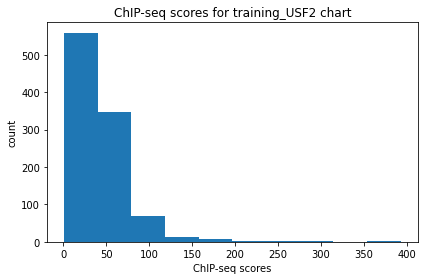

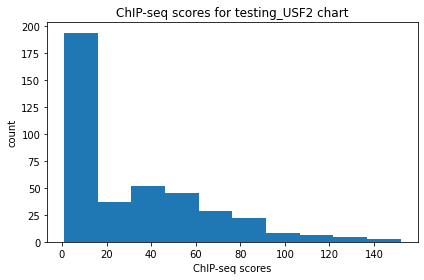

In [332]:
# loading training data for TF USF2
Y_train_USF2 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train.bed")
Y_trainlabel_USF2 = Chiseqscore_to_label(Y_train_USF2)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train.bed", TF_name ="USF2", datatype = "training")
matrix_tensor_files_train_USF2, matrix_length_arr_train_USF2, dict_matrix_train_USF2  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/USF2/")
X_train_seq_all_tensor_train_USF2, X_train_seq_tensor_train_USF2 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train-sequence.fa", matrix_length_arr_train_USF2, matrix_tensor_files_train_USF2)
backgound_seq_all_tensor_train_USF2 = background_convolution_seq(matrix_length_arr_train_USF2, X_train_seq_tensor_train_USF2, matrix_tensor_files_train_USF2)
X_train_seq_all_tensor_noisefree_train_USF2 = log_pwm_background(X_train_seq_all_tensor_train_USF2, backgound_seq_all_tensor_train_USF2)
X_train_max_train_USF2 = X_max_generator(X_train_seq_all_tensor_noisefree_train_USF2)
X_train_flatten_train_USF2 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_USF2)

# loading testing data for TF USF2
Y_test_USF2 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test.bed")
Y_testlabel_USF2 = Chiseqscore_to_label(Y_test_USF2)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test.bed", TF_name ="USF2", datatype = "testing")
matrix_tensor_files_test_USF2, matrix_length_arr_test_USF2, dict_matrix_test_USF2  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/USF2/")
X_test_seq_all_tensor_test_USF2, X_test_seq_tensor_test_USF2 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test-sequence.fa", matrix_length_arr_test_USF2, matrix_tensor_files_test_USF2)
backgound_seq_all_tensor_test_USF2 = background_convolution_seq(matrix_length_arr_test_USF2, X_test_seq_tensor_test_USF2, matrix_tensor_files_test_USF2)
X_test_seq_all_tensor_noisefree_test_USF2 = log_pwm_background(X_test_seq_all_tensor_test_USF2, backgound_seq_all_tensor_test_USF2)
X_test_max_test_USF2 = X_max_generator(X_test_seq_all_tensor_noisefree_test_USF2)
X_test_flatten_test_USF2 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_USF2)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [335]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_USF2 = Y_trainlabel_USF2.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_USF2, Y_trainlabel_USF2, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_USF2 = Y_trainlabel_USF2.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_USF2, Y_trainlabel_USF2)


# Prediction on X_test_max_test_USF2
y_maxpred_test_USF2 = clf_train_max.predict(X_test_max_test_USF2)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF2, y_maxpred_test_USF2))



# X_train_flatten_train_TFname training 
Y_trainlabel_USF2 = Y_trainlabel_USF2.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_USF2, Y_trainlabel_USF2)
# Prediction on X_test_flatten_test_USF2
y_flattenpred_test_USF2 = clf_train_flatten.predict(X_test_flatten_test_USF2)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF2, y_flattenpred_test_USF2))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_USF2) 
metrics.accuracy_score(Y_trainlabel_USF2, y_train_max_pred)

0.7319999999999999
Accuracy: 0.7275
Accuracy: 0.5325


0.878

In [336]:
print(dict_matrix_train_USF2)
# print(matrix_tensor_files_train_USF2[3])
# print(matrix_tensor_files_train_USF2[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_USF2[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'USF2_GM12878_4.wtmx': 0, 'USF2_GM12878_3.wtmx': 1, 'USF2_FB_1.wtmx': 2, 'USF2_HOCO_A.wtmx': 3, 'USF2_GM12878_5.wtmx': 4, 'USF2_GM12878_1.wtmx': 5, 'USF2_GM12878_2.wtmx': 6}
(7, 21, 4)


In [339]:
one_wtmx = np.tile(matrix_tensor_files_train_USF2[0],(7, 1,1))
# loading training data for TF USF2
Y_train_USF2 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train.bed")
Y_trainlabel_USF2 = Chiseqscore_to_label(Y_train_USF2)

X_train_seq_all_tensor_train_USF2, X_train_seq_tensor_train_USF2 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-train-sequence.fa", matrix_length_arr_train_USF2, one_wtmx)
backgound_seq_all_tensor_train_USF2 = background_convolution_seq(matrix_length_arr_train_USF2, X_train_seq_tensor_train_USF2, one_wtmx)
X_train_seq_all_tensor_noisefree_train_USF2 = log_pwm_background(X_train_seq_all_tensor_train_USF2, backgound_seq_all_tensor_train_USF2)
X_train_max_train_USF2 = X_max_generator(X_train_seq_all_tensor_noisefree_train_USF2)

# loading testing data for TF USF2
Y_test_USF2 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test.bed")
Y_testlabel_USF2 = Chiseqscore_to_label(Y_test_USF2)

X_test_seq_all_tensor_test_USF2, X_test_seq_tensor_test_USF2 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/USF2/USF2-test-sequence.fa", matrix_length_arr_test_USF2, one_wtmx)
backgound_seq_all_tensor_test_USF2 = background_convolution_seq(matrix_length_arr_test_USF2, X_test_seq_tensor_test_USF2, one_wtmx)
X_test_seq_all_tensor_noisefree_test_USF2 = log_pwm_background(X_test_seq_all_tensor_test_USF2, backgound_seq_all_tensor_test_USF2)
X_test_max_test_USF2 = X_max_generator(X_test_seq_all_tensor_noisefree_test_USF2)

# Y_trainlabel_USF2 = label_cleaning(Y_trainlabel_USF2, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_USF2 = Y_trainlabel_USF2.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_USF2, Y_trainlabel_USF2)
# Prediction on X_test_max_test_USF2
y_maxpred_test_USF2 = clf_train_max.predict(X_test_max_test_USF2)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_USF2, y_maxpred_test_USF2))

Accuracy: 0.4925


In [341]:
# print(X_test_seq_all_tensor_noisefree_test_USF2.shape)
# print(X_test_seq_all_tensor_noisefree_test_USF2)
# print(X_train_seq_all_tensor_noisefree_train_USF2.shape)
# print(X_train_seq_all_tensor_noisefree_train_USF2)

### **TF: YY1** 



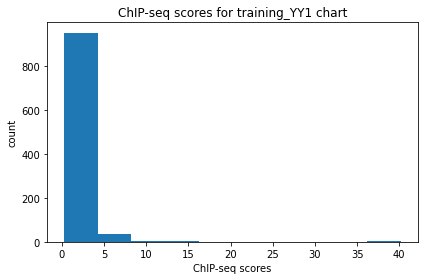

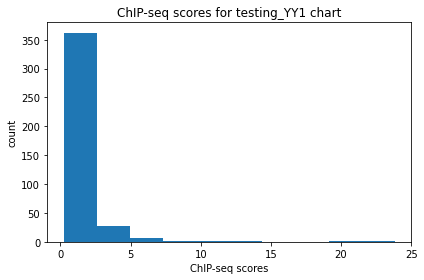

In [342]:
# loading training data for TF YY1
Y_train_YY1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train.bed")
Y_trainlabel_YY1 = Chiseqscore_to_label(Y_train_YY1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train.bed", TF_name ="YY1", datatype = "training")
matrix_tensor_files_train_YY1, matrix_length_arr_train_YY1, dict_matrix_train_YY1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/YY1/")
X_train_seq_all_tensor_train_YY1, X_train_seq_tensor_train_YY1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train-sequence.fa", matrix_length_arr_train_YY1, matrix_tensor_files_train_YY1)
backgound_seq_all_tensor_train_YY1 = background_convolution_seq(matrix_length_arr_train_YY1, X_train_seq_tensor_train_YY1, matrix_tensor_files_train_YY1)
X_train_seq_all_tensor_noisefree_train_YY1 = log_pwm_background(X_train_seq_all_tensor_train_YY1, backgound_seq_all_tensor_train_YY1)
X_train_max_train_YY1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_YY1)
X_train_flatten_train_YY1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_YY1)

# loading testing data for TF YY1
Y_test_YY1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test.bed")
Y_testlabel_YY1 = Chiseqscore_to_label(Y_test_YY1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test.bed", TF_name ="YY1", datatype = "testing")
matrix_tensor_files_test_YY1, matrix_length_arr_test_YY1, dict_matrix_test_YY1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/YY1/")
X_test_seq_all_tensor_test_YY1, X_test_seq_tensor_test_YY1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test-sequence.fa", matrix_length_arr_test_YY1, matrix_tensor_files_test_YY1)
backgound_seq_all_tensor_test_YY1 = background_convolution_seq(matrix_length_arr_test_YY1, X_test_seq_tensor_test_YY1, matrix_tensor_files_test_YY1)
X_test_seq_all_tensor_noisefree_test_YY1 = log_pwm_background(X_test_seq_all_tensor_test_YY1, backgound_seq_all_tensor_test_YY1)
X_test_max_test_YY1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_YY1)
X_test_flatten_test_YY1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_YY1)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [350]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_YY1 = Y_trainlabel_YY1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_YY1, Y_trainlabel_YY1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_YY1 = Y_trainlabel_YY1.reshape(-1)
clf_train_max = SVC(C = 0.01, random_state=42)
clf_train_max.fit(X_train_max_train_YY1, Y_trainlabel_YY1)


# Prediction on X_test_max_test_YY1
y_maxpred_test_YY1 = clf_train_max.predict(X_test_max_test_YY1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_YY1, y_maxpred_test_YY1))



# X_train_flatten_train_TFname training 
Y_trainlabel_YY1 = Y_trainlabel_YY1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_YY1, Y_trainlabel_YY1)
# Prediction on X_test_flatten_test_YY1
y_flattenpred_test_YY1 = clf_train_flatten.predict(X_test_flatten_test_YY1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_YY1, y_flattenpred_test_YY1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_YY1) 
metrics.accuracy_score(Y_trainlabel_YY1, y_train_max_pred)

0.605
Accuracy: 0.6425
Accuracy: 0.625


0.806

In [352]:
print(dict_matrix_train_YY1)
# print(matrix_tensor_files_train_YY1[3])
# print(matrix_tensor_files_train_YY1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_YY1[4],(6, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'YY1_GM12878_5.wtmx': 0, 'YY1_GM12878_1.wtmx': 1, 'YY1_GM12878_2.wtmx': 2, 'YY1_GM12878_3.wtmx': 3, 'YY1_FB_1.wtmx': 4, 'YY1_GM12878_4.wtmx': 5}
(6, 21, 4)


In [353]:
one_wtmx = np.tile(matrix_tensor_files_train_YY1[0],(6, 1,1))
# loading training data for TF YY1
Y_train_YY1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train.bed")
Y_trainlabel_YY1 = Chiseqscore_to_label(Y_train_YY1)

X_train_seq_all_tensor_train_YY1, X_train_seq_tensor_train_YY1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-train-sequence.fa", matrix_length_arr_train_YY1, one_wtmx)
backgound_seq_all_tensor_train_YY1 = background_convolution_seq(matrix_length_arr_train_YY1, X_train_seq_tensor_train_YY1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_YY1 = log_pwm_background(X_train_seq_all_tensor_train_YY1, backgound_seq_all_tensor_train_YY1)
X_train_max_train_YY1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_YY1)

# loading testing data for TF YY1
Y_test_YY1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test.bed")
Y_testlabel_YY1 = Chiseqscore_to_label(Y_test_YY1)

X_test_seq_all_tensor_test_YY1, X_test_seq_tensor_test_YY1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/YY1/YY1-test-sequence.fa", matrix_length_arr_test_YY1, one_wtmx)
backgound_seq_all_tensor_test_YY1 = background_convolution_seq(matrix_length_arr_test_YY1, X_test_seq_tensor_test_YY1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_YY1 = log_pwm_background(X_test_seq_all_tensor_test_YY1, backgound_seq_all_tensor_test_YY1)
X_test_max_test_YY1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_YY1)

# Y_trainlabel_YY1 = label_cleaning(Y_trainlabel_YY1, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_YY1 = Y_trainlabel_YY1.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_YY1, Y_trainlabel_YY1)
# Prediction on X_test_max_test_YY1
y_maxpred_test_YY1 = clf_train_max.predict(X_test_max_test_YY1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_YY1, y_maxpred_test_YY1))

Accuracy: 0.5475


In [357]:
# print(X_test_seq_all_tensor_noisefree_test_YY1.shape)
# print(X_test_seq_all_tensor_noisefree_test_YY1)
# print(X_train_seq_all_tensor_noisefree_train_YY1.shape)
# print(X_train_seq_all_tensor_noisefree_train_YY1)

### **TF: ZEB1** 



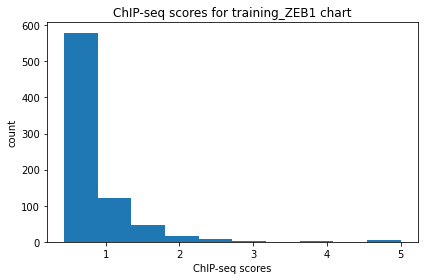

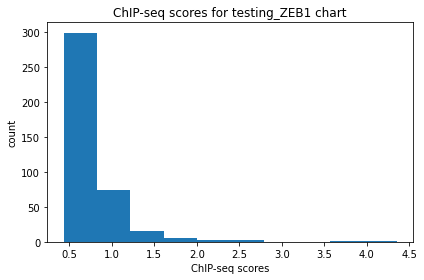

In [358]:
# loading training data for TF ZEB1
Y_train_ZEB1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train.bed")
Y_trainlabel_ZEB1 = Chiseqscore_to_label(Y_train_ZEB1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train.bed", TF_name ="ZEB1", datatype = "training")
matrix_tensor_files_train_ZEB1, matrix_length_arr_train_ZEB1, dict_matrix_train_ZEB1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ZEB1/")
X_train_seq_all_tensor_train_ZEB1, X_train_seq_tensor_train_ZEB1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train-sequence.fa", matrix_length_arr_train_ZEB1, matrix_tensor_files_train_ZEB1)
backgound_seq_all_tensor_train_ZEB1 = background_convolution_seq(matrix_length_arr_train_ZEB1, X_train_seq_tensor_train_ZEB1, matrix_tensor_files_train_ZEB1)
X_train_seq_all_tensor_noisefree_train_ZEB1 = log_pwm_background(X_train_seq_all_tensor_train_ZEB1, backgound_seq_all_tensor_train_ZEB1)
X_train_max_train_ZEB1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ZEB1)
X_train_flatten_train_ZEB1 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_ZEB1)

# loading testing data for TF ZEB1
Y_test_ZEB1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test.bed")
Y_testlabel_ZEB1 = Chiseqscore_to_label(Y_test_ZEB1)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test.bed", TF_name ="ZEB1", datatype = "testing")
matrix_tensor_files_test_ZEB1, matrix_length_arr_test_ZEB1, dict_matrix_test_ZEB1  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ZEB1/")
X_test_seq_all_tensor_test_ZEB1, X_test_seq_tensor_test_ZEB1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test-sequence.fa", matrix_length_arr_test_ZEB1, matrix_tensor_files_test_ZEB1)
backgound_seq_all_tensor_test_ZEB1 = background_convolution_seq(matrix_length_arr_test_ZEB1, X_test_seq_tensor_test_ZEB1, matrix_tensor_files_test_ZEB1)
X_test_seq_all_tensor_noisefree_test_ZEB1 = log_pwm_background(X_test_seq_all_tensor_test_ZEB1, backgound_seq_all_tensor_test_ZEB1)
X_test_max_test_ZEB1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ZEB1)
X_test_flatten_test_ZEB1 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_ZEB1)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [364]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_ZEB1 = Y_trainlabel_ZEB1.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_ZEB1, Y_trainlabel_ZEB1, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_ZEB1 = Y_trainlabel_ZEB1.reshape(-1)
clf_train_max = SVC(C = 0.01, random_state=42)
clf_train_max.fit(X_train_max_train_ZEB1, Y_trainlabel_ZEB1)


# Prediction on X_test_max_test_ZEB1
y_maxpred_test_ZEB1 = clf_train_max.predict(X_test_max_test_ZEB1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZEB1, y_maxpred_test_ZEB1))



# X_train_flatten_train_TFname training 
Y_trainlabel_ZEB1 = Y_trainlabel_ZEB1.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_ZEB1, Y_trainlabel_ZEB1)
# Prediction on X_test_flatten_test_ZEB1
y_flattenpred_test_ZEB1 = clf_train_flatten.predict(X_test_flatten_test_ZEB1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZEB1, y_flattenpred_test_ZEB1))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_ZEB1) 
metrics.accuracy_score(Y_trainlabel_ZEB1, y_train_max_pred)

0.6345820845820846
Accuracy: 0.515
Accuracy: 0.515


0.8123393316195373

In [366]:
print(dict_matrix_train_ZEB1)
# print(matrix_tensor_files_train_ZEB1[3])
# print(matrix_tensor_files_train_ZEB1[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_ZEB1[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'ZEB1_HOCO_B.wtmx': 0, 'ZEB1_GM12878_4.wtmx': 1, 'ZEB1_GM12878_3.wtmx': 2, 'ZEB1_GM12878_5.wtmx': 3, 'ZEB1_GM12878_1.wtmx': 4, 'ZEB1_GM12878_2.wtmx': 5, 'ZEB1_FB_1.wtmx': 6}
(7, 15, 4)


In [368]:
one_wtmx = np.tile(matrix_tensor_files_train_ZEB1[0],(7, 1,1))
# loading training data for TF ZEB1
Y_train_ZEB1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train.bed")
Y_trainlabel_ZEB1 = Chiseqscore_to_label(Y_train_ZEB1)

X_train_seq_all_tensor_train_ZEB1, X_train_seq_tensor_train_ZEB1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-train-sequence.fa", matrix_length_arr_train_ZEB1, one_wtmx)
backgound_seq_all_tensor_train_ZEB1 = background_convolution_seq(matrix_length_arr_train_ZEB1, X_train_seq_tensor_train_ZEB1, one_wtmx)
X_train_seq_all_tensor_noisefree_train_ZEB1 = log_pwm_background(X_train_seq_all_tensor_train_ZEB1, backgound_seq_all_tensor_train_ZEB1)
X_train_max_train_ZEB1 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ZEB1)

# loading testing data for TF ZEB1
Y_test_ZEB1 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test.bed")
Y_testlabel_ZEB1 = Chiseqscore_to_label(Y_test_ZEB1)

X_test_seq_all_tensor_test_ZEB1, X_test_seq_tensor_test_ZEB1 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZEB1/ZEB1-test-sequence.fa", matrix_length_arr_test_ZEB1, one_wtmx)
backgound_seq_all_tensor_test_ZEB1 = background_convolution_seq(matrix_length_arr_test_ZEB1, X_test_seq_tensor_test_ZEB1, one_wtmx)
X_test_seq_all_tensor_noisefree_test_ZEB1 = log_pwm_background(X_test_seq_all_tensor_test_ZEB1, backgound_seq_all_tensor_test_ZEB1)
X_test_max_test_ZEB1 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ZEB1)

# Y_trainlabel_ZEB1 = label_cleaning(Y_trainlabel_ZEB1, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_ZEB1 = Y_trainlabel_ZEB1.reshape(-1)
clf_train_max = SVC(C = 0.01, random_state=42)
clf_train_max.fit(X_train_max_train_ZEB1, Y_trainlabel_ZEB1)
# Prediction on X_test_max_test_ZEB1
y_maxpred_test_ZEB1 = clf_train_max.predict(X_test_max_test_ZEB1)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZEB1, y_maxpred_test_ZEB1))

Accuracy: 0.47


In [370]:
# print(X_test_seq_all_tensor_noisefree_test_ZEB1.shape)
# print(X_test_seq_all_tensor_noisefree_test_ZEB1)
# print(X_train_seq_all_tensor_noisefree_train_ZEB1.shape)
# print(X_train_seq_all_tensor_noisefree_train_ZEB1)

### **TF: ZNF143** 



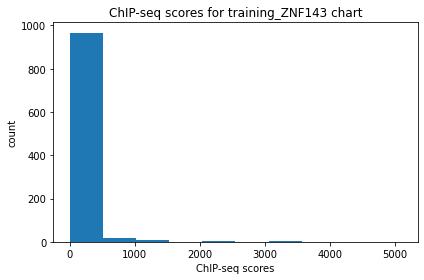

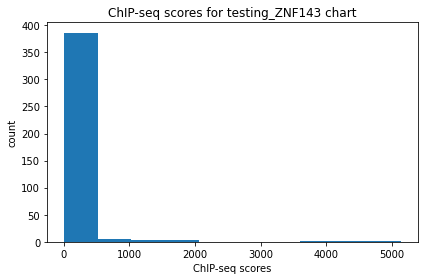

In [371]:
# loading training data for TF ZNF143
Y_train_ZNF143 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train.bed")
Y_trainlabel_ZNF143 = Chiseqscore_to_label(Y_train_ZNF143)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train.bed", TF_name ="ZNF143", datatype = "training")
matrix_tensor_files_train_ZNF143, matrix_length_arr_train_ZNF143, dict_matrix_train_ZNF143  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ZNF143/")
X_train_seq_all_tensor_train_ZNF143, X_train_seq_tensor_train_ZNF143 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train-sequence.fa", matrix_length_arr_train_ZNF143, matrix_tensor_files_train_ZNF143)
backgound_seq_all_tensor_train_ZNF143 = background_convolution_seq(matrix_length_arr_train_ZNF143, X_train_seq_tensor_train_ZNF143, matrix_tensor_files_train_ZNF143)
X_train_seq_all_tensor_noisefree_train_ZNF143 = log_pwm_background(X_train_seq_all_tensor_train_ZNF143, backgound_seq_all_tensor_train_ZNF143)
X_train_max_train_ZNF143 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ZNF143)
X_train_flatten_train_ZNF143 = X_flatten_generator(X_train_seq_all_tensor_noisefree_train_ZNF143)

# loading testing data for TF ZNF143
Y_test_ZNF143 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test.bed")
Y_testlabel_ZNF143 = Chiseqscore_to_label(Y_test_ZNF143)
cross_check_label_EDA("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test-sequence.fa","/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test.bed", TF_name ="ZNF143", datatype = "testing")
matrix_tensor_files_test_ZNF143, matrix_length_arr_test_ZNF143, dict_matrix_test_ZNF143  = pwm_conversion_padding ("/content/drive/MyDrive/CS582/topic1-data/ZNF143/")
X_test_seq_all_tensor_test_ZNF143, X_test_seq_tensor_test_ZNF143 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test-sequence.fa", matrix_length_arr_test_ZNF143, matrix_tensor_files_test_ZNF143)
backgound_seq_all_tensor_test_ZNF143 = background_convolution_seq(matrix_length_arr_test_ZNF143, X_test_seq_tensor_test_ZNF143, matrix_tensor_files_test_ZNF143)
X_test_seq_all_tensor_noisefree_test_ZNF143 = log_pwm_background(X_test_seq_all_tensor_test_ZNF143, backgound_seq_all_tensor_test_ZNF143)
X_test_max_test_ZNF143 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ZNF143)
X_test_flatten_test_ZNF143 = X_flatten_generator(X_test_seq_all_tensor_noisefree_test_ZNF143)

In [ ]:
# Y_trainlabel_REST = label_cleaning(Y_trainlabel_REST, violation_index_list = [769])

In [378]:
clf_test = SVC(C = 0.1, random_state=42)
Y_trainlabel_ZNF143 = Y_trainlabel_ZNF143.reshape(-1)
scores_test = cross_val_score(clf_test, X_train_max_train_ZNF143, Y_trainlabel_ZNF143, cv=10)
print(scores_test.mean())
# X_train_max_train_TFname training 
Y_trainlabel_ZNF143 = Y_trainlabel_ZNF143.reshape(-1)
clf_train_max = SVC(C = 0.1, random_state=42)
clf_train_max.fit(X_train_max_train_ZNF143, Y_trainlabel_ZNF143)


# Prediction on X_test_max_test_ZNF143
y_maxpred_test_ZNF143 = clf_train_max.predict(X_test_max_test_ZNF143)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZNF143, y_maxpred_test_ZNF143))



# X_train_flatten_train_TFname training 
Y_trainlabel_ZNF143 = Y_trainlabel_ZNF143.reshape(-1)
clf_train_flatten = SVC(C = 0.1, random_state=42)
clf_train_flatten.fit(X_train_flatten_train_ZNF143, Y_trainlabel_ZNF143)
# Prediction on X_test_flatten_test_ZNF143
y_flattenpred_test_ZNF143 = clf_train_flatten.predict(X_test_flatten_test_ZNF143)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZNF143, y_flattenpred_test_ZNF143))


#training accuracy for max-pooling
y_train_max_pred = clf_train_max.predict(X_train_max_train_ZNF143) 
metrics.accuracy_score(Y_trainlabel_ZNF143, y_train_max_pred)

0.623
Accuracy: 0.665
Accuracy: 0.6325


0.765

In [379]:
print(dict_matrix_train_ZNF143)
# print(matrix_tensor_files_train_ZNF143[3])
# print(matrix_tensor_files_train_ZNF143[0].shape)
one_wtmx = np.tile(matrix_tensor_files_train_ZNF143[4],(7, 1,1))
print(one_wtmx.shape)
# print(one_wtmx)

{'ZNF143_FB_2.wtmx': 0, 'ZNF143_FB_1.wtmx': 1, 'ZNF143_GM12878_4.wtmx': 2, 'ZNF143_GM12878_5.wtmx': 3, 'ZNF143_GM12878_1.wtmx': 4, 'ZNF143_GM12878_3.wtmx': 5, 'ZNF143_GM12878_2.wtmx': 6}
(7, 30, 4)


In [380]:
one_wtmx = np.tile(matrix_tensor_files_train_ZNF143[0],(7, 1,1))
# loading training data for TF ZNF143
Y_train_ZNF143 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train.bed")
Y_trainlabel_ZNF143 = Chiseqscore_to_label(Y_train_ZNF143)

X_train_seq_all_tensor_train_ZNF143, X_train_seq_tensor_train_ZNF143 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-train-sequence.fa", matrix_length_arr_train_ZNF143, one_wtmx)
backgound_seq_all_tensor_train_ZNF143 = background_convolution_seq(matrix_length_arr_train_ZNF143, X_train_seq_tensor_train_ZNF143, one_wtmx)
X_train_seq_all_tensor_noisefree_train_ZNF143 = log_pwm_background(X_train_seq_all_tensor_train_ZNF143, backgound_seq_all_tensor_train_ZNF143)
X_train_max_train_ZNF143 = X_max_generator(X_train_seq_all_tensor_noisefree_train_ZNF143)

# loading testing data for TF ZNF143
Y_test_ZNF143 = load_Chiseq_Y("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test.bed")
Y_testlabel_ZNF143 = Chiseqscore_to_label(Y_test_ZNF143)

X_test_seq_all_tensor_test_ZNF143, X_test_seq_tensor_test_ZNF143 = pwm_convolution_seq("/content/drive/MyDrive/CS582/topic1-data/ZNF143/ZNF143-test-sequence.fa", matrix_length_arr_test_ZNF143, one_wtmx)
backgound_seq_all_tensor_test_ZNF143 = background_convolution_seq(matrix_length_arr_test_ZNF143, X_test_seq_tensor_test_ZNF143, one_wtmx)
X_test_seq_all_tensor_noisefree_test_ZNF143 = log_pwm_background(X_test_seq_all_tensor_test_ZNF143, backgound_seq_all_tensor_test_ZNF143)
X_test_max_test_ZNF143 = X_max_generator(X_test_seq_all_tensor_noisefree_test_ZNF143)

# Y_trainlabel_ZNF143 = label_cleaning(Y_trainlabel_ZNF143, violation_index_list = [108])

# X_train_max_train_TFname training 
Y_trainlabel_ZNF143 = Y_trainlabel_ZNF143.reshape(-1)
clf_train_max = SVC(C = 0.0001, random_state=42)
clf_train_max.fit(X_train_max_train_ZNF143, Y_trainlabel_ZNF143)
# Prediction on X_test_max_test_ZNF143
y_maxpred_test_ZNF143 = clf_train_max.predict(X_test_max_test_ZNF143)
print("Accuracy:",metrics.accuracy_score(Y_testlabel_ZNF143, y_maxpred_test_ZNF143))

Accuracy: 0.53


In [ ]:
# print(X_test_seq_all_tensor_noisefree_test_ZNF143.shape)
# print(X_test_seq_all_tensor_noisefree_test_ZNF143)
# print(X_train_seq_all_tensor_noisefree_train_ZNF143.shape)
# print(X_train_seq_all_tensor_noisefree_train_ZNF143)